In [1]:
import pandas as pd
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, Point
import os
from datetime import datetime, timedelta
import sys # For a more robust path finding for anaconda

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Rider Action Chain

## Setting data path

In [ ]:
import os
import pandas as pd
from datetime import datetime, timedelta
from shapely.geometry import LineString # 假设您后续会用到

# --- Configuration ---
# 请确保此路径指向您实际的数据目录结构
BASE_DATA_PATH = r"/content/drive/MyDrive/Deliver_chain/data/eleme_round1_train_20200313"

START_DATE_STR = "20200203"
END_DATE_STR = "20200203" # 为了测试，先处理一天的数据

# --- Helper Functions ---

def load_and_merge_daily_data(base_path, date_str):
    print(f"Processing date: {date_str}")

    action_file = os.path.join(base_path, 'action', f'action_{date_str}.txt')
    order_file = os.path.join(base_path, 'order', f'order_{date_str}.txt')
    courier_file = os.path.join(base_path, 'courier', f'courier_{date_str}.txt')
    distance_file = os.path.join(base_path, 'distance', f'distance_{date_str}.txt') # 新增：距离文件路径

    courier_cols_expected_in_output = ['level', 'speed', 'max_load']
    dfs = {}

    try:
        # Load action data
        if os.path.exists(action_file):
            print(f"  Attempting to load action file: {action_file}")
            dfs['action'] = pd.read_csv(action_file, sep=',', header=0)
            dfs['action'].columns = dfs['action'].columns.str.strip() # 清理列名
            print(f"    Action file loaded. Columns: {dfs['action'].columns.tolist()}")
            if 'expect_time' in dfs['action'].columns:
                dfs['action']['expect_time'] = pd.to_numeric(dfs['action']['expect_time'], errors='coerce')
            else:
                print(f"    CRITICAL ERROR: 'expect_time' column not found in {action_file}.")
                return None
            for col in ['courier_wave_start_lng', 'courier_wave_start_lat']:
                if col in dfs['action'].columns:
                    dfs['action'][col] = pd.to_numeric(dfs['action'][col], errors='coerce')
            if 'tracking_id' in dfs['action'].columns: # 确保tracking_id为字符串类型
                dfs['action']['tracking_id'] = dfs['action']['tracking_id'].astype(str)
        else:
            print(f"  Action file not found: {action_file}")
            return None

        # Load order data
        if os.path.exists(order_file):
            print(f"  Attempting to load order file: {order_file}")
            dfs['order'] = pd.read_csv(order_file, sep=',', header=0)
            dfs['order'].columns = dfs['order'].columns.str.strip()
            print(f"    Order file loaded. Columns: {dfs['order'].columns.tolist()}")
            # 将订单中的时间戳和坐标转换为数值类型
            for col_name in ['pick_lng', 'pick_lat', 'deliver_lng', 'deliver_lat',
                             'assigned_time', 'create_time', 'confirm_time',
                             'promise_deliver_time', 'estimate_pick_time']:
                if col_name in dfs['order'].columns:
                    dfs['order'][col_name] = pd.to_numeric(dfs['order'][col_name], errors='coerce')
            if 'tracking_id' in dfs['order'].columns: # 确保tracking_id为字符串类型
                dfs['order']['tracking_id'] = dfs['order']['tracking_id'].astype(str)
        else:
            print(f"  Order file not found: {order_file}.")
            return None

        # Load courier data
        if os.path.exists(courier_file):
            print(f"  Attempting to load courier file: {courier_file}")
            dfs['courier'] = pd.read_csv(courier_file, sep=',', header=0)
            dfs['courier'].columns = dfs['courier'].columns.str.strip()
            print(f"    Courier file loaded. Columns: {dfs['courier'].columns.tolist()}")
        else:
            print(f"  Courier file not found: {courier_file}. Courier info will be missing.")
            dfs['courier'] = pd.DataFrame(columns=['courier_id'] + courier_cols_expected_in_output)

        # Load distance data (新增)
        if os.path.exists(distance_file):
            print(f"  Attempting to load distance file: {distance_file}")
            dfs['distance'] = pd.read_csv(distance_file, sep=',', header=0)
            dfs['distance'].columns = dfs['distance'].columns.str.strip()
            # 确保 distance.txt 中的 tracking_id 和 target_tracking_id 是字符串类型
            if 'tracking_id' in dfs['distance'].columns: # distance.txt中的tracking_id是source_tracking_id
                dfs['distance']['tracking_id'] = dfs['distance']['tracking_id'].astype(str)
            if 'target_tracking_id' in dfs['distance'].columns:
                dfs['distance']['target_tracking_id'] = dfs['distance']['target_tracking_id'].astype(str)
            print(f"    Distance file loaded. Columns: {dfs['distance'].columns.tolist()}")
        else:
            print(f"  Distance file not found: {distance_file}. Real distances will be unavailable.")
            dfs['distance'] = pd.DataFrame() # 如果文件不存在，则创建一个空的DataFrame

        # --- Merging DataFrames ---
        merge_on_cols_action_order = ['courier_id', 'wave_index', 'tracking_id']

        # 检查合并键是否存在
        if not all(col in dfs['action'].columns for col in merge_on_cols_action_order):
            print(f"    ERROR: Action DF missing one or more key columns for merging: {merge_on_cols_action_order}.")
            return None
        if not all(col in dfs['order'].columns for col in merge_on_cols_action_order):
            print(f"    ERROR: Order DF missing one or more key columns for merging: {merge_on_cols_action_order}.")
            return None

        # 合并action和order，使用后缀处理重名非键列
        merged_df = pd.merge(dfs['action'], dfs['order'],
                             on=merge_on_cols_action_order,
                             how='left', suffixes=('_action', '_order'))

        # 合并courier数据
        if 'courier_id' in merged_df.columns and not dfs['courier'].empty and 'courier_id' in dfs['courier'].columns:
            dfs['courier'] = dfs['courier'].drop_duplicates(subset=['courier_id'], keep='first')
            final_merged_df = pd.merge(merged_df, dfs['courier'], on='courier_id', how='left', suffixes=('', '_courier'))
        else:
            print("    Warning: Could not merge courier data. Check 'courier_id' columns or if courier_df is empty.")
            final_merged_df = merged_df
            for col in courier_cols_expected_in_output: # 确保列存在，即使是空的
                if col not in final_merged_df.columns: final_merged_df[col] = pd.NA


        final_merged_df['date'] = date_str
        print(f"    Successfully merged data for {date_str}. Resulting shape: {final_merged_df.shape}")
        return {
            'merged_data': final_merged_df,
            'distance_data': dfs.get('distance') # 返回加载的distance_df
        }

    except Exception as e:
        print(f"  Overall error in load_and_merge_daily_data for {date_str}: {e}")
        import traceback
        traceback.print_exc()
        return None

# --- Main Processing ---
all_waves_data = []

start_date_obj = datetime.strptime(START_DATE_STR, "%Y%m%d") # Renamed from start_date
end_date_obj = datetime.strptime(END_DATE_STR, "%Y%m%d")     # Renamed from end_date
current_date_processing = start_date_obj                     # Renamed from current_date

while current_date_processing <= end_date_obj:
    date_str_current = current_date_processing.strftime("%Y%m%d") # Renamed from date_str
    daily_data_package = load_and_merge_daily_data(BASE_DATA_PATH, date_str_current)

    if daily_data_package and daily_data_package.get('merged_data') is not None and not daily_data_package['merged_data'].empty:
        daily_merged_df = daily_data_package['merged_data']
        distance_df_day = daily_data_package.get('distance_data') # 获取当天的distance_df

        # 确定 'assigned_time' 列的正确名称 (可能因merge产生后缀)
        assigned_time_col = 'assigned_time_order' if 'assigned_time_order' in daily_merged_df.columns else 'assigned_time'
        if assigned_time_col not in daily_merged_df.columns:
            print(f"  Skipping wave processing for {date_str_current} due to missing '{assigned_time_col}' column.")
            current_date_processing += timedelta(days=1)
            continue
        if not all(col in daily_merged_df.columns for col in ['courier_id', 'wave_index', 'expect_time']):
            print(f"  Skipping wave processing for {date_str_current} due to missing key grouping/sorting columns.")
            current_date_processing += timedelta(days=1)
            continue

        grouped_waves = daily_merged_df.groupby(['courier_id', 'wave_index'])

        for (courier_id, wave_index), wave_df in grouped_waves:
            wave_df_sorted = wave_df.sort_values(by='expect_time').copy()

            if wave_df_sorted.empty:
                continue

            first_action_row = wave_df_sorted.iloc[0]

            # 从第一行获取骑手和波次的基础信息
            wave_start_lng = first_action_row.get('courier_wave_start_lng')
            wave_start_lat = first_action_row.get('courier_wave_start_lat')
            rider_level = first_action_row.get('level') # 可能已经是level_courier
            rider_speed = first_action_row.get('speed') # 可能已经是speed_courier
            rider_max_load = first_action_row.get('max_load') # 可能已经是max_load_courier
            weather = first_action_row.get('weather_grade_order', first_action_row.get('weather_grade', 'Unknown'))


            # 1. 获取并加入首次分配时间
            first_assign_time = None
            if not wave_df_sorted[assigned_time_col].isna().all():
                first_assign_time = wave_df_sorted[assigned_time_col].min()

            action_expect_times = []
            action_types_list = []
            if first_assign_time is not None and pd.notna(first_assign_time):
                action_expect_times.append(int(first_assign_time))
                action_types_list.append('ASSIGN')

            # 初始化用于构建LineString的点列表和真实距离列表
            points_for_ls = []
            real_distances_segments = [] # 用于存储每段的real_distance
            action_tracking_ids = [] # 保持原始逻辑

            # 添加波次起点
            if pd.notna(wave_start_lng) and pd.notna(wave_start_lat):
                points_for_ls.append((wave_start_lng, wave_start_lat))

            # 定义上一段的结束点信息，用于查找下一段距离
            prev_pt_lng = wave_start_lng
            prev_pt_lat = wave_start_lat
            # 对于从ASSIGN到第一个实际动作的距离，source_type是ASSIGN，source_tracking_id是第一个动作的订单ID
            prev_pt_type = 'ASSIGN'
            prev_pt_tracking_id = str(first_action_row.get('tracking_id')) if not wave_df_sorted.empty else None


            for _, action_row in wave_df_sorted.iterrows():
                action_tracking_ids.append(str(action_row.get('tracking_id'))) # 转换为字符串

                # 获取正确的action_type列名
                action_type_col = 'action_type_action' if 'action_type_action' in action_row else 'action_type'
                current_action_type_val = action_row.get(action_type_col)
                action_types_list.append(current_action_type_val)

                current_expect_time = action_row.get('expect_time')
                if pd.notna(current_expect_time):
                    action_expect_times.append(int(current_expect_time))

                # 获取当前行动点的坐标和类型
                current_pt_lng, current_pt_lat, current_pt_type_for_dist = None, None, None
                current_pt_tracking_id = str(action_row.get('tracking_id'))

                if current_action_type_val == 'PICKUP':
                    current_pt_type_for_dist = 'PICKUP'
                    pick_lng_col = 'pick_lng_order' if 'pick_lng_order' in action_row else 'pick_lng'
                    pick_lat_col = 'pick_lat_order' if 'pick_lat_order' in action_row else 'pick_lat'
                    if pd.notna(action_row.get(pick_lng_col)) and pd.notna(action_row.get(pick_lat_col)):
                        current_pt_lng, current_pt_lat = action_row[pick_lng_col], action_row[pick_lat_col]
                elif current_action_type_val == 'DELIVERY':
                    current_pt_type_for_dist = 'DELIVERY'
                    deliver_lng_col = 'deliver_lng_order' if 'deliver_lng_order' in action_row else 'deliver_lng'
                    deliver_lat_col = 'deliver_lat_order' if 'deliver_lat_order' in action_row else 'deliver_lat'
                    if pd.notna(action_row.get(deliver_lng_col)) and pd.notna(action_row.get(deliver_lat_col)):
                        current_pt_lng, current_pt_lat = action_row[deliver_lng_col], action_row[deliver_lat_col]

                segment_distance = None # 初始化当前段的距离
                if current_pt_lng is not None and current_pt_lat is not None:
                    points_for_ls.append((current_pt_lng, current_pt_lat))

                    # 2. 查找并记录当前段的 real_distance
                    if distance_df_day is not None and not distance_df_day.empty and \
                       prev_pt_tracking_id is not None and current_pt_tracking_id is not None and \
                       prev_pt_type is not None and current_pt_type_for_dist is not None:

                        # distance.txt中的'tracking_id'列是source_tracking_id
                        dist_row = distance_df_day[
                            (distance_df_day['courier_id'] == courier_id) &
                            (distance_df_day['wave_index'] == wave_index) &
                            (distance_df_day['tracking_id'] == prev_pt_tracking_id) &
                            (distance_df_day['source_type'] == prev_pt_type) &
                            (distance_df_day['target_tracking_id'] == current_pt_tracking_id) &
                            (distance_df_day['target_type'] == current_pt_type_for_dist)
                        ]
                        if not dist_row.empty:
                            segment_distance = dist_row.iloc[0]['grid_distance']
                        # else:
                            # print(f"      DEBUG: Distance not found for segment: C:{courier_id}-W:{wave_index} {prev_pt_type}@{prev_pt_tracking_id} -> {current_pt_type_for_dist}@{current_pt_tracking_id}")


                    # 更新上一段的结束点信息，作为下一段的起始点
                    prev_pt_lng, prev_pt_lat, prev_pt_type, prev_pt_tracking_id = \
                        current_pt_lng, current_pt_lat, current_pt_type_for_dist, current_pt_tracking_id

                real_distances_segments.append(segment_distance) # 加入当前段的距离（可能是None）

            geometry = None
            valid_points = [p for p in points_for_ls if p is not None and all(pd.notna(coord) for coord in p)]
            if len(valid_points) >= 2:
                try:
                    geometry = LineString(valid_points)
                except Exception as e_ls:
                    print(f"    Could not create LineString for C:{courier_id}, W:{wave_index}, Date:{date_str_current}: {e_ls}. Points: {valid_points}")

            all_waves_data.append({
                'courier_id': courier_id,
                'wave_index': wave_index,
                'date': date_str_current,
                'rider_level': rider_level,
                'rider_speed': rider_speed,
                'rider_max_load': rider_max_load,
                'weather_grade': weather,
                'wave_start_lng': wave_start_lng,
                'wave_start_lat': wave_start_lat,
                'num_actions_in_wave': len(action_types_list),
                'num_points_in_ls': len(valid_points),
                'tracking_ids_chronological': action_tracking_ids, # 对应action_types和expect_times中的物理动作
                'action_types_chronological': action_types_list,
                'expect_times_chronological': action_expect_times,
                'real_distances_segments': real_distances_segments, # 新增：分段真实距离列表
                'geometry': geometry
            })
    else:
        print(f"  No data loaded or merged for {date_str_current}. Skipping wave processing.")

    current_date_processing += timedelta(days=1)

Processing date: 20200203
  Attempting to load action file: /content/drive/MyDrive/Deliver_chain/data/eleme_round1_train_20200313/action/action_20200203.txt
    Action file loaded. Columns: ['courier_id', 'wave_index', 'tracking_id', 'courier_wave_start_lng', 'courier_wave_start_lat', 'action_type', 'expect_time']
  Attempting to load order file: /content/drive/MyDrive/Deliver_chain/data/eleme_round1_train_20200313/order/order_20200203.txt
    Order file loaded. Columns: ['courier_id', 'wave_index', 'tracking_id', 'weather_grade', 'pick_lng', 'pick_lat', 'deliver_lng', 'deliver_lat', 'create_time', 'confirm_time', 'assigned_time', 'promise_deliver_time', 'estimate_pick_time', 'aoi_id', 'shop_id']
  Attempting to load courier file: /content/drive/MyDrive/Deliver_chain/data/eleme_round1_train_20200313/courier/courier_20200203.txt
    Courier file loaded. Columns: ['courier_id', 'level', 'speed', 'max_load']
  Attempting to load distance file: /content/drive/MyDrive/Deliver_chain/data/ele

KeyboardInterrupt: 

In [ ]:
# --- Output or Further Processing ---
if all_waves_data:
    # 筛选具有有效几何对象的波次数据
    valid_geom_data = [d for d in all_waves_data if d.get('geometry') is not None]
    if valid_geom_data:
        gdf_valid_geom = pd.DataFrame(valid_geom_data)
        gdf_valid_geom = gpd.GeoDataFrame(
            gdf_valid_geom,
            geometry='geometry',
            crs="EPSG:4326" # 假设坐标是WGS84
        )
        print(f"\nCreated GeoDataFrame 'gdf_valid_geom' with {len(gdf_valid_geom)} waves.")
        print("Columns in gdf_valid_geom:", gdf_valid_geom.columns.tolist())

        # 打印包含新列的示例
        if 'real_distances_segments' in gdf_valid_geom.columns:
            print("\nSample of 'real_distances_segments':")
            print(gdf_valid_geom[['courier_id', 'wave_index', 'date', 'real_distances_segments']].head())

        if 'expect_times_chronological' in gdf_valid_geom.columns:
             print("\nSample of 'expect_times_chronological':")
             print(gdf_valid_geom[['courier_id', 'wave_index', 'date', 'expect_times_chronological']].head())
    else:
        print("\nNo waves with valid geometry found to create GeoDataFrame.")
else:
    print("\nNo wave data processed.")

In [ ]:
gdf_valid_geom

courier_id  wave_index      date  rider_level  rider_speed  \
0       10007871           0  20200202            3     4.455621   
1       10007871           1  20200202            3     4.455621   
2       10007871           2  20200202            3     4.455621   
3       10007871           3  20200202            3     4.455621   
4       10007871           4  20200202            3     4.455621   
...          ...         ...       ...          ...          ...   
2578   125964650           0  20200202            3     4.061028   
2579   125964650           1  20200202            3     4.061028   
2580   125964650           2  20200202            3     4.061028   
2581   125964650           3  20200202            3     4.061028   
2582   125964650           4  20200202            3     4.061028   

      rider_max_load weather_grade  wave_start_lng  wave_start_lat  \
0                 11         极恶劣天气      121.631571       39.142584   
1                 11         极恶劣天气      121.630212       39.146151   
2                 11         极恶劣天气      121.630625       39.142322   
3                 11         极恶劣天气      121.631526       39.142302   
4                 11          正常天气      121.630659       39.142483   
...              ...           ...             ...             ...   
2578              13         极恶劣天气      121.571849       39.146601   
2579              13         极恶劣天气      121.573890       39.142886   
2580              13         极恶劣天气      121.565801       39.144779   
2581              13         极恶劣天气      121.571521       39.146325   
2582              13         极恶劣天气      121.572038       39.147895   

      num_actions_in_wave  num_points_in_ls  \
0                       9                 9   
1                       5                 5   
2                       5                 5   
3                      11                11   
4                       5                 5   
...                   ...               ...   
2578                   13                13   
2579                    5                 5   
2580                    5                 5   
2581                    5                 5   
2582                    7                 7   

                             tracking_ids_chronological  \
0     [2100074596129441395, 2100074595828794671, 210...   
1     [2100074597950096486, 2100074599853589532, 210...   
2     [2100074601527674185, 2100074601520759910, 210...   
3     [2100074604652266788, 2100074603248420266, 210...   
4     [2100074607309194326, 2100074605623313536, 210...   
...                                                 ...   
2578  [2100074594371863557, 2100074595573236741, 210...   
2579  [2100074605304677583, 2100074605030442251, 210...   
2580  [2100074607488828417, 2100074607488828417, 210...   
2581  [2100074614108521690, 2100074618435470421, 210...   
2582  [2100074620840117291, 2100074621445637327, 210...   

                             action_types_chronological  \
0     [ASSIGN, PICKUP, PICKUP, DELIVERY, DELIVERY, P...   
1          [ASSIGN, PICKUP, PICKUP, DELIVERY, DELIVERY]   
2          [ASSIGN, PICKUP, PICKUP, DELIVERY, DELIVERY]   
3     [ASSIGN, PICKUP, PICKUP, PICKUP, DELIVERY, DEL...   
4          [ASSIGN, PICKUP, PICKUP, DELIVERY, DELIVERY]   
...                                                 ...   
2578  [ASSIGN, PICKUP, PICKUP, DELIVERY, PICKUP, DEL...   
2579       [ASSIGN, PICKUP, PICKUP, DELIVERY, DELIVERY]   
2580       [ASSIGN, PICKUP, DELIVERY, PICKUP, DELIVERY]   
2581       [ASSIGN, PICKUP, PICKUP, DELIVERY, DELIVERY]   
2582  [ASSIGN, PICKUP, PICKUP, DELIVERY, DELIVERY, P...   

                             expect_times_chronological  \
0     [1580613674, 1580614420, 1580614422, 158061517...   
1     [1580617034, 1580617765, 1580617974, 158061830...   
2     [1580620274, 1580620863, 1580620865, 158062140...   
3     [1580621654, 1580622259, 1580622821, 158062282...   
4     [1580625194, 1580625886, 1580625897, 158062602...   
...        

## 坐标校准

In [ ]:
import geopandas
from shapely.geometry import LineString # For type hinting if needed
from shapely.ops import transform as shapely_transform
import pandas as pd # Ensure pandas is imported

# --- Assume gdf_valid_geom is available from the previous processing steps ---
# It should be a GeoDataFrame with 'geometry_wave_path' as its active geometry column
# and CRS set to "EPSG:4326".
# Example (if you were to load it or for context):
# gdf_valid_geom = geopandas.GeoDataFrame(
#     pd.DataFrame(all_waves_data),
#     geometry='geometry_wave_path',
#     crs="EPSG:4326"
# )

# --- 1. Define Reference Coordinates and Calculate Offset ---
# (This part of your logic remains the same)
original_lon_ref = 121.453059
original_lat_ref = 39.009465
corrected_lon_ref = 116.329992
corrected_lat_ref = 39.79069

# Calculate offset
offset_lon = corrected_lon_ref - original_lon_ref
offset_lat = corrected_lat_ref - original_lat_ref

# --- 2. Define Calibration Functions ---
# (These functions from your code are well-defined for applying the offset)
def apply_coordinate_offsets(x, y, z=None):
    """
    Applies the pre-calculated longitude and latitude offsets to a single coordinate point (x, y).
    """
    return x + offset_lon, y + offset_lat

def calibrate_geometry(geom):
    """
    Calibrates a Shapely geometry object by applying the defined offsets
    to all its coordinate points.
    """
    if geom is None or geom.is_empty:
        return geom
    return shapely_transform(apply_coordinate_offsets, geom)

# --- 3. Apply Calibration to gdf_valid_geom ---

# Get the name of the active geometry column
# From your first script part, this should be 'geometry_wave_path'
active_geometry_col_name = gdf_valid_geom.geometry.name

print(f"Original CRS of gdf_valid_geom: {gdf_valid_geom.crs}")
print(f"Active geometry column: {active_geometry_col_name}")

# Print coordinates of the first geometry before calibration (if exists)
if not gdf_valid_geom.empty and gdf_valid_geom.iloc[0][active_geometry_col_name]:
    print("\nCoordinates of the first geometry BEFORE calibration:")
    try:
        print(list(gdf_valid_geom.iloc[0][active_geometry_col_name].coords))
    except Exception as e:
        print(f"Could not access coords: {e}")

# Apply the calibration function to the active geometry column
# This modifies the geometries in the 'geometry_wave_path' column (or whatever active_geometry_col_name is)
gdf_valid_geom[active_geometry_col_name] = gdf_valid_geom[active_geometry_col_name].apply(calibrate_geometry)

# Ensure the GeoDataFrame's geometry is correctly set (should be preserved if modified in-place)
# gdf_valid_geom = gdf_valid_geom.set_geometry(active_geometry_col_name, crs="EPSG:4326") # Re-assert if necessary

print("\nCalibration applied.")

# Print coordinates of the first geometry after calibration (if exists)
if not gdf_valid_geom.empty and gdf_valid_geom.iloc[0][active_geometry_col_name]:
    print("\nCoordinates of the first geometry AFTER calibration:")
    calibrated_coords = list(gdf_valid_geom.iloc[0][active_geometry_col_name].coords)
    print(calibrated_coords)

    # Example verification for the first point of the first geometry (if it had a known original value)
    # Replace with actual original coordinates of your first point if you want to verify
    # original_first_point_lon, original_first_point_lat = 121.630997, 39.142343 # Example
    # print(f"Expected first calibrated point based on example: ({original_first_point_lon + offset_lon}, {original_first_point_lat + offset_lat})")
    # print(f"Actual first calibrated point: {calibrated_coords[0]}")


# --- 4. Remove Specific Outlier Data ---
# (This part of your logic remains the same, applied after calibration)
# Note: This is a hardcoded outlier removal. For more general use,
# you might want to define outlier criteria more dynamically.
rows_before_outlier_removal = len(gdf_valid_geom)
gdf_valid_geom = gdf_valid_geom[
    ~(
        (gdf_valid_geom['courier_id'] == 115063897) &
        (gdf_valid_geom['date'] == '20200203') &
        (gdf_valid_geom['wave_index'] == 0)
    )
]
rows_after_outlier_removal = len(gdf_valid_geom)
print(f"\nRemoved {rows_before_outlier_removal - rows_after_outlier_removal} outlier row(s).")
print(f"GeoDataFrame shape after outlier removal: {gdf_valid_geom.shape}")


# --- 5. Prepare and Save to Shapefile ---
# (This part of your logic for handling complex data types before saving is good)
print("\nPreparing GeoDataFrame for Shapefile export...")
gdf_for_shapefile = gdf_valid_geom.copy()

# Identify columns with list/dict types that need conversion for Shapefile compatibility
columns_to_convert_to_str = []
for col in gdf_for_shapefile.columns:
    if col == gdf_for_shapefile.geometry.name: # Skip the geometry column itself
        continue

    # Check if the column is of object type and its non-null elements are lists or dicts
    if gdf_for_shapefile[col].dtype == 'object':
        non_null_series = gdf_for_shapefile[col].dropna()
        if not non_null_series.empty:
            first_val = non_null_series.iloc[0]
            if isinstance(first_val, (list, dict)):
                print(f"Column '{col}' contains list/dict objects and will be converted to string.")
                columns_to_convert_to_str.append(col)

# Convert identified columns to string
for col_name in columns_to_convert_to_str:
    gdf_for_shapefile[col_name] = gdf_for_shapefile[col_name].apply(
        lambda x: str(x) if isinstance(x, (list, dict)) else x
    )

# Define output path and save to Shapefile
output_directory = 'gis' # Define the directory
output_filename = os.path.join(output_directory, 'rider_action_chain_calibrated.shp') # Use .shp extension

# Ensure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created directory: {output_directory}")

try:
    gdf_for_shapefile.to_file(output_filename, driver='ESRI Shapefile', encoding='utf-8')
    print(f"GeoDataFrame successfully saved to '{output_filename}'")
except Exception as e:
    print(f"Error saving to Shapefile: {e}")
    print("\nPlease check potential issues:")
    print("1. All list/dict/complex object columns (except geometry) converted to string?")
    print("2. Column names too long? (Shapefile limit is 10 chars; GeoPandas truncates, but can cause issues).")
    print(f"   Current column names: {gdf_for_shapefile.columns.tolist()}")
    # You might need to manually shorten column names if truncation is problematic
    # Example: gdf_for_shapefile.columns = [col[:10] for col in gdf_for_shapefile.columns]
    # Be careful with renaming to avoid duplicate names, especially for the geometry column.

Original CRS of gdf_valid_geom: EPSG:4326
Active geometry column: geometry

Coordinates of the first geometry BEFORE calibration:
[(121.631571, 39.142584), (121.632454, 39.14279), (121.628645, 39.141264), (121.637284, 39.156251), (121.643444, 39.154601), (121.63791, 39.156114), (121.63791, 39.156105), (121.638174, 39.160331), (121.623484, 39.157531)]

Calibration applied.

Coordinates of the first geometry AFTER calibration:
[(116.508504, 39.923809), (116.509387, 39.924015), (116.50557800000001, 39.922489), (116.514217, 39.937476), (116.52037700000001, 39.935826), (116.51484300000001, 39.937339), (116.51484300000001, 39.937329999999996), (116.51510700000001, 39.941556), (116.50041700000001, 39.938756)]

Removed 0 outlier row(s).
GeoDataFrame shape after outlier removal: (2583, 16)

Preparing GeoDataFrame for Shapefile export...
Column 'tracking_ids_chronological' contains list/dict objects and will be converted to string.
Column 'action_types_chronological' contains list/dict objects a

C:\Users\1239546732\AppData\Local\Temp\ipykernel_1672\3276170806.py:136: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_for_shapefile.to_file(output_filename, driver='ESRI Shapefile', encoding='utf-8')


GeoDataFrame successfully saved to 'gis\rider_action_chain_calibrated.shp'


In [ ]:
gdf_valid_geom['wave_start_lng'] = gdf_valid_geom['wave_start_lng']+ offset_lon
gdf_valid_geom['wave_start_lat'] = gdf_valid_geom['wave_start_lat']+ offset_lat

In [ ]:
# gdf_valid_geom.to_csv(r'gdf_valid_geom_all.csv')
gdf_valid_geom.dtypes

courier_id                       int64
wave_index                       int64
date                            object
rider_level                      int64
rider_speed                    float64
rider_max_load                   int64
weather_grade                   object
wave_start_lng                 float64
wave_start_lat                 float64
num_actions_in_wave              int64
num_points_in_ls                 int64
tracking_ids_chronological      object
action_types_chronological      object
expect_times_chronological      object
real_distances_segments         object
geometry                      geometry
dtype: object

<Axes: >

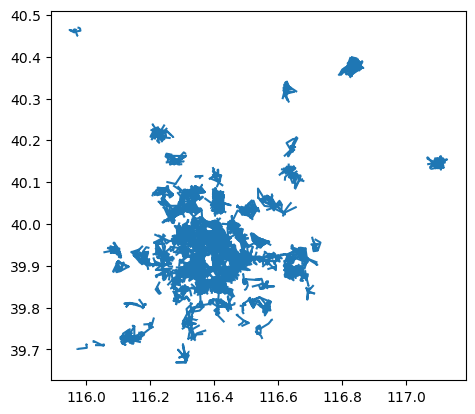

In [ ]:
gdf_valid_geom.plot()

# Navigation Trajectory Simulation

In [ ]:
gdf_valid_geom_all = pd.read_csv(r'/content/drive/MyDrive/Deliver_chain/gdf_valid_geom_all_20250526.csv')

In [ ]:
date_process = 20200227

gdf_valid_geom = gdf_valid_geom_all[gdf_valid_geom_all['date']== date_process].drop(columns=['Unnamed: 0'])
# --- 1. Correct the 'date' column ---
# The current dtype is int64, and the desired is object.
# Often, date columns are best as datetime objects for easier manipulation.
# If the int64 represents a format like YYYYMMDD:
try:
    gdf_valid_geom['date'] = pd.to_datetime(gdf_valid_geom['date'].astype(str), format='%Y%m%d')
    print("Successfully converted 'date' column to datetime objects.")
    # If you strictly need it as string 'object' as per your list, you can then convert:
    # gdf_valid_geom['date'] = gdf_valid_geom['date'].dt.strftime('%Y-%m-%d')
    # print("Converted 'date' column to string objects (YYYY-MM-DD format).")
except ValueError as e:
    print(f"Could not convert 'date' column to datetime using YYYYMMDD format: {e}")
    print("If 'date' is a different integer format (e.g., timestamp), adjust pd.to_datetime() accordingly.")
    print("Alternatively, to force it to object (string) directly from int:")
    # gdf_valid_geom['date'] = gdf_valid_geom['date'].astype(str)

# --- 2. Correct the 'geometry' column ---
# The current dtype is 'object', desired is 'geometry'.
# This usually means the 'object' column contains Well-Known Text (WKT) or similar.
if gdf_valid_geom['geometry'].dtype == 'object':
    try:
        # Attempt to convert from WKT strings to actual geometry objects
        # This operation can be slow on very large datasets
        gdf_valid_geom['geometry'] = gpd.GeoSeries.from_wkt(gdf_valid_geom['geometry'])
        # If 'gdf_valid_geom' wasn't a GeoDataFrame before, or to ensure CRS:
        # gdf_valid_geom = gpd.GeoDataFrame(gdf_valid_geom, geometry='geometry', crs="YOUR_CRS_HERE") # e.g., crs="EPSG:4326"
        print("Successfully converted 'geometry' column to geometry dtype.")
    except Exception as e:
        print(f"Could not convert 'geometry' column from WKT: {e}")
        print("Ensure the 'geometry' column contains valid WKT strings.")
# If it's already a GeoDataFrame, setting the geometry column might be enough if the objects are already shapely geometries
gdf_valid_geom = gdf_valid_geom.set_geometry('geometry')
gdf_valid_geom

Successfully converted 'date' column to datetime objects.
Successfully converted 'geometry' column to geometry dtype.


courier_id  wave_index       date  rider_level  rider_speed  \
72536    10007871           0 2020-02-27            3     5.769617   
72537    10007871           1 2020-02-27            3     5.769617   
72538    10007871           3 2020-02-27            3     5.769617   
72539    10012191           4 2020-02-27            3     5.673174   
72540    10012191           5 2020-02-27            3     5.673174   
...           ...         ...        ...          ...          ...   
76063   125964650           3 2020-02-27            3     5.929290   
76064   125964650           4 2020-02-27            3     5.929290   
76065   125964650           5 2020-02-27            3     5.929290   
76066   125964650           6 2020-02-27            3     5.929290   
76067   125996858           0 2020-02-27            3     5.573470   

       rider_max_load weather_grade  wave_start_lng  wave_start_lat  \
72536              11          正常天气      116.515759       39.922230   
72537              11          正常天气      116.511178       39.916133   
72538              11          正常天气      116.508047       39.923578   
72539              10          正常天气      116.402167       39.982364   
72540              10          正常天气      116.407139       39.982758   
...               ...           ...             ...             ...   
76063              11          正常天气      116.445586       39.929051   
76064              11          正常天气      116.445795       39.930919   
76065              11          正常天气      116.441133       39.923272   
76066              11          正常天气      116.428955       39.923689   
76067              11          正常天气      116.330121       39.989747   

       num_actions_in_wave  num_points_in_ls  \
72536                    7                 7   
72537                   11                11   
72538                    7                 7   
72539                    7                 7   
72540                    5                 5   
...                    ...               ...   
76063                    7                 7   
76064                    5                 5   
76065                    9                 9   
76066                    7                 7   
76067                   21                21   

                              tracking_ids_chronological  \
72536  ['2100075798613001430', '2100075798613001430',...   
72537  ['2100075807038506173', '2100075802897515606',...   
72538  ['2100075815349355600', '2100075817469183018',...   
72539  ['2100075850904700322', '2100075851196040478',...   
72540  ['2100075854325482605', '2100075854325482605',...   
...                                                  ...   
76063  ['2100075819983570050', '2100075822654227638',...   
76064  ['2100075826263065643', '2100075826263065643',...   
76065  ['2100075839016207376', '2100075836883108880',...   
76066  ['2100075847082968069', '2100075850821698678',...   
76067  ['2100075798466758362', '2100075798466758362',...   

                              action_types_chronological  \
72536  ['ASSIGN', 'PICKUP', 'DELIVERY', 'PICKUP', 'PI...   
72537  ['ASSIGN', 'PICKUP', 'PICKUP', 'DELIVERY', 'DE...   
72538  ['ASSIGN', 'PICKUP', 'PICKUP', 'PICKUP', 'DELI...   
72539  ['ASSIGN', 'PICKUP', 'PICKUP', 'PICKUP', 'DELI...   
72540  ['ASSIGN', 'PICKUP', 'DELIVERY', 'PICKUP', 'DE...   
...                                                  ...   
76063  ['ASSIGN', 'PICKUP', 'PICKUP', 'DELIVERY', 'DE...   
76064  ['ASSIGN', 'PICKUP', 'DELIVERY', 'PICKUP', 'DE...   
76065  ['ASSIGN', 'PICKUP', 'PICKUP', 'DELIVERY', 'DE...   
76066  ['ASSIGN', 'PICKUP', 'PICKUP', 'DELIVERY', 'DE...   
76067  ['ASSIGN', 'PICKUP', 'DELIVERY', 'PICKUP', 'DE...   

                              expect_times_chronological  \
72536  [1582772775, 1582773104, 1582773443, 158277431...   
72537  [1582774457, 1582775659, 1582775661, 158277595...   
72538  [1582779915, 1582780999, 1582781002, 158278100...   
72539  [1582802509, 1582804784, 1582805016, 158280502.

## Amap API

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import requests
import json
import time
import os

# --- Configuration ---
# !!! Replace with your actual Amap API Key list !!!
AMAP_API_KEYS = [
    "236dfc0a09c8f3269b3ee3857b30aec5",
    "1d223bf2195667ee1864be613d79312c",
    "b291edfc2f2bb1198e9ce825fea400c7",
    "875773914d104d2d3e6529bf0fa0f474",
    "b6141d3879c920c8f3254ae425a1e6c4",
    "8c6fcdb1a0ca03441c7465c72897b072",
    "b52e06d5c4c379d91d6b4a796c73fd3e",
    "445ee1ca6dd00a5508264a0ed7e9a234",
    "07efabbbe87a6f0b3ce0af4b77d71d39",
    "9bf7b3cd25ee9e2a4badb67f80dd5334",
    "3ba47c9e44ce45d3b7e6a0c41ed80107",
    "b4d1b91f7dfaa8d9ef39da61e2b66364",
    "6d6d017ac28dba8c70a3527d0d0afaee",
    "dcb3472baa04204902e6b7b3ff6ac16d",
    "1efb15d8badba84127d67dc79643672b",
    "cea86d456a8417007951702a7ff408e5",
    "151f0cd8f98b0bf6272ce42d11ffcdf1",
    "865dc5f8334e10872f84f3ffb6351bc7"
]
# Remove placeholder/example keys if they haven't been replaced with real ones
AMAP_API_KEYS = [key for key in AMAP_API_KEYS if not key.startswith("YOUR_") and len(key) == 32] # Basic check for key format

if not AMAP_API_KEYS:
    raise ValueError("AMAP_API_KEYS list is empty or contains invalid keys. Please provide valid API keys.")

CURRENT_API_KEY_INDEX = 0
# Using electrobike as per your code. If you need standard bicycling, change URL.
# AMAP_ROUTING_URL = "https://restapi.amap.com/v5/direction/electrobike"
AMAP_ROUTING_URL = "https://restapi.amap.com/v5/direction/bicycling" # Alternative

# --- File for saving progress and output ---
PROGRESS_FILE = 'amap_routing_progress.json'
# Define output directory
OUTPUT_DIR = '/content/drive/MyDrive/Deliver_chain/output_routes'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

FINAL_OUTPUT_FILE_CSV = os.path.join(OUTPUT_DIR, f'amap_routed_wave_data_{date_process}.csv')
FINAL_OUTPUT_FILE_PICKLE = os.path.join(OUTPUT_DIR, 'amap_routed_wave_data.pkl')

# --- Helper Function for API Key Management ---
def get_api_key():
    global CURRENT_API_KEY_INDEX
    key = AMAP_API_KEYS[CURRENT_API_KEY_INDEX]
    return key

def rotate_api_key():
    global CURRENT_API_KEY_INDEX
    CURRENT_API_KEY_INDEX = (CURRENT_API_KEY_INDEX + 1) % len(AMAP_API_KEYS)
    print(f"Rotated to API Key index: {CURRENT_API_KEY_INDEX} (Key ending: ...{AMAP_API_KEYS[CURRENT_API_KEY_INDEX][-4:]})")
    if CURRENT_API_KEY_INDEX == 0: # Cycled through all keys
        print("WARNING: Cycled through all API keys. Pausing for 60 seconds.")
        time.sleep(60) # Pause if all keys are exhausted in a short span
    return get_api_key()

# --- Function to make API call with retries and key rotation ---
def get_amap_route_for_segment(origin_lon, origin_lat, dest_lon, dest_lat, max_retries_per_key=3):
    origin_str = f"{origin_lon:.6f},{origin_lat:.6f}" # Format to 6 decimal places
    destination_str = f"{dest_lon:.6f},{dest_lat:.6f}"

    initial_key_index_for_segment = CURRENT_API_KEY_INDEX
    keys_tried_this_segment_cycle = 0

    while keys_tried_this_segment_cycle < len(AMAP_API_KEYS):
        current_key = get_api_key()
        params = {
            'key': current_key,
            'origin': origin_str,
            'destination': destination_str,
            'show_fields': 'cost,navi,polyline' # Get duration, detailed navi, and polylines
        }

        for attempt in range(max_retries_per_key):
            try:
                response = requests.get(AMAP_ROUTING_URL, params=params, timeout=15) # Increased timeout slightly
                response.raise_for_status()
                data = response.json()

                if data.get('status') == '1' and data.get('route') and data['route'].get('paths'):
                    return data # Success
                else:
                    infocode = data.get('infocode')
                    error_info = data.get('info', 'Unknown API error')
                    print(f"API Error with key ...{current_key[-4:]}: {error_info}, Infocode: {infocode} for segment {origin_str} to {destination_str}")
                    # Codes that usually mean quota/key issues: 10001-10004, 20000-20003, etc.
                    # If infocode suggests key/quota issue, rotate immediately.
                    critical_infocodes = ['10001', '10002', '10003', '10004', '20000', '20001', '20002', '20003', '20011', '20012']
                    if infocode in critical_infocodes:
                        print(f"Critical infocode {infocode}. Rotating API key.")
                        rotate_api_key()
                        break # Break from retry loop for this key, go to next key
                    # For other errors, retry with the same key up to max_retries_per_key
                    if attempt == max_retries_per_key - 1: # Last attempt for this key with non-critical error
                         print(f"Max retries for non-critical error with key ...{current_key[-4:]}. Rotating API key.")
                         rotate_api_key() # Rotate before trying next key cycle
                         break # Break from retry loop for this key, go to next key

                print(f"Retrying segment ({origin_str} to {destination_str}) with key ...{current_key[-4:]}, attempt {attempt + 2}/{max_retries_per_key}")

            except requests.exceptions.Timeout:
                print(f"Request timed out for segment ({origin_str} to {destination_str}) with key ...{current_key[-4:]}, attempt {attempt + 1}/{max_retries_per_key}")
                if attempt == max_retries_per_key - 1:
                    print(f"Max retries for timeout. Rotating API key.")
                    rotate_api_key()
                    break
            except requests.exceptions.RequestException as e:
                print(f"Request failed for segment ({origin_str} to {destination_str}): {e}, attempt {attempt + 1}/{max_retries_per_key}")
                if attempt == max_retries_per_key - 1:
                    print(f"Max retries for request exception. Rotating API key.")
                    rotate_api_key()
                    break
            except json.JSONDecodeError:
                print(f"Failed to decode JSON response for segment ({origin_str} to {destination_str}), attempt {attempt + 1}/{max_retries_per_key}")
                if attempt == max_retries_per_key - 1:
                    print(f"JSON decode error persisted. Rotating API key.")
                    rotate_api_key()
                    break

            time.sleep(1.5) # Wait a bit longer before retrying

        keys_tried_this_segment_cycle += 1
        # Check if we've cycled through all keys for THIS segment
        if CURRENT_API_KEY_INDEX == initial_key_index_for_segment and keys_tried_this_segment_cycle > 0:
             if keys_tried_this_segment_cycle >= len(AMAP_API_KEYS):
                print(f"Tried all API keys for segment ({origin_str} to {destination_str}). Segment failed definitively.")
                return None # Failed to get route for this segment after trying all keys

    print(f"Exhausted all keys and retries for segment ({origin_str} to {destination_str}). Segment failed.")
    return None

# --- Load or initialize results ---
processed_wave_results = []
start_processing_from_gdf_index = 0

if os.path.exists(PROGRESS_FILE):
    try:
        with open(PROGRESS_FILE, 'r') as f:
            processed_wave_results = json.load(f)
        if processed_wave_results:
            # The number of items in processed_wave_results corresponds to the number of GDF rows attempted.
            start_processing_from_gdf_index = len(processed_wave_results)
            print(f"Resuming from GDF original index {start_processing_from_gdf_index}. Loaded {len(processed_wave_results)} previous wave results.")
        else:
            print("Progress file was empty. Starting from scratch.")
    except json.JSONDecodeError:
        print(f"Error reading progress file {PROGRESS_FILE}. Starting from scratch.")
        processed_wave_results = []
    except Exception as e:
        print(f"An unexpected error occurred loading progress: {e}. Starting from scratch.")
        processed_wave_results = []


if 'gdf_valid_geom' not in locals():
     print("Error: gdf_valid_geom is not defined. Please load or pass the GeoDataFrame.")
     exit()

# Add an original index column to gdf_valid_geom for robust progress tracking
if 'original_gdf_index' not in gdf_valid_geom.columns:
    gdf_valid_geom['original_gdf_index'] = gdf_valid_geom.index


print(f"Total waves (rows in gdf_valid_geom) to process: {len(gdf_valid_geom)}")
if start_processing_from_gdf_index > 0:
    print(f"Skipping first {start_processing_from_gdf_index} waves as per progress file.")

# --- Main Processing Loop ---
for original_idx, wave_row in gdf_valid_geom.iloc[start_processing_from_gdf_index:].iterrows():
    print(f"\nProcessing Wave - Original GDF Index: {wave_row['original_gdf_index']} (Current loop index: {original_idx})")

    current_wave_output = {
        'original_gdf_index': wave_row['original_gdf_index'],
        'wave_processing_status': 'initiated',
        'wave_total_nav_distance_m': 0,
        'wave_total_nav_duration_s': 0,
        'routed_segments_details': [],
        'wave_routed_polyline_coords': [], # List of [lon, lat] for the entire wave's navigated path
    }
    # Copy other relevant columns from the original gdf_valid_geom row
    for col_name in gdf_valid_geom.columns:
        if col_name not in ['geometry', 'original_gdf_index']: # geometry is processed, index is stored
            current_wave_output[col_name] = wave_row[col_name]

    # Assuming the geometry column is named 'geometry'. If it's different (e.g. 'geometry_wave_path'), adjust here.
    wave_linestring = wave_row['geometry']
    if not isinstance(wave_linestring, LineString):
        print(f"  Skipping wave {wave_row['original_gdf_index']} due to invalid geometry type: {type(wave_linestring)}")
        current_wave_output['wave_processing_status'] = 'failed_invalid_geometry'
        processed_wave_results.append(current_wave_output)
        continue

    coords = list(wave_linestring.coords)
    num_original_segments = len(coords) - 1
    current_wave_output['num_original_segments'] = num_original_segments

    if num_original_segments < 1:
        print(f"  Skipping wave {wave_row['original_gdf_index']} as LineString has < 2 points (no segments).")
        current_wave_output['wave_processing_status'] = 'failed_insufficient_points'
        processed_wave_results.append(current_wave_output)
        # Save progress for skipped rows
        try:
            with open(PROGRESS_FILE, 'w') as f:
                json.dump(processed_wave_results, f, indent=2)
        except Exception as e_save:
            print(f"CRITICAL: Failed to save progress to {PROGRESS_FILE}: {e_save}")
        continue

    all_segments_in_wave_successfully_routed = True
    for i in range(num_original_segments):
        origin_coord = coords[i]
        dest_coord = coords[i+1]

        print(f"  Routing segment {i+1}/{num_original_segments}: ({origin_coord[0]:.6f},{origin_coord[1]:.6f}) to ({dest_coord[0]:.6f},{dest_coord[1]:.6f})")

        segment_api_response = get_amap_route_for_segment(origin_coord[0], origin_coord[1], dest_coord[0], dest_coord[1])
        time.sleep(0.2) # Small delay between API calls

        segment_detail = {
            'original_segment_index': i,
            'origin_coord': f"{origin_coord[0]:.6f},{origin_coord[1]:.6f}",
            'destination_coord': f"{dest_coord[0]:.6f},{dest_coord[1]:.6f}",
            'segment_status': 'pending',
        }

        if segment_api_response and segment_api_response['route']['paths']:
            path_data = segment_api_response['route']['paths'][0] # Using the first (default) path

            seg_dist_str = path_data.get('distance', '0')
            print(seg_dist_str) #######调试

            segment_nav_distance_m = int(seg_dist_str)

            # Robust duration parsing
            seg_dur_str = path_data.get('duration')
            if seg_dur_str is None: # Fallback to cost.duration if direct duration is not present
                seg_dur_str = path_data.get('cost', {}).get('duration', '0')
            segment_nav_duration_s = int(seg_dur_str)
            if i > 0:
                current_wave_output['wave_total_nav_distance_m'] += segment_nav_distance_m
            current_wave_output['wave_total_nav_duration_s'] += segment_nav_duration_s

            segment_polyline_str = path_data.get('polyline', '')
            segment_nav_coords = []
            if segment_polyline_str:
                try:
                    segment_nav_coords = [[float(p.split(',')[0]), float(p.split(',')[1])] for p in segment_polyline_str.split(';')]
                    # Add to full wave polyline, avoiding duplicate points
                    if not current_wave_output['wave_routed_polyline_coords'] or \
                       current_wave_output['wave_routed_polyline_coords'][-1] != segment_nav_coords[0]:
                        current_wave_output['wave_routed_polyline_coords'].extend(segment_nav_coords)
                    else:
                        current_wave_output['wave_routed_polyline_coords'].extend(segment_nav_coords[1:])
                except Exception as e_parse:
                    print(f"    Error parsing segment polyline: {e_parse}")


            step_by_step_details = []
            if 'steps' in path_data:
                for step_item in path_data['steps']:
                    step_dist_str = step_item.get('distance', '0')
                    # Robust step duration parsing
                    step_dur_str = step_item.get('duration')
                    if step_dur_str is None:
                        step_dur_str = step_item.get('cost', {}).get('duration', '0')

                    step_by_step_details.append({
                        'instruction': step_item.get('instruction'),
                        'road_name': step_item.get('road_name'),
                        'distance_m': int(step_dist_str),
                        'duration_s': int(step_dur_str),
                        'step_polyline_str': step_item.get('polyline'),
                        'action': step_item.get('navi', {}).get('action'),
                        'assistant_action': step_item.get('navi', {}).get('assistant_action'),
                    })

            segment_detail.update({
                'segment_status': 'success',
                'nav_distance_m': segment_nav_distance_m,
                'nav_duration_s': segment_nav_duration_s,
                'nav_polyline_coords': segment_nav_coords, # Parsed polyline for this segment
                'nav_steps': step_by_step_details,
                'api_infocode': segment_api_response.get('infocode')
            })
            print(f"    Segment {i+1} success. Distance: {segment_nav_distance_m}m, Duration: {segment_nav_duration_s}s")
        else:
            print(f"    Segment {i+1} FAILED to route.")
            segment_detail.update({
                'segment_status': 'failed_to_route',
                'api_infocode': segment_api_response.get('infocode') if segment_api_response else "NoResponse/Error"
            })
            all_segments_in_wave_successfully_routed = False

        current_wave_output['routed_segments_details'].append(segment_detail)

    # Finalize wave processing status
    if num_original_segments > 0: # only if there were segments to process
        if all_segments_in_wave_successfully_routed:
            current_wave_output['wave_processing_status'] = 'complete_success'
        else:
            current_wave_output['wave_processing_status'] = 'complete_partial_failure'
    else: # Should have been caught by insufficient points check
        current_wave_output['wave_processing_status'] = 'no_segments_to_process'


    processed_wave_results.append(current_wave_output)

    # Save progress after each wave is processed
    try:
        with open(PROGRESS_FILE, 'w') as f:
            json.dump(processed_wave_results, f, indent=2)
        print(f"  Progress saved for wave (Original GDF Index: {wave_row['original_gdf_index']}). Total waves processed/attempted: {len(processed_wave_results)}")
    except Exception as e_save:
        print(f"CRITICAL: Failed to save progress to {PROGRESS_FILE} after wave {wave_row['original_gdf_index']}: {e_save}")

print("\n--- All Wave Processing Complete ---")

# --- Convert final results to DataFrame and save ---
if processed_wave_results:
    final_results_df = pd.DataFrame(processed_wave_results)

    try:
        final_results_df.to_csv(FINAL_OUTPUT_FILE_CSV, index=False, encoding='utf-8-sig')
        print(f"Final results saved to CSV: {FINAL_OUTPUT_FILE_CSV}")
    except Exception as e_csv:
        print(f"Error saving final results to CSV: {e_csv}")

    try:
        final_results_df.to_pickle(FINAL_OUTPUT_FILE_PICKLE)
        print(f"Final results saved to Pickle: {FINAL_OUTPUT_FILE_PICKLE} (preserves complex data types)")
    except Exception as e_pkl:
        print(f"Error saving final results to Pickle: {e_pkl}")

    print("\nSample of final DataFrame:")
    print(final_results_df[['original_gdf_index', 'wave_processing_status', 'wave_total_nav_distance_m', 'wave_total_nav_duration_s']].head())
else:
    print("No wave results were processed or generated.")

流式输出内容被截断，只能显示最后 5000 行内容。
    Segment 7 success. Distance: 540m, Duration: 182s
  Routing segment 8/8: (116.257543,40.099765) to (116.257967,40.110676)
2747
    Segment 8 success. Distance: 2747m, Duration: 831s
CRITICAL: Failed to save progress to amap_routing_progress.json after wave 75847: Object of type Timestamp is not JSON serializable

Processing Wave - Original GDF Index: 75848 (Current loop index: 75848)
  Routing segment 1/8: (116.277744,40.095344) to (116.279082,40.097299)
411
    Segment 1 success. Distance: 411m, Duration: 140s
  Routing segment 2/8: (116.279082,40.097299) to (116.279082,40.097299)
1
    Segment 2 success. Distance: 1m, Duration: 0s
  Routing segment 3/8: (116.279082,40.097299) to (116.278863,40.097271)
16
    Segment 3 success. Distance: 16m, Duration: 5s
  Routing segment 4/8: (116.278863,40.097271) to (116.279367,40.095188)
253
    Segment 4 success. Distance: 253m, Duration: 92s
  Routing segment 5/8: (116.279367,40.095188) to (116.246457,40.084556)
3

In [ ]:
# --- Convert final results to DataFrame and save ---
if processed_wave_results:
    final_results_df = pd.DataFrame(processed_wave_results)

    try:
        final_results_df.to_csv(FINAL_OUTPUT_FILE_CSV, index=False, encoding='utf-8-sig')
        print(f"Final results saved to CSV: {FINAL_OUTPUT_FILE_CSV}")
    except Exception as e_csv:
        print(f"Error saving final results to CSV: {e_csv}")

    try:
        final_results_df.to_pickle(FINAL_OUTPUT_FILE_PICKLE)
        print(f"Final results saved to Pickle: {FINAL_OUTPUT_FILE_PICKLE} (preserves complex data types)")
    except Exception as e_pkl:
        print(f"Error saving final results to Pickle: {e_pkl}")

    print("\nSample of final DataFrame:")
    print(final_results_df[['original_gdf_index', 'wave_processing_status', 'wave_total_nav_distance_m', 'wave_total_nav_duration_s']].head())
else:
    print("No wave results were processed or generated.")

Final results saved to CSV: output_routes\amap_routed_wave_data.csv
Final results saved to Pickle: output_routes\amap_routed_wave_data.pkl (preserves complex data types)

Sample of final DataFrame:
   original_gdf_index wave_processing_status  wave_total_nav_distance_m  \
0                   0       complete_success                       9627   
1                   1       complete_success                       9985   
2                   2       complete_success                       9779   
3                   3       complete_success                       7403   
4                   4       complete_success                       4102   

   wave_total_nav_duration_s  
0                       2954  
1                       3127  
2                       3132  
3                       2203  
4                       1253  


In [ ]:
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import LineString, Point
# import requests
# import json
# import time
# import os

# # --- Configuration ---
# # !!! Replace with your Amap API Key list if different from the prompt !!!
# AMAP_API_KEYS = [
#     "236dfc0a09c8f3269b3ee3857b30aec5",
#     "1d223bf2195667ee1864be613d79312c",
#     "b291edfc2f2bb1198e9ce825fea400c7",
#     "875773914d104d2d3e6529bf0fa0f474",
#     "b6141d3879c920c8f3254ae425a1e6c4",
#     "8c6fcdb1a0ca03441c7465c72897b072",
#     "b52e06d5c4c379d91d6b4a796c73fd3e",
#     "445ee1ca6dd00a5508264a0ed7e9a234",
#     "07efabbbe87a6f0b3ce0af4b77d71d39",
#     "9bf7b3cd25ee9e2a4badb67f80dd5334",
#     "3ba47c9e44ce45d3b7e6a0c41ed80107",
#     "b4d1b91f7dfaa8d9ef39da61e2b66364",
#     "6d6d017ac28dba8c70a3527d0d0afaee",
#     "dcb3472baa04204902e6b7b3ff6ac16d",
#     "1efb15d8badba84127d67dc79643672b",
#     "cea86d456a8417007951702a7ff408e5",
#     "151f0cd8f98b0bf6272ce42d11ffcdf1"
# ]
# # Remove placeholder keys if they haven't been replaced
# AMAP_API_KEYS = [key for key in AMAP_API_KEYS if not key.startswith("YOUR_")]

# if not AMAP_API_KEYS:
#     raise ValueError("AMAP_API_KEYS list is empty. Please provide valid API keys.")

# CURRENT_API_KEY_INDEX = 0
# AMAP_ELECTROBIKE_URL = "https://restapi.amap.com/v5/direction/electrobike"

# # --- File for saving progress ---
# PROGRESS_FILE = 'amap_routing_progress.json'
# FINAL_OUTPUT_FILE_CSV = 'amap_routed_data.csv'
# FINAL_OUTPUT_FILE_PICKLE = 'amap_routed_data.pkl' # For preserving list structures better

# # --- Helper Function for API Key Management ---
# def get_api_key():
#     global CURRENT_API_KEY_INDEX
#     key = AMAP_API_KEYS[CURRENT_API_KEY_INDEX]
#     return key

# def rotate_api_key():
#     global CURRENT_API_KEY_INDEX
#     CURRENT_API_KEY_INDEX = (CURRENT_API_KEY_INDEX + 1) % len(AMAP_API_KEYS)
#     print(f"Rotated to API Key index: {CURRENT_API_KEY_INDEX}")
#     if CURRENT_API_KEY_INDEX == 0: # Cycled through all keys
#         print("WARNING: Cycled through all API keys. Pausing for a while.")
#         time.sleep(60) # Pause if all keys are exhausted in a short span
#     return get_api_key()

# # --- Function to make API call with retries and key rotation ---
# def get_ebike_route(origin_lon, origin_lat, dest_lon, dest_lat, max_retries_per_key=2):
#     origin_str = f"{origin_lon},{origin_lat}"
#     destination_str = f"{dest_lon},{dest_lat}"

#     initial_key_index = CURRENT_API_KEY_INDEX
#     keys_tried_in_cycle = 0

#     while keys_tried_in_cycle < len(AMAP_API_KEYS):
#         current_key = get_api_key()
#         params = {
#             'key': current_key,
#             'origin': origin_str,
#             'destination': destination_str,
#             'show_fields': 'cost,navi,polyline' # Get duration, detailed navi, and polylines
#         }

#         for attempt in range(max_retries_per_key):
#             try:
#                 response = requests.get(AMAP_ELECTROBIKE_URL, params=params, timeout=10)
#                 response.raise_for_status() # Raise HTTPError for bad responses (4XX or 5XX)
#                 data = response.json()

#                 if data.get('status') == '1' and data.get('route') and data['route'].get('paths'):
#                     return data # Success
#                 else:
#                     print(f"API Error with key {current_key[-4:]}: {data.get('info', 'Unknown error')}, Infocode: {data.get('infocode')}")
#                     # Specific infocodes that indicate quota issues or key problems often lead to key rotation
#                     # Common codes: 10001 (invalid key), 10003 (daily quota), 10004 (qps/minute quota),
#                     # 20000-20003 (various access denied/quota)
#                     # If it's a quota related error, better to rotate key immediately
#                     # For simplicity, we'll rotate on most errors other than 'OK'
#                     if data.get('infocode') not in ['10000']: # 10000 is OK
#                         print(f"Error suggests key issue or quota limit. Rotating API key.")
#                         rotate_api_key()
#                         break # Break from retry loop for this key, go to next key

#                     print(f"Retrying segment ({origin_str} to {destination_str}) with key {current_key[-4:]}, attempt {attempt + 1}/{max_retries_per_key}")

#             except requests.exceptions.RequestException as e:
#                 print(f"Request failed for segment ({origin_str} to {destination_str}): {e}")
#                 if attempt == max_retries_per_key - 1: # Last attempt for this key
#                      print(f"Max retries reached for key {current_key[-4:]}. Rotating API key.")
#                      rotate_api_key() # Rotate key after max retries for this specific key failed
#                      break # Break from retry loop, go to next key

#             except json.JSONDecodeError:
#                 print(f"Failed to decode JSON response for segment ({origin_str} to {destination_str})")
#                 # This might be a temporary server issue, retry. If persists, rotate.
#                 if attempt == max_retries_per_key - 1:
#                     print(f"JSON decode error persisted. Rotating API key.")
#                     rotate_api_key()
#                     break

#             time.sleep(1) # Wait a bit before retrying

#         keys_tried_in_cycle +=1
#         if CURRENT_API_KEY_INDEX == initial_key_index and keys_tried_in_cycle > 0 : # Full cycle completed
#              # This check is to ensure we break if we've tried all keys once for this specific segment
#              if keys_tried_in_cycle >= len(AMAP_API_KEYS):
#                 print(f"Tried all API keys for segment ({origin_str} to {destination_str}). Segment failed.")
#                 return None # Failed to get route for this segment after trying all keys

#     print(f"Exhausted all keys and retries for segment ({origin_str} to {destination_str}). Segment failed.")
#     return None


# # --- Load or initialize results ---
# processed_results = []
# start_index = 0

# if os.path.exists(PROGRESS_FILE):
#     try:
#         with open(PROGRESS_FILE, 'r') as f:
#             processed_results = json.load(f)
#         if processed_results: # Check if the list is not empty
#             # Assuming 'original_gdf_index' is stored in each result
#             # This simple check assumes rows are processed sequentially and no rows are skipped and re-attempted later
#             # A more robust way might be to store the index of the *next* row to process.
#             # For now, we assume if N items are in progress, first N rows of gdf were attempted.
#              start_index = len(processed_results)
#              print(f"Resuming from index {start_index}. Loaded {len(processed_results)} previous results.")
#         else:
#             print("Progress file was empty. Starting from scratch.")
#     except json.JSONDecodeError:
#         print(f"Error reading progress file {PROGRESS_FILE}. Starting from scratch.")
#         processed_results = [] # Ensure it's an empty list
#     except Exception as e:
#         print(f"An unexpected error occurred loading progress: {e}. Starting from scratch.")
#         processed_results = []


# # --- Prepare your GeoDataFrame (gdf_valid_geom) ---
# # For demonstration, let's create a dummy GeoDataFrame.
# # Replace this with your actual gdf_valid_geom loading.
# # data = {
# #     'courier_id': [1000787, 1000788],
# #     'wave_index': [10, 11],
# #     'date': [20200201, 20200201],
# #     'geometry': [
# #         LineString([(116.3975, 39.9085), (116.4039, 39.9150), (116.4103, 39.9198)]), # Beijing: Tiananmen -> Wangfujing -> Dongdan
# #         LineString([(121.4737, 31.2304), (121.4800, 31.2350), (121.4850, 31.2380), (121.4900, 31.2400)]) # Shanghai: People's Sq -> Nanjing Rd -> Bund area
# #     ]
# # }
# # gdf_valid_geom = gpd.GeoDataFrame(data, crs="EPSG:4326")
# # Add an original index column to gdf_valid_geom if it doesn't have a unique ID for rows
# gdf_valid_geom['original_gdf_index'] = gdf_valid_geom.index


# print(f"Total rows to process: {len(gdf_valid_geom)}")
# if start_index > 0:
#     print(f"Skipping first {start_index} rows as they are already processed.")

Resuming from index 191. Loaded 191 previous results.
Total rows to process: 2458
Skipping first 191 rows as they are already processed.


In [ ]:
# --- Main Processing Loop ---
for index, row in gdf_valid_geom.iloc[start_index:].iterrows():
    print(f"\nProcessing original_gdf_index: {row['original_gdf_index']} (current iteration index: {index})")

    current_row_data = {
        'original_gdf_index': row['original_gdf_index'],
        'num_segments_in_linestring': 0,
        'total_calculated_distance_meters': 0,
        'total_calculated_duration_seconds': 0,
        'segments_data': [], # To store details of each segment
        'full_route_polyline_coords': [], # List of [lon, lat] for the entire route
        'processing_status': 'partial' # Will be 'complete' or 'failed'
    }
    # Copy other relevant columns from the original gdf
    for col in gdf_valid_geom.columns:
        if col not in ['geometry', 'original_gdf_index']: # geometry is processed, index is stored
             current_row_data[col] = row[col]


    line = row['geometry']
    if not isinstance(line, LineString):
        print(f"  Skipping row {row['original_gdf_index']} due to invalid geometry type: {type(line)}")
        current_row_data['processing_status'] = 'failed_invalid_geometry'
        processed_results.append(current_row_data)
        continue

    coords = list(line.coords)
    current_row_data['num_segments_in_linestring'] = len(coords) - 1

    if len(coords) < 2:
        print(f"  Skipping row {row['original_gdf_index']} as LineString has less than 2 points.")
        current_row_data['processing_status'] = 'failed_insufficient_points'
        processed_results.append(current_row_data)
        # Save progress even for skipped rows to avoid reprocessing them
        try:
            with open(PROGRESS_FILE, 'w') as f:
                json.dump(processed_results, f, indent=2)
        except Exception as e:
            print(f"CRITICAL: Failed to save progress to {PROGRESS_FILE}: {e}")
        continue

    all_segments_successfully_routed = True
    for i in range(len(coords) - 1):
        origin_pt = coords[i]
        dest_pt = coords[i+1]

        print(f"  Routing segment {i+1}/{len(coords)-1}: ({origin_pt[0]:.6f},{origin_pt[1]:.6f}) to ({dest_pt[0]:.6f},{dest_pt[1]:.6f})")

        segment_route_data = get_ebike_route(origin_pt[0], origin_pt[1], dest_pt[0], dest_pt[1])
        time.sleep(0.1) # Small delay to respect API rate limits, even if not strictly enforced by key rotation

        if segment_route_data and segment_route_data['route']['paths']:
            path = segment_route_data['route']['paths'][0] # Using the first (default) path

            segment_distance = int(path.get('distance', 0))
            segment_duration = int(path.get('cost', {}).get('duration', 0))

            current_row_data['total_calculated_distance_meters'] += segment_distance
            current_row_data['total_calculated_duration_seconds'] += segment_duration

            segment_polyline_str = path.get('polyline', '')
            segment_coords = []
            if segment_polyline_str:
                segment_coords = [[float(p.split(',')[0]), float(p.split(',')[1])] for p in segment_polyline_str.split(';')]
                # Add to full route polyline, avoiding duplicate points between segments
                if not current_row_data['full_route_polyline_coords'] or current_row_data['full_route_polyline_coords'][-1] != segment_coords[0]:
                    current_row_data['full_route_polyline_coords'].extend(segment_coords)
                else:
                    current_row_data['full_route_polyline_coords'].extend(segment_coords[1:])


            steps_details = []
            if 'steps' in path:
                for step in path['steps']:
                    step_detail = {
                        'instruction': step.get('instruction'),
                        'orientation': step.get('orientation'),
                        'road_name': step.get('road_name'),
                        'step_distance': int(step.get('step_distance',0)),
                        'step_duration': int(step.get('cost', {}).get('duration', 0)) if 'cost' in step else 0,
                        'step_polyline': step.get('polyline'),
                        'action': step.get('navi', {}).get('action'),
                        'assistant_action': step.get('navi', {}).get('assistant_action')
                    }
                    steps_details.append(step_detail)

            current_row_data['segments_data'].append({
                'segment_index': i,
                'origin': f"{origin_pt[0]},{origin_pt[1]}",
                'destination': f"{dest_pt[0]},{dest_pt[1]}",
                'distance_meters': segment_distance,
                'duration_seconds': segment_duration,
                'polyline_coords': segment_coords, # Parsed polyline for this segment
                'steps': steps_details,
                'api_status': segment_route_data.get('infocode')
            })
            print(f"    Segment {i+1} success. Distance: {segment_distance}m, Duration: {segment_duration}s")
        else:
            print(f"    Segment {i+1} FAILED.")
            current_row_data['segments_data'].append({
                'segment_index': i,
                'origin': f"{origin_pt[0]},{origin_pt[1]}",
                'destination': f"{dest_pt[0]},{dest_pt[1]}",
                'status': 'failed_to_route',
                'api_status': segment_route_data.get('infocode') if segment_route_data else "No response"
            })
            all_segments_successfully_routed = False # Mark that at least one segment failed

    if all_segments_successfully_routed and (len(coords)-1 > 0) : # only complete if there were segments to process
         current_row_data['processing_status'] = 'complete'
    elif not all_segments_successfully_routed and (len(coords)-1 > 0) :
         current_row_data['processing_status'] = 'partial_failure' # some segments failed
    elif (len(coords)-1 == 0) : # No segments to process (e.g. single point linestring if not caught earlier)
         current_row_data['processing_status'] = 'no_segments'


    processed_results.append(current_row_data)

    # Save progress after each row
    try:
        with open(PROGRESS_FILE, 'w') as f:
            json.dump(processed_results, f, indent=2)
        print(f"  Progress saved for original_gdf_index: {row['original_gdf_index']}. Total results: {len(processed_results)}")
    except Exception as e:
        print(f"CRITICAL: Failed to save progress to {PROGRESS_FILE} after processing index {row['original_gdf_index']}: {e}")
        # Potentially stop or implement more robust temporary backup if this fails

print("\n--- Processing Complete ---")


# --- Optional: Clean up progress file after successful completion ---
# Consider if you want to automatically delete it or keep it.
# For safety, it's often better to manually delete it after verifying the final output.
# if os.path.exists(PROGRESS_FILE) and len(processed_results) == len(gdf_valid_geom):
#     print(f"Attempting to remove progress file: {PROGRESS_FILE}")
#     try:
#         os.remove(PROGRESS_FILE)
#         print("Progress file removed.")
#     except OSError as e:
#         print(f"Error removing progress file: {e}")


Processing original_gdf_index: 191 (current iteration index: 191)
  Routing segment 1/6: (116.287072,39.954234) to (116.293822,39.964875)
    Segment 1 success. Distance: 2323m, Duration: 0s
  Routing segment 2/6: (116.293822,39.964875) to (116.309447,39.946866)
    Segment 2 success. Distance: 3411m, Duration: 0s
  Routing segment 3/6: (116.309447,39.946866) to (116.293822,39.964875)
    Segment 3 success. Distance: 2968m, Duration: 0s
  Routing segment 4/6: (116.293822,39.964875) to (116.288414,39.960714)
API Error with key aec5: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
    Segment 4 success. Distance: 2356m, Duration: 0s
  Routing segment 5/6: (116.288414,39.960714) to (116.271847,39.954666)
API Error with key 312c: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
    Segment 5 success. Distance: 3216m, Durat

    Segment 3 success. Distance: 1573m, Duration: 0s
  Routing segment 4/4: (116.270559,40.148796) to (116.249197,40.147106)
API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
    Segment 4 success. Distance: 4812m, Duration: 0s
  Progress saved for original_gdf_index: 197. Total results: 198

Processing original_gdf_index: 198 (current iteration index: 198)
  Routing segment 1/4: (116.329037,39.990796) to (116.329185,39.990739)
    Segment 1 success. Distance: 14m, Duration: 0s
  Routing segment 2/4: (116.329185,39.990739) to (116.329137,39.991266)
API Error with key a234: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USER

    Segment 9 success. Distance: 1866m, Duration: 0s
  Routing segment 10/12: (116.340927,39.970626) to (116.337707,39.971586)
API Error with key 00c7: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 10 success. Distance: 233m, Duration: 0s
  Routing segment 11/12: (116.337707,39.971586) to (116.338116,39.972934)
API Error with key f474: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
    Segment 11 success. Distance: 306m, Duration: 0s
  Routing segment 12/12: (116.338116,39.972934) to (116.337587,39.964966)
    Segment 12 success. Distance: 1371m, Duration: 0s
  Progress saved for original_gdf_index: 201. Total results: 202

Processing original_gdf_index: 202 (current iteration index: 202)
  Routing segment 1/6: (116.331791,39.964831) to (116.316394,39.966747)
API Error with key e6c4: CUQPS_HAS_EXCEEDED_T

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
    Segment 2 success. Distance: 489m, Duration: 0s
  Routing segment 3/4: (116.327507,39.973166) to (116.323692,39.971408)
    Segment 3 success. Distance: 568m, Duration: 0s
  Routing segment 4/4: (116.323692,39.971408) to (116.326957,39.974816)
    Segment 4 success. Distance: 640m, Duration: 0s
  Progress saved for original_gdf_index: 205. Total results: 206

Processing original_gdf_index: 206 (current iteration index: 206)
  Routing segment 1/10: (116.310431,39.968550) to (116.323448,39.971733)
    Segment 1 success. Distance: 1878m, Dur

API Error with key b072: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
    Segment 13 success. Distance: 1902m, Duration: 0s
  Routing segment 14/14: (116.315424,39.966871) to (116.292897,39.972896)
API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
    Segment 14 success. Distance: 3408m, Duration: 0s
  Progress saved for original_gdf_index: 208. Total results: 209

Processing original_gdf_index: 209 (current iteration index: 209)
  Routing segment 1/6: (116.325115,39.967666) to (116.327951,39.969578)
    Segment 1 success. Distance: 443m, Duration: 0s
  Routing segment 2/6: (116.327951,39.969578) to (116.328978,39.974319)
    Segment 2 success. Distance: 1224m, Duration: 0s
  Routing segment 3/6: (116.328978,39.974319) to (116.323448,39.971733)
API Error with key a234: CUQPS_HAS_EXCEEDED_THE_L

    Segment 3 success. Distance: 287m, Duration: 0s
  Routing segment 4/22: (116.383331,39.951345) to (116.393317,39.950176)
    Segment 4 success. Distance: 1002m, Duration: 0s
  Routing segment 5/22: (116.393317,39.950176) to (116.397185,39.953525)
    Segment 5 success. Distance: 700m, Duration: 0s
  Routing segment 6/22: (116.397185,39.953525) to (116.400520,39.966067)
    Segment 6 success. Distance: 2267m, Duration: 0s
  Routing segment 7/22: (116.400520,39.966067) to (116.390677,39.969386)
API Error with key aec5: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
    Segment 7 success. Distance: 2855m, Duration: 0s
  Routing segment 8/22: (116.390677,39.969386) to (116.378207,39.971946)
    Segment 8 success. Distance: 1580m, Duration: 0s
  Routing segment 9/22: (116.378207,39.971946) to (116.391958,39.966242)
    Segment 9 success. Distance: 2935m, Duration: 0s
  Routing segment 10/22: (116.39195

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
    Segment 10 success. Distance: 1645m, Duration: 0s
  Routing segment 11/12: (116.395067,39.951226) to (116.406187,39.950046)
    Segment 11 success. Distance: 1482m, Duration: 0s
  Routing segment 12/12: (116.406187,39.950046) to (116.374587,39.949026)
    Segment 12 success. Distance: 3127m, Duration: 0s
  Progress saved for original_gdf_index: 216. Total results: 217

Processing original_gdf_index: 217 (current iteration index: 217)
  Routing segment 1/6: (116.388860,39.965771) to (116.391958,39.966242)
    Segment 1 success. Distance: 1

API Error with key e6c4: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
    Segment 4 success. Distance: 3551m, Duration: 0s
  Routing segment 5/6: (116.400397,39.844516) to (116.416297,39.847856)
    Segment 5 success. Distance: 2173m, Duration: 0s
  Routing segment 6/6: (116.416297,39.847856) to (116.422407,39.838436)
API Error with key b072: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
    Segment 6 success. Distance: 2285m, Duration: 0s
  Progress saved for original_gdf_index: 221. Total results: 222

Processing original_gdf_index: 222 (current iteration index: 222)
  Routing segment 1/4: (116.408462,39.864451) to (116.412681,39.865478)
    Segment 1 success. Distance: 403m, Duration: 0s
  Routing segment 2/4: (116.412681,39.865478) to (116.412681,39.865478)
API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT

API Error with key aec5: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
    Segment 1 success. Distance: 463m, Duration: 0s
  Routing segment 2/6: (116.361123,39.946227) to (116.361123,39.946227)
API Error with key 312c: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
    Segment 2 success. Distance: 1m, Duration: 0s
  Routing segment 3/6: (116.361123,39.946227) to (116.361272,39.946200)
    Segment 3 success. Distance: 14m, Duration: 0s
  Routing segment 4/6: (116.361272,39.946200) to (116.363607,39.938216)
API Error with key 00c7: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 4 success. Distance: 2111m, Duration: 0s
  Routing segment 5/6: (116.363607,39.938216) to (116.366837,39.930526)
API Error with key f474: CUQPS_H

    Segment 4 success. Distance: 2867m, Duration: 0s
  Progress saved for original_gdf_index: 231. Total results: 232

Processing original_gdf_index: 232 (current iteration index: 232)
  Routing segment 1/10: (116.626516,39.891669) to (116.639564,39.892090)
    Segment 1 success. Distance: 1107m, Duration: 0s
  Routing segment 2/10: (116.639564,39.892090) to (116.636937,39.892815)
API Error with key 0107: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API 

    Segment 4 success. Distance: 1153m, Duration: 0s
  Progress saved for original_gdf_index: 235. Total results: 236

Processing original_gdf_index: 236 (current iteration index: 236)
  Routing segment 1/14: (116.185609,39.924572) to (116.185497,39.924216)
    Segment 1 success. Distance: 16m, Duration: 0s
  Routing segment 2/14: (116.185497,39.924216) to (116.185282,39.924595)
API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
    Segment 2 success. Distance: 15m, Duration: 0s
  Routing segment 3/14: (116.185282,39.924595) to (116.187758,39.927490)
    Segment 3 success. Distance: 531m, Duration: 0s
  Routing segment 4/14: (116.187758,39.927490) to (116.168227,39.927966)
API Error with key a234: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infoco

    Segment 1 success. Distance: 595m, Duration: 0s
  Routing segment 2/6: (116.187758,39.927490) to (116.187758,39.927490)
API Error with key 00c7: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 2 success. Distance: 1m, Duration: 0s
  Routing segment 3/6: (116.187758,39.927490) to (116.186853,39.924765)
    Segment 3 success. Distance: 387m, Duration: 0s
  Routing segment 4/6: (116.186853,39.924765) to (116.183307,39.917246)
API Error with key f474: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
    Segment 4 success. Distance: 1240m, Duration: 0s
  Routing segment 5/6: (116.183307,39.917246) to (116.183797,39.909226)
API Error with key e6c4: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
    Segment 5 success. Distance

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
    Segment 2 success. Distance: 3507m, Duration: 0s
  Routing segment 3/8: (116.569897,40.060106) to (116.585304,40.046783)
API Error with key aec5: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
    Segment 3 success. Distance: 3722m, Duration: 0s
  Routing segment 4/8: (116.585304,40.046783) to (116.585304,40.046783)
    Segment 4 success. Distance: 1m, Duration: 0s
  Routing segment 5/8: (116.585304,40.046783) to (116.581816,40.045325)
API Error with key

API Error with key a234: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
    Segment 1 success. Distance: 746m, Duration: 0s
  Routing segment 2/6: (116.467576,39.921267) to (116.474357,39.915916)
    Segment 2 success. Distance: 1124m, Duration: 0s
  Routing segment 3/6: (116.474357,39.915916) to (116.472247,39.910426)
API Error with key 0107: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to 

  Progress saved for original_gdf_index: 250. Total results: 251

Processing original_gdf_index: 251 (current iteration index: 251)
  Routing segment 1/10: (116.433882,39.964285) to (116.435008,39.965337)
    Segment 1 success. Distance: 306m, Duration: 0s
  Routing segment 2/10: (116.435008,39.965337) to (116.436137,39.965646)
API Error with key e6c4: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
    Segment 2 success. Distance: 127m, Duration: 0s
  Routing segment 3/10: (116.436137,39.965646) to (116.435008,39.965337)
API Error with key b072: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
    Segment 3 success. Distance: 127m, Duration: 0s
  Routing segment 4/10: (116.435008,39.965337) to (116.435008,39.965337)
API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota

    Segment 1 success. Distance: 2573m, Duration: 0s
  Routing segment 2/4: (116.335865,40.074331) to (116.345988,40.080170)
    Segment 2 success. Distance: 1954m, Duration: 0s
  Routing segment 3/4: (116.345988,40.080170) to (116.348277,40.080376)
API Error with key aec5: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
    Segment 3 success. Distance: 221m, Duration: 0s
  Routing segment 4/4: (116.348277,40.080376) to (116.340797,40.090956)
API Error with key 312c: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
    Segment 4 success. Distance: 2018m, Duration: 0s
  Progress saved for original_gdf_index: 255. Total results: 256

Processing original_gdf_index: 256 (current iteration index: 256)
  Routing segment 1/4: (116.348050,40.081036) to (116.348789,40.073257)
    Segment 1 success. Distance: 1637m, Duration: 0s


    Segment 7 success. Distance: 5290m, Duration: 0s
  Routing segment 8/12: (116.618827,39.889986) to (116.627727,39.894616)
API Error with key a234: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
    Segment 8 success. Distance: 3585m, Duration: 0s
  Routing segment 9/12: (116.627727,39.894616) to (116.620477,39.897986)
API Error with key 0107: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated 

  Progress saved for original_gdf_index: 264. Total results: 265

Processing original_gdf_index: 265 (current iteration index: 265)
  Routing segment 1/4: (116.361097,39.945447) to (116.361272,39.946200)
    Segment 1 success. Distance: 463m, Duration: 0s
  Routing segment 2/4: (116.361272,39.946200) to (116.361742,39.945116)
API Error with key e6c4: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
    Segment 2 success. Distance: 2348m, Duration: 0s
  Routing segment 3/4: (116.361742,39.945116) to (116.353667,39.940176)
    Segment 3 success. Distance: 1752m, Duration: 0s
  Routing segment 4/4: (116.353667,39.940176) to (116.337217,39.939736)
API Error with key b072: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
    Segment 4 success. Distance: 2732m, Duration: 0s
  Progress saved for original_gdf_index: 265. Total r

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
    Segment 8 success. Distance: 5577m, Duration: 0s
  Progress saved for original_gdf_index: 270. Total results: 271

Processing original_gdf_index: 271 (current iteration index: 271)
  Routing segment 1/4: (116.323225,39.763852) to (116.324277,39.763317)
    Segment 1 success. Distance: 127m, Duration: 0s
  Routing segment 2/4: (116.324277,39.763317) to (116.323600,39.763126)
API Error with k

API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
    Segment 2 success. Distance: 1429m, Duration: 0s
  Routing segment 3/4: (116.194987,39.913056) to (116.188787,39.917086)
    Segment 3 success. Distance: 1124m, Duration: 0s
  Routing segment 4/4: (116.188787,39.917086) to (116.186067,39.920726)
API Error with key a234: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
    Segment 4 success. Distance: 735m, Duration: 0s
  Progress saved for original_gdf_index: 275. Total results: 276

Processing orig

API Error with key 00c7: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 4 success. Distance: 1062m, Duration: 0s
  Progress saved for original_gdf_index: 279. Total results: 280

Processing original_gdf_index: 280 (current iteration index: 280)
  Routing segment 1/4: (116.451942,39.885016) to (116.452138,39.888071)
    Segment 1 success. Distance: 598m, Duration: 0s
  Routing segment 2/4: (116.452138,39.888071) to (116.445680,39.883900)
API Error with key f474: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
    Segment 2 success. Distance: 957m, Duration: 0s
  Routing segment 3/4: (116.445680,39.883900) to (116.444857,39.882506)
API Error with key e6c4: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
    Segment 3 success

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
    Segment 2 success. Distance: 2230m, Duration: 0s
  Routing segment 3/6: (116.353467,39.864686) to (116.354869,39.870899)
    Segment 3 success. Distance: 1397m, Duration: 0s
  Routing segment 4/6: (116.354869,39.870899) to (116.354869,39.870899)
    Segment 4 success. Distance: 1m, Duration: 0s
  Routing segment 5/6: (116.354869,39.870899) to (116.353267,39.859376)
    Segment 5 success. Distance: 1461m, Duration: 0s
  Routing segment 6/6: (116.353267,39.859376) to (116.351527,39.858306)
API Error with key aec5: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
    Segment 6 success. Distance: 776m, Durat

API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
    Segment 3 success. Distance: 2175m, Duration: 0s
  Routing segment 4/4: (117.107267,40.155906) to (117.107627,40.162086)
    Segment 4 success. Distance: 1836m, Duration: 0s
  Progress saved for original_gdf_index: 289. Total results: 290

Processing original_gdf_index: 290 (current iteration index: 290)
  Routing segment 1/4: (116.542893,39.803704) to (116.552686,39.801283)
API Error with key a234: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
 

API Error with key 312c: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
    Segment 2 success. Distance: 1m, Duration: 0s
  Routing segment 3/4: (116.569921,39.816170) to (116.572427,39.815126)
    Segment 3 success. Distance: 2127m, Duration: 0s
  Routing segment 4/4: (116.572427,39.815126) to (116.544887,39.823926)
API Error with key 00c7: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 4 success. Distance: 3919m, Duration: 0s
  Progress saved for original_gdf_index: 295. Total results: 296

Processing original_gdf_index: 296 (current iteration index: 296)
  Routing segment 1/8: (116.562351,39.808247) to (116.552686,39.801283)
    Segment 1 success. Distance: 2369m, Duration: 0s
  Routing segment 2/8: (116.552686,39.801283) to (116.553236,39.801485)
API Error with key f474: CUQPS_HAS_EXCEEDED_THE_LIMIT, 

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
    Segment 3 success. Distance: 1812m, Duration: 0s
  Routing segment 4/6: (116.350897,39.956746) to (116.349877,39.952656)
    Segment 4 success. Distance: 1482m, Duration: 0s
  Routing segment 5/6: (116.349877,39.952656) to (116.346824,39.9521

    Segment 4 success. Distance: 60m, Duration: 0s
  Routing segment 5/6: (116.356587,39.967246) to (116.347617,39.970346)
    Segment 5 success. Distance: 1689m, Duration: 0s
  Routing segment 6/6: (116.347617,39.970346) to (116.341667,39.968646)
API Error with key a234: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
    Segment 6 success. Distance: 997m, Duration: 0s
  Progress saved for original_gdf_index: 303. Total results: 304

Processing original_gdf_index: 304 (current iteration index: 304)
  Routing segment 1/8: (116.346840,39.951856) to (116.346824,39.952122)
    Segment 1 success. Distance: 27m,

API Error with key e6c4: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
    Segment 3 success. Distance: 880m, Duration: 0s
  Routing segment 4/12: (116.362407,39.938006) to (116.349867,39.940436)
    Segment 4 success. Distance: 1386m, Duration: 0s
  Routing segment 5/12: (116.349867,39.940436) to (116.354605,39.938324)
API Error with key b072: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
    Segment 5 success. Distance: 1383m, Duration: 0s
  Routing segment 6/12: (116.354605,39.938324) to (116.354605,39.938324)
    Segment 6 success. Distance: 1m, Duration: 0s
  Routing segment 7/12: (116.354605,39.938324) to (116.366217,39.942606)
    Segment 7 success. Distance: 1598m, Duration: 0s
  Routing segment 8/12: (116.366217,39.942606) to (116.365707,39.942476)
API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT, Inf

    Segment 1 success. Distance: 223m, Duration: 0s
  Routing segment 2/6: (116.362648,39.942124) to (116.341127,39.944126)
    Segment 2 success. Distance: 4643m, Duration: 0s
  Routing segment 3/6: (116.341127,39.944126) to (116.362713,39.939269)
API Error with key 312c: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
    Segment 3 success. Distance: 6381m, Duration: 0s
  Routing segment 4/6: (116.362713,39.939269) to (116.361742,39.945116)
API Error with key 00c7: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 4 success. Distance: 1111m, Duration: 0s
  Routing segment 5/6: (116.361742,39.945116) to (116.368847,39.964146)
API Error with key f474: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
    Segment 5 success. Dist

API Error with key 0107: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issu

    Segment 4 success. Distance: 663m, Duration: 0s
  Routing segment 5/6: (116.356137,39.943646) to (116.354487,39.941526)
API Error with key fd3e: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
    Segment 5 success. Distance: 328m, Duration: 0s
  Routing segment 6/6: (116.354487,39.941526) to (116.352447,39.943716)
    Segment 6 success. Distance: 1623m, Duration: 0s
  Progress saved for original_gdf_index: 320. Total results: 321

Processing original_gdf_index: 321 (current iteration index: 321)
  Routing segment 1/6: (116.361658,39.945715) to (116.361123,39.946227)
API Error with key a234: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USER

API Error with key f474: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
    Segment 7 success. Distance: 1288m, Duration: 0s
  Routing segment 8/8: (116.533267,40.032376) to (116.537187,40.034546)
    Segment 8 success. Distance: 1025m, Duration: 0s
  Progress saved for original_gdf_index: 324. Total results: 325

Processing original_gdf_index: 325 (current iteration index: 325)
  Routing segment 1/4: (116.532946,40.033936) to (116.537505,40.037141)
    Segment 1 success. Distance: 1598m, Duration: 0s
  Routing segment 2/4: (116.537505,40.037141) to (116.501267,40.040906)
API Error with key e6c4: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
    Segment 2 success. Distance: 3900m, Duration: 0s
  Routing segment 3/4: (116.501267,40.040906) to (116.496458,40.034639)
API Error with key b072: CUQPS_HAS_EXCEEDED_THE_LIMI

API Error with key 312c: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
    Segment 2 success. Distance: 62m, Duration: 0s
  Routing segment 3/6: (116.533921,40.034429) to (116.535607,40.035126)
    Segment 3 success. Distance: 1862m, Duration: 0s
  Routing segment 4/6: (116.535607,40.035126) to (116.533377,40.034134)
API Error with key 00c7: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 4 success. Distance: 1291m, Duration: 0s
  Routing segment 5/6: (116.533377,40.034134) to (116.531177,40.031556)
API Error with key f474: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
    Segment 5 success. Distance: 640m, Duration: 0s
  Routing segment 6/6: (116.531177,40.031556) to (116.521907,40.024786)
API Error with key e6c4: CUQP

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
    Segment 5 success. Distance: 1m, Duration: 0s
  Routing segment 6/10: (116.452478,39.884308) to (116.452478,39.884308)
    Segment 6 success. Distance: 1m, Duration: 0s
  Routing segment 7/10: (116.452478,39.884308) to (116.464297,39.894256)
    Segment 7 success. Distance: 2506m, Duration: 0s
  Routing segment 8/10: (116.464297,39.894256) to (116.459197,39.895436)
API Error with key 312c: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
    Segment 8 success. Distance: 799m, Duration: 0s
  Routing segment 9/10: (116.459197,39.895436) to (116.459197,39.895436)
API Error with key 00c7: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 9 success. Distanc

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
    Segment 3 success. Distance: 1451m, Duration: 0s
  Routing segment 4/4: (116.449127,39.882076) to (116.447287,39.881816)
    Segment 4 success. Distance: 188m, Duration: 0s
  Progress saved for original_gdf_index: 335. Total results: 33

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
    Segment 6 success. Distance: 2620m, Duration: 0s
  Progress saved for original_

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
    Segment 6 success. Distance: 947m, Duration: 0s
  Routing segment 7/10: (116.434337,39.928696) to (116.436100,39.925087)
    Segment 7 success. Distance: 899m, Duration: 0s
  Routing segment 8/10: (116.436100,39.925087) to (116.436100,39.925087)
API Error with key f474: CUQPS_HAS_EXCEEDED_THE_LIMIT, Infocode: 10021
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
    Segment 8 success. Distance: 1m, Duration: 0s
  Routing segment 9/10: (116.436100,39.925087) to (116.427837,39.936136

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.62743200000001,40.320976 to 116.61967700000001,40.316866). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.619677,40.316866) to (116.619892,40.317423)
API Error 

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.477057,39.978318 to 116.479747,39.983238). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.479747,39.983238) to (116.477237,39.979396)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.479747,39.983238 to 116.48080700000001,39.988026). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 355. Total results: 356

Processing original_gdf_index: 356 (current iteration index: 356)
  Routing segment 1/6: (116.477404,39.983755) to (116.477475,39.983864)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_O

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.463137,39.992806 to 116.48772

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.47333700000001,39.972936 to 116.474748,39.974925999999996). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/4: (116.474748,39.974926) to (116.479007,39.967736)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with k

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.470656,39.977783 to 116.48213600000001,39.985903). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/6: (116.482136,39.985903) to (116.467197,39.967226)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.48756700000001,39.961676 to 1

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.64100900000001,39.869008 to 116.62574000000001,39.875547). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.625740,39.875547) to (116.637937,39.876220)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error 

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.65083700000001,39.882446 to 116.652917,39.877326). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 363. Total results: 364

Processing original_gdf_

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.27837400000001,39.957757 to 116.277083,39.957643). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.277083,39.957643) to (116.273707,39.957416)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.27926500000001,39.957851 to 116.29253700000001,39.954366). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 367. Total results: 368

Processing original_gdf_index: 368 (current iteration index: 368)
  Routing segment 1/6: (116.462244,39.875307) to (116.458850,39.879072)
API Error with key b072: USER_DAILY

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.44726700000001,39.883216 to 116.452081,39.883094). Segment failed.
    Segment 5 FAILED.
  Routing segment 6/6: (116.452081,39.883094) to (116.449347,39.886696)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: 

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.457597,39.879304 to 116.46364700000001,39.878886). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/8: (116.463647,39.878886) to (116.456461,39.882230)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.45761100000001,39.879401 to 1

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.402195,40.077249 to 116.40196900000001,40.077428). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.401969,40.077428) to (116.398907,40.075946)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: 

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.40196900000001,40.077428 to 116.406137,40.065276). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 374. Total results: 375

Processing original_gdf_index: 375 (current iteration index: 375)
  Routing segment 1/4: (116.425132,40.072084) to (116.425385,40.072204)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_O

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.429247,40.076736 to 116.42630

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.40441600000001,40.086112 to 116.39677700000001,40.077996). Segment failed.
    Segment 12 FAILED.
  Progress saved for original_gdf_index: 377. Total results: 378

Processing original_gdf_index: 378 (current iteration index: 378)
  Routing segment 1/10: (116.404502,40.069333) to (116.404212,40.069157)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.408467,40.078136 to 116.40441600000001,40.086112). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/10: (116.404416,40.086112) to (116.408227,40.077576)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with ke

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.406754,40.073893 to 116.40455

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.626339,39.902845 to 116.62182700000001,39.902403). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/6: (116.621827,39.902403) to (116.621827,39.902403)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: 

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.62362700000001,39.891766 to 116.63061700000002,39.880176). Segment failed.
    Segment 5 FAILED.
  Routing segment 6/6: (116.630617,39.880176) to (116.620547,39.876666)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error 

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.63391200000001,39.886086 to 1

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.42142700000001,39.838496 to 116.41235700000001,39.836515999999996). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 385. Total results: 386

Processing original_gdf_index: 386 (current iteration index: 386)
  Routing segment 1/6: (116.415665,39.848656) to (116.415107,39.850026)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: U

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.407767,39.859556 to 116.40817600000001,39.855873). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/6: (116.408176,39.855873) to (116.414957,39.848856)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.415107,39.850026 to 116.41392

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

  Progress saved for original_gdf_index: 388. Total results: 389

Processing original_gdf_index: 389 (current iteration index: 389)
  Routing segment 1/6: (116.404960,39.843956) to (116.404671,39.850910)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107:

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.409925,39.854647 to 116.413527,39.854355999999996). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/6: (116.413527,39.854356) to (116.412527,39.845636)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with ke

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.41640100000001,39.856949 to 116.421467,39.859325999999996). Segment failed.
    Segment 6 FAILED.
  Progress saved for original_gdf_index: 389. Total results: 390

Processing original_gdf_index: 390 (current iteration index: 390)
  Routing segment 1/6: (116.404633,39.839675) to (116.404899,39.839587)
API Error with key b072: USER_DAIL

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.419971,40.065333 to 116.41199700000001,40.071016). Segment failed.
    Segment 7 FAILED.
  Routing segment 8/8: (116.411997,40.071016) to (116.408007,40.074096)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: 

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.417793,40.06449 to 116.417793,40.06449). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/10: (116.417793,40.064490) to (116.417793,40.064490)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: US

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.40661700000001,40.068556 to 1

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.40562800000001,40.057935 to 116.39775700000001,40.061776). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/4: (116.397757,40.061776) to (116.398827,40.064166)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with ke

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.404109,40.058946999999996 to 116.404937,40.057667). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/6: (116.404937,40.057667) to (116.422207,40.050966)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with ke

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.414106,40.060653 to 116.40927

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

  Progress saved for original_gdf_index: 398. Total results: 399

Processing original_gdf_index: 399 (current iteration index: 399)
  Routing segment 1/4: (116.365732,39.840676) to (116.364522,39.838931)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107:

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.36452200000001,39.838931 to 116.358467,39.837796). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/4: (116.358467,39.837796) to (116.356007,39.840286)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.372748,39.855409 to 116.37702200000001,39.859722). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/4: (116.377022,39.859722) to (116.350777,39.859376)
API Error with key

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.37794600000001,39.960927 to 116.379467,39.961586). Segment failed.
    Segment 7 FAILED.
  Routing segment 8/18: (116.379467,39.961586) to (116.394547,39.962146)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334:

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.391958,39.966242 to 116.396077,39.945676). Segment failed.
    Segment 10 FAILED.
  Routing segment 11/18: (116.396077,39.945676) to (116.406187,39.950046)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.39444800000001,39.950739999999996 to 116.395767,39.957806). Segment failed.
    Segment 13 FAILED.
  Routing segment 14/18: (116.395767,39.957806) to (116.400227,39.960116)
API Er

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

  Progress saved for original_gdf_index: 404. Total results: 405

Processing original_gdf_index: 405 (current iteration index: 405)
  Routing segment 1/8: (116.372910,39.966473) to (116.378997,39.962288)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107:

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.38258700000002,39.951366 to 116.37794600000001,39.960927). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/8: (116.377946,39.960927) to (116.377946,39.960927)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error 

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.37794600000001,39.960927 to 116.379917,39.951336). Segment failed.
    Segment 6 FAILED.
  Routing segment 7/8: (116.379917,39.951336) to (116.377617,39.954156)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.415321,39.957301 to 116.411427,39.953165999999996). Segment failed.
    Segment 7 FAILED.
  Routing segment 8/12: (116.411427,39.953166) to (116.409369,39.951374)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.41023700000001,39.949596 to 116.41014700000001,39.956596). Segment failed.
    Segment 10 FAILED.
  Routing segment 11/12: (116.410147,39.956596) to (116.404303,39.960818)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Err

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.372624,39.966446 to 116.37899

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.250517,40.221856 to 116.22977700000001,40.225856). Segment failed.
    Segment 6 FAILED.
  Routing segment 7/16: (116.229777,40.225856) to (116.229777,40.225856)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334:

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.233417,40.217506 to 116.22967700000001,40.219166). Segment failed.
    Segment 9 FAILED.
  Routing segment 10/16: (116.229677,40.219166) to (116.241807,40.210216)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with k

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.24275300000001,40.207203 to 116.237217,40.197356). Segment failed.
    Segment 12 FAILED.
  Routing segment 13/16: (116.237217,40.197356) to (116.227967,40.211171)
API Error with 

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.231717,40.214636 to 116.234639,40.213592). Segment failed.
    Segment 9 FAILED.
  Routing segment 10/16: (116.234639,40.213592) to (116.229126,40.211190)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKE

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.22533700000001,40.231116 to 116.22216700000001,40.218126). Segment failed.
    Segment 12 FAILED.
  Routing segment 13/16: (116.222167,40.218126) to (116.216507,40.225049)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Err

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.226257,40.227916 to 116.222975,40.224711). Segment failed.
    Segment 15 FAILED.
  Routing segment 16/16: (116.222975,40.224711) to (116.239817,40.197866)
API Error with key b072

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.23019400000001,40.211301 to 116.22983800000002,40.218614). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/6: (116.229838,40.218614) to (116.225377,40.226496)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with ke

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.223077,40.230516 to 116.217347,40.229046). Segment failed.
    Segment 6 FAILED.
  Progress saved for original_gdf_index: 414. Total results: 415

Processing original_gdf_index: 415 (current iteration index: 415)
  Routing segment 1/4: (116.223215,40.225567) to (116.226725,40.223306)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMI

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.22081700000001,40.209806 to 1

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.261255,40.014975 to 116.26116400000001,40.014998999999996). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.261164,40.014999) to (116.269126,40.023527)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.278367,40.032476 to 116.27766700000001,40.030736). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 419. Total results: 420

Processing original_gdf_index: 420 (current iteration index: 420)
  Routing segment 1/6: (116.256934,40.004671) to (116.261127,40.015436)
API Error with key b072: USER_DAILY_QUERY_O

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.344485,39.86001 to 116.347846,39.859252). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.347846,39.859252) to (116.347707,39.866016)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: US

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.347846,39.859252 to 116.35813700000001,39.859795999999996). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 423. Total results: 424

Processing original_gdf_index: 424 (current iteration index: 424)
  Routing segment 1/6: (116.368757,39.838944) to (116.368488,39.835380)
API Error with key b072: USER_DAIL

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

  Progress saved for original_gdf_index: 426. Total results: 427

Processing original_gdf_index: 427 (current iteration index: 427)
  Routing segment 1/4: (116.178185,39.909995) to (116.177146,39.909824)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107:

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.199567,39.901136 to 116.17714600000001,39.909824). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/4: (116.177146,39.909824) to (116.191517,39.899616)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.16144800000001,39.922389 to 116.16275100000001,39.922097). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/4: (116.162751,39.922097) to (116.168267,39.908116)
API Error 

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.162777,39.922136 to 116.16144800000001,39.922389). Segment failed.
    Segment 5 FAILED.
  Routing segment 6/6: (116.161448,39.922389) to (116.173927,39.908986)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: 

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.311233,39.843761 to 116.311327,39.842846). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/6: (116.311327,39.842846) to (116.315988,39.846668)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: U

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.300897,39.825916 to 116.31413

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.49946500000001,40.022691 to 116.500567,40.021015999999996). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/4: (116.500567,40.021016) to (116.500215,40.022547)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.517717,40.02243 to 116.50054700000001,40.022526). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/6: (116.500547,40.022526) to (116.517957,40.014736)
API Error with key 

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (117.079627,40.131916 to 117.078917,40.132315999999996). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 439. Total results: 440

Processing original_gdf_index: 440 (current iteration index: 440)
  Routing segment 1/6: (116.315429,39.969291) to (116.315451,39.968723)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMA

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.31545100000001,39.968723 to 116.314357,39.976206). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/6: (116.314357,39.976206) to (116.314357,39.976206)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.31540500000001,39.967197 to 1

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.41598300000001,39.942189 to 116.415997,39.942106). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/4: (116.415997,39.942106) to (116.412747,39.956266)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key

API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.40917700000001,39.940091 to 116.40686400000001,39.940865). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.406864,39.940865) to (116.409081,39.940187)
API Error 

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.417337,39.939709 to 116.41806700000001,39.934466). Segment failed.
    Segment 2 FAILED.
  Routing segment 3/8: (116.418067,39.934466) to (116.420447,39.939687)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.42044700000001,39.939687 to 116.42519700000001,39.936596). Segment failed.
    Segment 5 FAILED.
  Routing segment 6/8: (116.425197,39.936596) to (116.427547,39.936296)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error 

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.42120600000001,39.93294799999

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.408861,39.923743 to 116.404357,39.925565999999996). Segment failed.
    Segment 10 FAILED.
  Routing segment 11/14: (116.404357,39.925566) to (116.407243,39.927510)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 53

API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.40724300000001,39.92751 to 116.418417,39.923106). Segment failed.
    Segment 13 FAILED.
  Routing segment 14/14: (116.418417,39.923106) to (116.422237,39.916736)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with k

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.303899,40.067199 to 116.30146

API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error s

API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue 

API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.40911200000001,39.896547999999996 to 116.41019700000001,39.89736). Segment failed.
    Segment 1 FAILED.
  Routing segment 2/4: (116.410197,39.897360) to (116.410327,39.898806)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
AP

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.410149,39.896084 to 116.38723700000001,39.889635999999996). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 455. Total results: 456

Processing original_gdf_index: 456 (current iteration index: 456)
  Routing segment 1/6: (116.399188,39.896382) to (116.421217,39.894936)
API Error with key b072: USER_DAIL

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue 

API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggest

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.41285800000001,39.896017 to 116.44126700000001,39.884636). Segment failed.
    Segment 14 FAILED.
  Progress saved for original_gdf_index: 457. Total results: 458

Processing original_gdf_index: 458 (current iteration index: 458)
  Routing segment 1/4: (116.189346,39.807293) to (116.178740,39.806319)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_P

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.17874,39.806319 to 116.18590700000001,39.808946). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/4: (116.185907,39.808946) to (116.182097,39.806376)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key 

API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
E

API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0
API Error with key aec5: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 1
API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggest

API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 14
API Error with key 672b: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 15
API Error with key 08e5: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 16
API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue

API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 12
API Error with key faee: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 13
API Error with key c16d: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key 

API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 9
API Error with key 5334: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 10
API Error with key 0107: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 11
API Error with key 6364: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error s

API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.15398700000001,39.809256 to 116.16140700000001,39.808416). Segment failed.
    Segment 4 FAILED.
  Progress saved for original_gdf_index: 461. Total results: 462

Processing original_gdf_index: 462 (current iteration index: 462)
  Routing segment 1/6: (116.149540,39.807664) to (116.136089,39.810945)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error with key fd3e: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 7
API Error with key a234: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 8
API Error with key 1d39: USERKEY_PL

API Error with key 312c: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 2
API Error with key 00c7: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 3
API Error with key f474: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 4
API Error with key e6c4: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 5
Tried all API keys for segment (116.12661700000001,39.802596 to 116.13608900000001,39.810945). Segment failed.
    Segment 3 FAILED.
  Routing segment 4/6: (116.136089,39.810945) to (116.136089,39.810945)
API Error with key b072: USER_DAILY_QUERY_OVER_LIMIT, Infocode: 10044
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 6
API Error 

API Error with key cdf1: USERKEY_PLAT_NOMATCH, Infocode: 10009
Error suggests key issue or quota limit. Rotating API key.
Rotated to API Key index: 0


KeyboardInterrupt: 

## GraphHopper

假设我已经有了gdf_valid_geom，数据表如下。我需要用GraphHopper RoutingAPI来进行电动车骑行路径模拟，要求路径从geometry里的每一个点到另一个点。一行内对应多次导航合并形成一行轨迹数据，最最终的数据与gdf_valid_geom行数相同，并包含多段导航轨迹的尽可能多的信息（比如总耗时，总距离，每一段的耗时，每一段的距离等）。你需要完全理解我的意思在开始写jupyter notebook风格的代码 。代码需要做到如果一次运行中断了，则保存已有的内容，下一次可以直接从上一次结束的那一行开始算，直到我完成。

In [ ]:
# import pandas as pd
# import geopandas as gpd
# from shapely.geometry import LineString, Point
# import requests
# import time
# import os
# import json
# from tqdm.auto import tqdm # For progress bar

# # --- Configuration ---
# GRAPHHOPPER_API_KEY = "fe5cc6b1-e424-41ec-85a9-3e664d4a7a98"  # !!! REPLACE WITH YOUR KEY !!!
# GRAPHHOPPER_URL = "https://graphhopper.com/api/1/route"
# PROFILE = "bike"  # Using "bike" for e-bike simulation. GraphHopper might have specific e-bike profiles or custom model options for advanced scenarios.

# # Output file for saving results incrementally
# OUTPUT_CSV_FILE = 'graphhopper_routing_results.csv'

# # Columns to store in the output CSV
# # You can customize these based on what information you want to keep
# RESULT_COLUMNS = [
#     'original_index', 'total_duration_ms', 'total_distance_m', 'total_ascend_m', 'total_descend_m',
#     'num_segments_processed', 'num_segments_failed',
#     'segment_durations_ms', 'segment_distances_m', 'segment_ascends_m', 'segment_descends_m',
#     'segment_geometries', # List of coordinate lists for each segment
#     'segment_street_names', # List of lists of street names for each segment
#     'segment_road_classes', # List of lists of road classes
#     'segment_surfaces', # List of lists of surfaces
#     'errors_in_row' # List of error messages for failed segments in this row
# ]

# # --- Helper Functions ---

# def extract_points_from_linestring(linestring_geometry):
#     """Extracts coordinates (lon, lat) from a Shapely LineString."""
#     if linestring_geometry is None or not isinstance(linestring_geometry, LineString):
#         return []
#     return list(linestring_geometry.coords) # coords gives (x, y) which is (lon, lat)

# def get_route_from_graphhopper(start_lon, start_lat, end_lon, end_lat, api_key, vehicle_profile="bike"):
#     """
#     Fetches a route from GraphHopper API using POST request.
#     Points should be [longitude, latitude].
#     """
#     payload = {
#         "points": [
#             [start_lon, start_lat],
#             [end_lon, end_lat]
#         ],
#         "profile": vehicle_profile,
#         "elevation": True,
#         "instructions": False,  # Keep response smaller
#         "calc_points": True,
#         "points_encoded": False, # Get simple [lon, lat, ele] coordinates
#         "details": ["time", "distance", "street_name", "surface", "road_class", "max_speed"] # Request path details
#     }

#     headers = {
#         "Content-Type": "application/json"
#     }

#     params = {
#         "key": api_key
#     }

#     try:
#         response = requests.post(GRAPHHOPPER_URL, json=payload, headers=headers, params=params, timeout=30) # 30s timeout
#         response.raise_for_status()  # Raise an exception for HTTP errors (4xx or 5xx)

#         # Check GraphHopper specific errors (e.g., "Connection between locations not found")
#         # This might be embedded in a 200 OK response with an empty paths array or a message
#         data = response.json()
#         if not data.get("paths"):
#             error_message = "No path found"
#             if data.get("message"):
#                 error_message = data["message"]
#             return None, error_message, response.headers.get('X-RateLimit-Remaining')

#         return data, None, response.headers.get('X-RateLimit-Remaining')

#     except requests.exceptions.HTTPError as http_err:
#         error_message = f"HTTP error occurred: {http_err} - Response: {response.text}"
#         return None, error_message, response.headers.get('X-RateLimit-Remaining') if 'response' in locals() else None
#     except requests.exceptions.RequestException as req_err:
#         error_message = f"Request exception occurred: {req_err}"
#         return None, error_message, None
#     except json.JSONDecodeError as json_err:
#         error_message = f"JSON decode error: {json_err} - Response: {response.text}"
#         return None, error_message, response.headers.get('X-RateLimit-Remaining') if 'response' in locals() else None


# def parse_path_details(details_dict, path_points_count):
#     """
#     Parses the 'details' field from GraphHopper response.
#     Returns a dictionary with lists of values for each requested detail.
#     Example: {"street_name": ["Street A", "Street B"], "surface": ["asphalt"]}
#     """
#     parsed = {}
#     if not details_dict:
#         return parsed

#     for detail_key, detail_values in details_dict.items():
#         current_detail_list = []
#         if not detail_values: # Skip if the detail is empty for this path
#             parsed[detail_key] = []
#             continue

#         for item in detail_values:
#             # Item format: [from_point_index, to_point_index, value]
#             # Sometimes, there's a 4th element (duration or distance for the detail span), ignore for now
#             if len(item) >= 3:
#                 current_detail_list.append(item[2]) # Just take the value
#         parsed[detail_key] = list(dict.fromkeys(current_detail_list)) # Get unique values in order
#     return parsed


# def process_single_row(gdf_row_index, gdf_row_data, api_key):
#     """
#     Processes a single row from the input GeoDataFrame.
#     Calculates routes for all segments in the row's LineString.
#     """
#     points = extract_points_from_linestring(gdf_row_data['geometry'])

#     row_results = {col: None for col in RESULT_COLUMNS} # Initialize with None or empty lists
#     row_results['original_index'] = gdf_row_index
#     row_results['segment_durations_ms'] = []
#     row_results['segment_distances_m'] = []
#     row_results['segment_ascends_m'] = []
#     row_results['segment_descends_m'] = []
#     row_results['segment_geometries'] = []
#     row_results['segment_street_names'] = []
#     row_results['segment_road_classes'] = []
#     row_results['segment_surfaces'] = []
#     row_results['errors_in_row'] = []

#     row_total_duration_ms = 0
#     row_total_distance_m = 0
#     row_total_ascend_m = 0
#     row_total_descend_m = 0
#     num_segments_processed = 0
#     num_segments_failed = 0

#     if len(points) < 2:
#         row_results['errors_in_row'].append("Not enough points in LineString to form a segment.")
#         row_results['num_segments_processed'] = 0
#         row_results['num_segments_failed'] = 0
#         return row_results

#     for i in range(len(points) - 1):
#         start_point = points[i]
#         end_point = points[i+1]

#         start_lon, start_lat = start_point[0], start_point[1]
#         end_lon, end_lat = end_point[0], end_point[1]

#         # Simple check for identical consecutive points to avoid API error
#         if start_lon == end_lon and start_lat == end_lat:
#             row_results['errors_in_row'].append(f"Segment {i+1} skipped: Start and end points are identical ({start_lon},{start_lat}).")
#             # Add placeholders for this skipped segment to maintain list lengths if desired, or just skip
#             row_results['segment_durations_ms'].append(0)
#             row_results['segment_distances_m'].append(0)
#             row_results['segment_ascends_m'].append(0)
#             row_results['segment_descends_m'].append(0)
#             row_results['segment_geometries'].append(None)
#             row_results['segment_street_names'].append([])
#             row_results['segment_road_classes'].append([])
#             row_results['segment_surfaces'].append([])
#             num_segments_failed += 1 # Count as failed or skipped
#             continue


#         route_data, error_msg, remaining_credits = get_route_from_graphhopper(
#             start_lon, start_lat, end_lon, end_lat, api_key, vehicle_profile=PROFILE
#         )

#         if remaining_credits is not None:
#             # print(f"API Credits Remaining: {remaining_credits}") # Optional: for monitoring
#             if int(remaining_credits) < 10: # Arbitrary threshold to slow down
#                 print("Approaching rate limit, pausing for 60 seconds...")
#                 time.sleep(60)

#         if error_msg:
#             row_results['errors_in_row'].append(f"Segment {i+1} ({start_point} to {end_point}): {error_msg}")
#             num_segments_failed += 1
#             # Add placeholders for this failed segment
#             row_results['segment_durations_ms'].append(None)
#             row_results['segment_distances_m'].append(None)
#             row_results['segment_ascends_m'].append(None)
#             row_results['segment_descends_m'].append(None)
#             row_results['segment_geometries'].append(None)
#             row_results['segment_street_names'].append([])
#             row_results['segment_road_classes'].append([])
#             row_results['segment_surfaces'].append([])
#             time.sleep(1) # Brief pause after an error
#             continue

#         if route_data and route_data.get("paths"):
#             path = route_data["paths"][0] # Assuming the first path is the desired one

#             segment_duration = path.get("time", 0)
#             segment_distance = path.get("distance", 0)
#             segment_ascend = path.get("ascend", 0)
#             segment_descend = path.get("descend", 0)

#             row_results['segment_durations_ms'].append(segment_duration)
#             row_results['segment_distances_m'].append(segment_distance)
#             row_results['segment_ascends_m'].append(segment_ascend)
#             row_results['segment_descends_m'].append(segment_descend)

#             if path.get("points") and path["points"].get("coordinates"):
#                 row_results['segment_geometries'].append(path["points"]["coordinates"])
#             else:
#                 row_results['segment_geometries'].append(None)

#             # Parse path details
#             path_details = parse_path_details(path.get("details"), len(path.get("points", {}).get("coordinates", [])))
#             row_results['segment_street_names'].append(path_details.get("street_name", []))
#             row_results['segment_road_classes'].append(path_details.get("road_class", []))
#             row_results['segment_surfaces'].append(path_details.get("surface", []))

#             row_total_duration_ms += segment_duration
#             row_total_distance_m += segment_distance
#             row_total_ascend_m += segment_ascend
#             row_total_descend_m += segment_descend
#             num_segments_processed += 1
#         else:
#             # Should be caught by error_msg, but as a safeguard
#             row_results['errors_in_row'].append(f"Segment {i+1} ({start_point} to {end_point}): Unknown error or no path data.")
#             num_segments_failed += 1
#              # Add placeholders
#             row_results['segment_durations_ms'].append(None)
#             row_results['segment_distances_m'].append(None)
#             row_results['segment_ascends_m'].append(None)
#             row_results['segment_descends_m'].append(None)
#             row_results['segment_geometries'].append(None)
#             row_results['segment_street_names'].append([])
#             row_results['segment_road_classes'].append([])
#             row_results['segment_surfaces'].append([])


#         time.sleep(0.2) # Small delay to be kind to the API, adjust as needed

#     row_results['total_duration_ms'] = row_total_duration_ms
#     row_results['total_distance_m'] = row_total_distance_m
#     row_results['total_ascend_m'] = row_total_ascend_m
#     row_results['total_descend_m'] = row_total_descend_m
#     row_results['num_segments_processed'] = num_segments_processed
#     row_results['num_segments_failed'] = num_segments_failed

#     return row_results

# # --- Main Processing Logic ---

# def main():
#     if GRAPHHOPPER_API_KEY == "YOUR_GRAPHHOPPER_API_KEY":
#         print("ERROR: Please replace 'YOUR_GRAPHHOPPER_API_KEY' with your actual GraphHopper API key.")
#         return

#     # --- Load your GeoDataFrame `gdf_valid_geom` here ---
#     # Example: gdf_valid_geom = gpd.read_file("your_input_file.gpkg")
#     # For demonstration, I'll create a dummy GeoDataFrame.
# #     # Replace this with your actual data loading.
# #     data = {
# #         'courier_id': [1000787, 1000788],
# #         'wave_index': [10, 11],
# #         'geometry': [
# #             LineString([(116.50793, 39.92357), (116.50948, 39.92034), (116.51272, 39.91722)]), # 3 points, 2 segments
# #             LineString([(121.630997, 39.142343), (121.632000, 39.143000)]) # 2 points, 1 segment
# #         ]
# #         # Add other columns from your example if needed for context, though only 'geometry' is used for routing
# #     }
# #     gdf_valid_geom = gpd.GeoDataFrame(data, crs="EPSG:4326")
# #     print(f"Loaded gdf_valid_geom with {len(gdf_valid_geom)} rows.")
# #     # --- End of dummy data creation ---
#     start_index = 0
#     processed_indices = set()
#     all_results_data = []

#     # Load existing results if OUTPUT_CSV_FILE exists to resume
#     if os.path.exists(OUTPUT_CSV_FILE):
#         print(f"Resuming from existing file: {OUTPUT_CSV_FILE}")
#         try:
#             processed_df = pd.read_csv(OUTPUT_CSV_FILE)
#             # Convert string representations of lists back to lists if necessary
#             # For simplicity, we're just loading and appending new data.
#             # If you need to re-process, more complex logic for handling ast.literal_eval would be needed here.
#             all_results_data = processed_df.to_dict('records')
#             processed_indices = set(processed_df['original_index'].unique())
#             print(f"Loaded {len(processed_indices)} already processed indices.")
#         except pd.errors.EmptyDataError:
#             print(f"{OUTPUT_CSV_FILE} is empty. Starting from scratch.")
#         except Exception as e:
#             print(f"Error loading {OUTPUT_CSV_FILE}: {e}. Starting from scratch.")
#             # Potentially backup the problematic file and start fresh
#             # os.rename(OUTPUT_CSV_FILE, OUTPUT_CSV_FILE + ".bak")
#             all_results_data = [] # Reset

#     # Determine where to start processing
#     # This simple approach re-iterates but skips, fine for moderate N
#     # For very large N, you might want to find the actual last processed index and slice gdf_valid_geom

#     # Use tqdm for a progress bar
#     print(f"Starting processing. Will skip {len(processed_indices)} already processed rows.")

#     # Open file in append mode to save incrementally
#     # Write header only if file is new or empty
#     file_exists = os.path.exists(OUTPUT_CSV_FILE)
#     is_empty = not file_exists or os.path.getsize(OUTPUT_CSV_FILE) == 0

#     with open(OUTPUT_CSV_FILE, 'a', newline='', encoding='utf-8') as f:
#         # Manually create a CSV writer to control header writing
#         # Using dict writer for easier mapping of dictionary keys to CSV columns
#         import csv
#         writer = csv.DictWriter(f, fieldnames=RESULT_COLUMNS)
#         if is_empty:
#             writer.writeheader()
#             f.flush() # ensure header is written

#         for index, row in tqdm(gdf_valid_geom.iterrows(), total=len(gdf_valid_geom), desc="Processing rows"):
#             if index in processed_indices:
#                 continue # Skip already processed rows

#             print(f"\nProcessing original_index: {index}")

#             # Defensive copy of the row to avoid SettingWithCopyWarning if gdf_valid_geom is a slice
#             current_row_data = row.copy()

#             try:
#                 processed_row_data = process_single_row(index, current_row_data, GRAPHHOPPER_API_KEY)

#                 # Write this single processed row to CSV
#                 writer.writerow(processed_row_data)
#                 f.flush() # Ensure it's written to disk immediately

#                 # Also append to in-memory list if you want to create a full DataFrame at the end
#                 # all_results_data.append(processed_row_data) # Not strictly needed if writing row-by-row

#                 print(f"Finished processing original_index: {index}. Segments processed: {processed_row_data['num_segments_processed']}, Segments failed: {processed_row_data['num_segments_failed']}")
#                 if processed_row_data['errors_in_row']:
#                     for err in processed_row_data['errors_in_row']:
#                         print(f"  Error: {err}")

#             except Exception as e:
#                 print(f"Critical error processing row {index}: {e}. Saving partial data and stopping for this row.")
#                 # Create a partial error entry for this row
#                 error_entry = {col: None for col in RESULT_COLUMNS}
#                 error_entry['original_index'] = index
#                 error_entry['errors_in_row'] = [f"Critical script error: {str(e)}"]
#                 writer.writerow(error_entry)
#                 f.flush()
#                 # Consider whether to continue to the next row or re-raise to stop the script
#                 # For now, it logs and continues to the next row.

#     print("\nProcessing complete.")

#     # Final DataFrame (optional, as data is already in CSV)
#     # If you maintained all_results_data:
#     # results_df = pd.DataFrame(all_results_data)
#     # print(f"\nFinal results DataFrame ({len(results_df)} rows):")
#     # print(results_df.head())

#     # To load the complete results from the CSV:
#     if os.path.exists(OUTPUT_CSV_FILE):
#         final_df = pd.read_csv(OUTPUT_CSV_FILE)
#         print(f"\nSuccessfully created/updated: {OUTPUT_CSV_FILE} with {len(final_df)} rows.")
#         # You might want to perform conversions for list-like columns if you read the CSV
#         # e.g., using ast.literal_eval for columns like 'segment_geometries'
#     else:
#         print("No output file was generated.")

# if __name__ == '__main__':
#     main()

# 轨迹csv转shp

In [ ]:
# Import required libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import ast  # For safely evaluating string representations of lists/dicts
import os   # For directory creation

# --- 1. Program Start: Initialize Global Variables ---
all_days_data = []
# Initialize a global, continuous route ID counter
global_route_id_counter = 0

# Define output directory
output_dir = '/content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes'
# Create it if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Successfully created output directory: {output_dir}")

# Loop through all days in February
for day in range(1, 29):
    date_str = f"202002{day:02d}"
    print(f"================== Processing Date: {date_str} ==================")

    # --- 2. Load and Validate CSV File ---
    CSV_INPUT_FILE = f'/content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_{date_str}.csv'
    try:
        df = pd.read_csv(CSV_INPUT_FILE)
        print(f"Successfully loaded file: {CSV_INPUT_FILE}")
    except FileNotFoundError:
        print(f"Error: File {CSV_INPUT_FILE} not found, skipping this date.")
        continue
    except Exception as e:
        print(f"An unknown error occurred while loading the CSV: {e}, skipping this date.")
        continue

    # --- 3. Create Globally Unique Route_id ---
    num_routes_today = len(df)
    df['Route_id'] = range(global_route_id_counter, global_route_id_counter + num_routes_today)
    global_route_id_counter += num_routes_today
    if not df.empty:
        print(f"Assigned Route_id from {df['Route_id'].min()} to {df['Route_id'].max()} for the day.")


    # --- 4. Helper Functions (updated to include act_pt_id) ---
    def parse_coord_string(coord_str):
        if not isinstance(coord_str, str) or ',' not in coord_str: return None
        try:
            lon, lat = map(float, coord_str.split(','))
            return Point(lon, lat)
        except (ValueError, TypeError): return None

    def extract_route_and_points_data(row):
        final_line_geometry = None
        action_points_attributes = []

        # PART A: Route Generation (logic unchanged)
        try:
            line_coords_final = []
            segments_data_list_for_line = ast.literal_eval(row.get('routed_segments_details', '[]'))
            if isinstance(segments_data_list_for_line, list) and segments_data_list_for_line:
                temp_line_coords = []
                for segment in segments_data_list_for_line:
                    steps = segment.get('nav_steps', [])
                    if not isinstance(steps, list): continue
                    for step in steps:
                        step_polyline_str = step.get('step_polyline_str', '')
                        if isinstance(step_polyline_str, str) and step_polyline_str:
                            try:
                                points = [p.split(',') for p in step_polyline_str.split(';') if ',' in p]
                                coords = [[float(lon), float(lat)] for lon, lat in points]
                                if not temp_line_coords or temp_line_coords[-1] != coords[0]:
                                    temp_line_coords.extend(coords)
                                else:
                                    temp_line_coords.extend(coords[1:])
                            except (ValueError, TypeError): continue
                line_coords_final = temp_line_coords

            if not line_coords_final and pd.notna(row.get('wave_routed_polyline_coords')):
                coords_eval = ast.literal_eval(row.get('wave_routed_polyline_coords'))
                if isinstance(coords_eval, list): line_coords_final = coords_eval

            if len(line_coords_final) >= 2: final_line_geometry = LineString(line_coords_final)
        except: final_line_geometry = None

        # PART B: Business Action Point Generation (adds act_pt_id)
        try:
            segments_data_list = ast.literal_eval(row.get('routed_segments_details', '[]'))
            action_types = ast.literal_eval(row.get('action_types_chronological', '[]'))
            expect_times = ast.literal_eval(row.get('expect_times_chronological', '[]'))

            if all(isinstance(i, list) for i in [segments_data_list, action_types, expect_times]):
                route_id = row.get('Route_id')
                courier_id = row.get('courier_id')
                event_date = row.get('date')

                # Point 1: ASSIGN, act_order = 1
                if segments_data_list and action_types and expect_times:
                    act_order = 1
                    point_geom = parse_coord_string(segments_data_list[0].get('origin_coord'))
                    if point_geom:
                        action_points_attributes.append({
                            'Route_id': route_id,
                            'act_pt_id': f"{route_id:05d}{act_order:02d}", # NEW
                            'courier_id': courier_id, 'date': event_date,
                            'geometry': point_geom, 'act_time': expect_times[0], 'action_type': action_types[0],
                            'act_order': act_order
                        })

                # Subsequent points, act_order starts from 2
                for i, segment in enumerate(segments_data_list):
                    action_index = i + 1
                    if action_index < len(action_types) and action_index < len(expect_times):
                        act_order = action_index + 1
                        point_geom = parse_coord_string(segment.get('destination_coord'))
                        if point_geom:
                            action_points_attributes.append({
                                'Route_id': route_id,
                                'act_pt_id': f"{route_id:05d}{act_order:02d}", # NEW
                                'courier_id': courier_id, 'date': event_date,
                                'geometry': point_geom, 'act_time': expect_times[action_index], 'action_type': action_types[action_index],
                                'act_order': act_order
                            })
        except (ValueError, SyntaxError, TypeError, IndexError): pass

        return final_line_geometry, action_points_attributes

    # --- 5. Apply Function to Extract Geometries ---
    print("\nExtracting route and business action point data...")
    results = df.apply(extract_route_and_points_data, axis=1)
    df['geometry'] = [res[0] for res in results]
    all_points_attributes_list = [item for res in results for item in res[1]]
    print(f"Extraction complete. Found {df['geometry'].notna().sum()} valid routes and {len(all_points_attributes_list)} business points.")

    # --- 6. Create and Process Route GeoDataFrame ---
    print("\nProcessing routes (LineStrings)...")
    routes_geodf = gpd.GeoDataFrame()
    routes_for_gdf = df[df['geometry'].notna()].copy()
    if not routes_for_gdf.empty:
        rename_map = {
            'action_types_chronological': 'act_lst', 'expect_times_chronological': 'r_time_lst',
            'real_distances_segments': 'r_dis_lst', 'wave_total_nav_distance_m': 'nav_dis',
            'wave_total_nav_duration_s': 'nav_dur', 'num_actions_in_wave': 'no_act',
            'num_original_segments': 'no_nav', 'rider_level': 'rider_lvl',
            'rider_speed': 'rider_spd', 'rider_max_load': 'max_load', 'weather_grade': 'wthr_grd'
        }
        routes_for_gdf.rename(columns=rename_map, inplace=True)

        def calculate_duration(time_list_str):
            try:
                times = ast.literal_eval(time_list_str)
                if isinstance(times, list) and len(times) >= 2: return times[-1] - times[0]
            except: return None
            return None

        def calculate_distance_sum(dist_list_str):
            try:
                dists = ast.literal_eval(dist_list_str)
                if isinstance(dists, list) and len(dists) > 0: return sum(filter(None, dists))
            except: return None
            return None

        routes_for_gdf['r_dur_all'] = routes_for_gdf['r_time_lst'].apply(calculate_duration)
        routes_for_gdf['r_dis_all'] = routes_for_gdf['r_dis_lst'].apply(calculate_distance_sum)

        final_line_cols = [
            'Route_id', 'courier_id', 'date', 'no_act', 'act_lst', 'r_time_lst', 'r_dis_lst',
            'r_dur_all', 'r_dis_all', 'no_nav', 'nav_dis', 'nav_dur', 'rider_lvl',
            'rider_spd', 'max_load', 'wthr_grd', 'geometry'
        ]
        existing_line_cols = [col for col in final_line_cols if col in routes_for_gdf.columns]
        routes_geodf = gpd.GeoDataFrame(routes_for_gdf[existing_line_cols], crs="EPSG:4326")
        print(f"Successfully created GeoDataFrame with {len(routes_geodf)} routes.")
    else:
        print("No valid route data.")

    # --- 7. Create and Process Business Point GeoDataFrame ---
    print("\nProcessing business action points (Points)...")
    points_geodf = gpd.GeoDataFrame()
    if all_points_attributes_list:
        temp_points_gdf = gpd.GeoDataFrame(all_points_attributes_list, crs="EPSG:4326")

        # Select and reorder final columns
        final_point_cols = [
            'Route_id',
            'act_pt_id', # NEW, and placed second
            'courier_id',
            'date',
            'act_time',
            'act_order',
            'action_type',
            'geometry'
        ]
        existing_point_cols = [col for col in final_point_cols if col in temp_points_gdf.columns]
        points_geodf = temp_points_gdf[existing_point_cols]
        print(f"Successfully created GeoDataFrame with {len(points_geodf)} points.")
    else:
        print("No valid business point data.")

    # --- 8. Combine and Save Daily GeoJSON ---
    print("\nCombining data and saving daily GeoJSON...")
    if not routes_geodf.empty or not points_geodf.empty:
        routes_geodf['feature_type'] = 'route'
        points_geodf['feature_type'] = 'action_point'

        combined_gdf = gpd.GeoDataFrame(pd.concat([routes_geodf, points_geodf], ignore_index=True))

        try:
            daily_geojson_file = os.path.join(output_dir, f'DeliveryRoutes_{date_str}.geojson')
            combined_gdf.to_file(daily_geojson_file, driver='GeoJSON', encoding='utf-8')
            print(f"✅ Successfully saved daily data to: {daily_geojson_file}")

            all_days_data.append(combined_gdf)
            print(f"Appended {len(combined_gdf)} features to the final aggregation list.")

        except Exception as e:
            print(f"❌ Error saving daily GeoJSON file: {e}")
    else:
        print("No data to combine for the daily GeoJSON.")

    print(f"================== Date {date_str} processing complete. ==================\n")

# --- 9. After Loop: Aggregate and Save Final GeoJSON ---
print("\n############################################################")
print("All dates processed. Aggregating data for the final file...")
print("############################################################\n")

if all_days_data:
    FINAL_GEOJSON_FILE = os.path.join(output_dir, 'AllDeliveryRoutes.geojson')
    print(f"Aggregating data from {len(all_days_data)} days...")

    final_aggregated_gdf = gpd.GeoDataFrame(pd.concat(all_days_data, ignore_index=True))
    final_aggregated_gdf.set_crs("EPSG:4326", inplace=True, allow_override=True)

    print(f"Aggregation complete. Final file will contain {len(final_aggregated_gdf)} features.")

    try:
        final_aggregated_gdf.to_file(FINAL_GEOJSON_FILE, driver='GeoJSON', encoding='utf-8')
        print(f"\n🎉 Success! All data saved to the final file: {FINAL_GEOJSON_FILE}")
    except Exception as e:
        print(f"\n❌ Error saving the final aggregated GeoJSON file: {e}")
else:
    print("❌ Warning: No data was collected, cannot generate the final aggregated file.")

================== Processing Date: 20200201 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200201.csv
Assigned Route_id from 0 to 2457 for the day.

Extracting route and business action point data...
Extraction complete. Found 2458 valid routes and 16680 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2458 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 16680 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200201.geojson
Appended 19138 features to the final aggregation list.
================== Date 20200201 processing complete. ==================

================== Processing Date: 20200202 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200202.csv
Assigned Route_id from 2458 to 5040 for the day.

Extracting route and business action point data...
Extraction complete. Found 2583 valid routes and 18941 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2583 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 18941 points.

Combining data and saving daily GeoJSON...
✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200202.geojson
Appended 21524 feature

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200203.csv
Assigned Route_id from 5041 to 7517 for the day.

Extracting route and business action point data...
Extraction complete. Found 2477 valid routes and 17031 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2477 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 17031 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200203.geojson
Appended 19508 features to the final aggregation list.
================== Date 20200203 processing complete. ==================

================== Processing Date: 20200204 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200204.csv
Assigned Route_id from 7518 to 9996 for the day.

Extracting route and business action point data...
Extraction complete. Found 2479 valid routes and 18039 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2479 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 18039 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200204.geojson
Appended 20518 features to the final aggregation list.
================== Date 20200204 processing complete. ==================

================== Processing Date: 20200205 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200205.csv
Assigned Route_id from 9997 to 12283 for the day.

Extracting route and business action point data...
Extraction complete. Found 2287 valid routes and 18057 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2287 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 18057 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200205.geojson
Appended 20344 features to the final aggregation list.
================== Date 20200205 processing complete. ==================

================== Processing Date: 20200206 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200206.csv
Assigned Route_id from 12284 to 14307 for the day.

Extracting route and business action point data...
Extraction complete. Found 2024 valid routes and 17076 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2024 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 17076 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200206.geojson
Appended 19100 features to the final aggregation list.
================== Date 20200206 processing complete. ==================

================== Processing Date: 20200207 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200207.csv
Assigned Route_id from 14308 to 16668 for the day.

Extracting route and business action point data...
Extraction complete. Found 2361 valid routes and 18759 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2361 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 18759 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200207.geojson
Appended 21120 features to the final aggregation list.
================== Date 20200207 processing complete. ==================

================== Processing Date: 20200208 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200208.csv
Assigned Route_id from 16669 to 19237 for the day.

Extracting route and business action point data...
Extraction complete. Found 2569 valid routes and 19799 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2569 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 19799 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200208.geojson
Appended 22368 features to the final aggregation list.
================== Date 20200208 processing complete. ==================

================== Processing Date: 20200209 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200209.csv
Assigned Route_id from 19238 to 21864 for the day.

Extracting route and business action point data...
Extraction complete. Found 2627 valid routes and 19445 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2627 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 19445 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200209.geojson
Appended 22072 features to the final aggregation list.
================== Date 20200209 processing complete. ==================

================== Processing Date: 20200210 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200210.csv
Assigned Route_id from 21865 to 24636 for the day.

Extracting route and business action point data...
Extraction complete. Found 2772 valid routes and 20544 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2772 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 20544 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200210.geojson
Appended 23316 features to the final aggregation list.
================== Date 20200210 processing complete. ==================

================== Processing Date: 20200211 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200211.csv
Assigned Route_id from 24637 to 27332 for the day.

Extracting route and business action point data...
Extraction complete. Found 2696 valid routes and 20890 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2696 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 20890 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200211.geojson
Appended 23586 features to the final aggregation list.
================== Date 20200211 processing complete. ==================

================== Processing Date: 20200212 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200212.csv
Assigned Route_id from 27333 to 29978 for the day.

Extracting route and business action point data...
Extraction complete. Found 2646 valid routes and 19710 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2646 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 19710 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200212.geojson
Appended 22356 features to the final aggregation list.
================== Date 20200212 processing complete. ==================

================== Processing Date: 20200213 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200213.csv
Assigned Route_id from 29979 to 32512 for the day.

Extracting route and business action point data...
Extraction complete. Found 2534 valid routes and 19780 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2534 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 19780 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200213.geojson
Appended 22314 features to the final aggregation list.
================== Date 20200213 processing complete. ==================

================== Processing Date: 20200214 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200214.csv
Assigned Route_id from 32513 to 34247 for the day.

Extracting route and business action point data...
Extraction complete. Found 1735 valid routes and 16381 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 1735 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 16381 points.

Combining data and saving daily GeoJSON...
✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200214.geojson
Appended 18116 featu

/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200215.csv
Assigned Route_id from 34248 to 36755 for the day.

Extracting route and business action point data...
Extraction complete. Found 2508 valid routes and 20906 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2508 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 20906 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200215.geojson
Appended 23414 features to the final aggregation list.
================== Date 20200215 processing complete. ==================

================== Processing Date: 20200216 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200216.csv
Assigned Route_id from 36756 to 39479 for the day.

Extracting route and business action point data...
Extraction complete. Found 2724 valid routes and 21828 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 2724 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 21828 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200216.geojson
Appended 24552 features to the final aggregation list.
================== Date 20200216 processing complete. ==================

================== Processing Date: 20200217 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200217.csv
Assigned Route_id from 39480 to 42518 for the day.

Extracting route and business action point data...
Extraction complete. Found 3039 valid routes and 22875 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3039 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 22875 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200217.geojson
Appended 25914 features to the final aggregation list.
================== Date 20200217 processing complete. ==================

================== Processing Date: 20200218 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200218.csv
Assigned Route_id from 42519 to 45632 for the day.

Extracting route and business action point data...
Extraction complete. Found 3114 valid routes and 23864 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3114 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 23864 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200218.geojson
Appended 26978 features to the final aggregation list.
================== Date 20200218 processing complete. ==================

================== Processing Date: 20200219 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200219.csv
Assigned Route_id from 45633 to 48813 for the day.

Extracting route and business action point data...
Extraction complete. Found 3181 valid routes and 24011 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3181 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 24011 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200219.geojson
Appended 27192 features to the final aggregation list.
================== Date 20200219 processing complete. ==================

================== Processing Date: 20200220 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200220.csv
Assigned Route_id from 48814 to 52101 for the day.

Extracting route and business action point data...
Extraction complete. Found 3288 valid routes and 25092 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3288 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 25092 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200220.geojson
Appended 28380 features to the final aggregation list.
================== Date 20200220 processing complete. ==================

================== Processing Date: 20200221 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200221.csv
Assigned Route_id from 52102 to 55425 for the day.

Extracting route and business action point data...
Extraction complete. Found 3324 valid routes and 25862 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3324 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 25862 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200221.geojson
Appended 29186 features to the final aggregation list.
================== Date 20200221 processing complete. ==================

================== Processing Date: 20200222 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200222.csv
Assigned Route_id from 55426 to 58886 for the day.

Extracting route and business action point data...
Extraction complete. Found 3461 valid routes and 27045 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3461 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 27045 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200222.geojson
Appended 30506 features to the final aggregation list.
================== Date 20200222 processing complete. ==================

================== Processing Date: 20200223 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200223.csv
Assigned Route_id from 58887 to 62365 for the day.

Extracting route and business action point data...
Extraction complete. Found 3479 valid routes and 26379 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3479 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 26379 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200223.geojson
Appended 29858 features to the final aggregation list.
================== Date 20200223 processing complete. ==================

================== Processing Date: 20200224 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200224.csv
Assigned Route_id from 62366 to 65621 for the day.

Extracting route and business action point data...
Extraction complete. Found 3256 valid routes and 25364 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3256 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 25364 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200224.geojson
Appended 28620 features to the final aggregation list.
================== Date 20200224 processing complete. ==================

================== Processing Date: 20200225 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200225.csv
Assigned Route_id from 65622 to 69066 for the day.

Extracting route and business action point data...
Extraction complete. Found 3445 valid routes and 26617 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3445 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 26617 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200225.geojson
Appended 30062 features to the final aggregation list.
================== Date 20200225 processing complete. ==================

================== Processing Date: 20200226 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200226.csv
Assigned Route_id from 69067 to 72535 for the day.

Extracting route and business action point data...
Extraction complete. Found 3469 valid routes and 26553 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3469 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 26553 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200226.geojson
Appended 30022 features to the final aggregation list.
================== Date 20200226 processing complete. ==================

================== Processing Date: 20200227 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200227.csv
Assigned Route_id from 72536 to 76067 for the day.

Extracting route and business action point data...
Extraction complete. Found 3532 valid routes and 28130 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3532 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 28130 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200227.geojson
Appended 31662 features to the final aggregation list.
================== Date 20200227 processing complete. ==================

================== Processing Date: 20200228 ==================
Successfully loaded file: /content/drive/MyDrive/Deliver_chain/output_routes/amap_routed_wave_data_20200228.csv
Assigned Route_id from 76068 to 79647 for the day.

Extracting route and business action point data...
Extraction complete. Found 3580 valid routes and 29048 business points.

Processing routes (LineStrings)...
Successfully created GeoDataFrame with 3580 routes.

Processing business action points (Points)...
Successfully created GeoDataFrame with 29048 points.

Combining data and saving daily GeoJSON...


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


✅ Successfully saved daily data to: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/DeliveryRoutes_20200228.geojson
Appended 32628 features to the final aggregation list.
================== Date 20200228 processing complete. ==================


############################################################
All dates processed. Aggregating data for the final file...
############################################################

Aggregating data from 28 days...
Aggregation complete. Final file will contain 694354 features.

🎉 Success! All data saved to the final file: /content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/AllDeliveryRoutes.geojson


In [ ]:
all_days_data

[       Route_id  courier_id      date  no_act  \
 0             0    10007871  20200201     7.0   
 1             1    10007871  20200201     9.0   
 2             2    10007871  20200201     7.0   
 3             3    10007871  20200201     5.0   
 4             4    10007871  20200201     5.0   
 ...         ...         ...       ...     ...   
 19133      2457   125996858  20200201     NaN   
 19134      2457   125996858  20200201     NaN   
 19135      2457   125996858  20200201     NaN   
 19136      2457   125996858  20200201     NaN   
 19137      2457   125996858  20200201     NaN   
 
                                                  act_lst  \
 0      ['ASSIGN', 'PICKUP', 'DELIVERY', 'PICKUP', 'DE...   
 1      ['ASSIGN', 'PICKUP', 'DELIVERY', 'PICKUP', 'DE...   
 2      ['ASSIGN', 'PICKUP', 'DELIVERY', 'PICKUP', 'DE...   
 3      ['ASSIGN', 'PICKUP', 'PICKUP', 'DELIVERY', 'DE...   
 4      ['ASSIGN', 'PICKUP', 'PICKUP', 'DELIVERY', 'DE...   
 ...                            

# Analysis

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# --- 1. 数据准备 ---
try:
    # 直接读取之前生成的最终文件，这比依赖内存中的变量更稳健
    final_gdf = gpd.read_file(r'/content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/AllDeliveryRoutes.geojson')
    print("成功读取 AllDeliveryRoutes.geojson 文件。")
except Exception as e:
    print(f"读取GeoJSON文件时出错: {e}")
    print("请确保 AllDeliveryRoutes.geojson 文件存在于正确的路径。")
    # 退出，因为没有数据无法继续
    exit()

成功读取 AllDeliveryRoutes.geojson 文件。


In [4]:
final_gdf

Route_id  courier_id        date  no_act  r_dur_all  r_dis_all  \
0              0    10007871    20200201     7.0     2469.0     3630.0   
1              1    10007871    20200201     9.0     3513.0     7551.0   
2              2    10007871    20200201     7.0     3089.0     6440.0   
3              3    10007871    20200201     5.0     2058.0     2756.0   
4              4    10007871    20200201     5.0     1912.0     2723.0   
...          ...         ...         ...     ...        ...        ...   
694349     79647   125996858  2020-02-28     NaN        NaN        NaN   
694350     79647   125996858  2020-02-28     NaN        NaN        NaN   
694351     79647   125996858  2020-02-28     NaN        NaN        NaN   
694352     79647   125996858  2020-02-28     NaN        NaN        NaN   
694353     79647   125996858  2020-02-28     NaN        NaN        NaN   

        no_nav  nav_dis  nav_dur  rider_lvl  rider_spd  max_load wthr_grd  \
0          6.0   7731.0   2954.0        3.0   4.751832      11.0     正常天气   
1          8.0   8618.0   3127.0        3.0   4.751832      11.0     正常天气   
2          6.0   6970.0   3132.0        3.0   4.751832      11.0     正常天气   
3          4.0   6597.0   2203.0        3.0   4.751832      11.0     正常天气   
4          4.0   2885.0   1253.0        3.0   4.751832      11.0     正常天气   
...        ...      ...      ...        ...        ...       ...      ...   
694349     NaN      NaN      NaN        NaN        NaN       NaN     None   
694350     NaN      NaN      NaN        NaN        NaN       NaN     None   
694351     NaN      NaN      NaN        NaN        NaN       NaN     None   
694352     NaN      NaN      NaN        NaN        NaN       NaN     None   
694353     NaN      NaN      NaN        NaN        NaN       NaN     None   

        feature_type act_pt_id      act_time  act_order action_type  \
0              route      None           NaN        NaN        None   
1              route      None           NaN        NaN        None   
2              route      None           NaN        NaN        None   
3              route      None           NaN        NaN        None   
4              route      None           NaN        NaN        None   
...              ...       ...           ...        ...         ...   
694349  action_point   7964701  1.582889e+09        1.0      ASSIGN   
694350  action_point   7964702  1.582890e+09        2.0      PICKUP   
694351  action_point   7964703  1.582891e+09        3.0    DELIVERY   
694352  action_point   7964704  1.582891e+09        4.0      PICKUP   
694353  action_point   7964705  1.582891e+09        5.0    DELIVERY   

                                                 geometry  
0       LINESTRING (116.50793 39.92353, 116.50772 39.9...  
1       LINESTRING (116.50808 39.92375, 116.50807 39.9...  
2       LINESTRING (116.50815 39.92353, 116.50772 39.9...  
3       LINESTRING (116.50802 39.92333, 116.50766 39.9...  
4       LINESTRING (116.50839 39.92362, 116.50858 39.9...  
...                                                   ...  
694349                         POINT (116.33051 39.98717)  
694350                         POINT (116.32705 39.99077)  
694351                         POINT (116.32758 39.98883)  
694352                          POINT (116.3294 39.99053)  
694353                         POINT (116.32887 39.97888)  

[694354 rows x 19 columns]

from matplotlib import pyplot as plt
final_gdf['Route_id'].plot(kind='hist', bins=20, title='Route_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_gdf['courier_id'].plot(kind='hist', bins=20, title='courier_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_gdf['no_act'].plot(kind='hist', bins=20, title='no_act')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_gdf['r_dur_all'].plot(kind='hist', bins=20, title='r_dur_all')
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarni

from matplotlib import pyplot as plt
import seaborn as sns
final_gdf.groupby('wthr_grd').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
final_gdf.groupby('feature_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
final_gdf.groupby('action_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_gdf.plot(kind='scatter', x='Route_id', y='courier_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_gdf.plot(kind='scatter', x='courier_id', y='no_act', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_gdf.plot(kind='scatter', x='no_act', y='r_dur_all', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_gdf.plot(kind='scatter', x='r_dur_all', y='r_dis_all', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarni

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Route_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_gdf.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('wthr_grd')):
  _plot_series(series, series_name, i)
  fig.legend(title='wthr_grd', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Route_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Route_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_gdf.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('feature_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='feature_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Route_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Route_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_gdf.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('action_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='action_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Route_id')

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarni

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['courier_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_gdf.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('wthr_grd')):
  _plot_series(series, series_name, i)
  fig.legend(title='wthr_grd', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('courier_id')

from matplotlib import pyplot as plt
final_gdf['Route_id'].plot(kind='line', figsize=(8, 4), title='Route_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_gdf['courier_id'].plot(kind='line', figsize=(8, 4), title='courier_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_gdf['no_act'].plot(kind='line', figsize=(8, 4), title='no_act')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_gdf['r_dur_all'].plot(kind='line', figsize=(8, 4), title='r_dur_all')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from fon

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['feature_type'].value_counts()
    for x_label, grp in final_gdf.groupby('wthr_grd')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('wthr_grd')
_ = plt.ylabel('feature_type')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['action_type'].value_counts()
    for x_label, grp in final_gdf.groupby('feature_type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('feature_type')
_ = plt.ylabel('action_type')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:3

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_gdf['wthr_grd'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_gdf, x='Route_id', y='wthr_grd', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_gdf['feature_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_gdf, x='Route_id', y='feature_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_gdf['action_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_gdf, x='Route_id', y='action_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:3

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_gdf['wthr_grd'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_gdf, x='courier_id', y='wthr_grd', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Route_id'].plot(kind='hist', bins=20, title='Route_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['courier_id'].plot(kind='hist', bins=20, title='courier_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['no_act'].plot(kind='hist', bins=20, title='no_act')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('date').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarni

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('wthr_grd').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('feature_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('action_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='Route_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='Route_id', y='courier_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='courier_id', y='no_act', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='no_act', y='r_dur_all', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Route_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('date')):
  _plot_series(series, series_name, i)
  fig.legend(title='date', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Route_id')

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarni

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Route_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('wthr_grd')):
  _plot_series(series, series_name, i)
  fig.legend(title='wthr_grd', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Route_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Route_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('feature_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='feature_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Route_id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Route_id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('action_type')):
  _plot_series(series, series_name, i)
  fig.legend(title='action_type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Route_id')

from matplotlib import pyplot as plt
_df_16['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['Route_id'].plot(kind='line', figsize=(8, 4), title='Route_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['courier_id'].plot(kind='line', figsize=(8, 4), title='courier_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['no_act'].plot(kind='line', figsize=(8, 4), title='no_act')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from fon

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['wthr_grd'].value_counts()
    for x_label, grp in _df_20.groupby('date')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('date')
_ = plt.ylabel('wthr_grd')

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 24694 (\N{CJK UNIFIED IDEOGRAPH-6076}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21155 (\N{CJK UNIFIED IDEOGRAPH-52A3}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 26497 (\N{CJK UNIFIED IDEOGRAPH-6781}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from fon

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['feature_type'].value_counts()
    for x_label, grp in _df_21.groupby('wthr_grd')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('wthr_grd')
_ = plt.ylabel('feature_type')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['action_type'].value_counts()
    for x_label, grp in _df_22.groupby('feature_type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('feature_type')
_ = plt.ylabel('action_type')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['date'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='index', y='date', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 27668 (\N{CJK UNIFIED IDEOGRAPH-6C14}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.11/dist-packages/google/colab/_quickchart_lib.py:3

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['wthr_grd'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='wthr_grd', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['feature_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='index', y='feature_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['action_type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='index', y='action_type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [6]:
# prompt: 统计final_gdf中route和courrierid的唯一值的数量

print("Unique count of 'route':", final_gdf['Route_id'].nunique())
print("Unique count of 'courier_id':", final_gdf['courier_id'].nunique())

Unique count of 'route': 79648
Unique count of 'courier_id': 986


已筛选出 79648 条路线用于分析。
数据清理后，剩余 79617 条有效路线。
时长分析 (Y: nav_dur, X: r_dur_all): Pearson Correlation = 0.792
距离分析 (Y: nav_dis, X: r_dis_all): Pearson Correlation = 0.922
组合验证图已保存为: validation_analysis_final.png


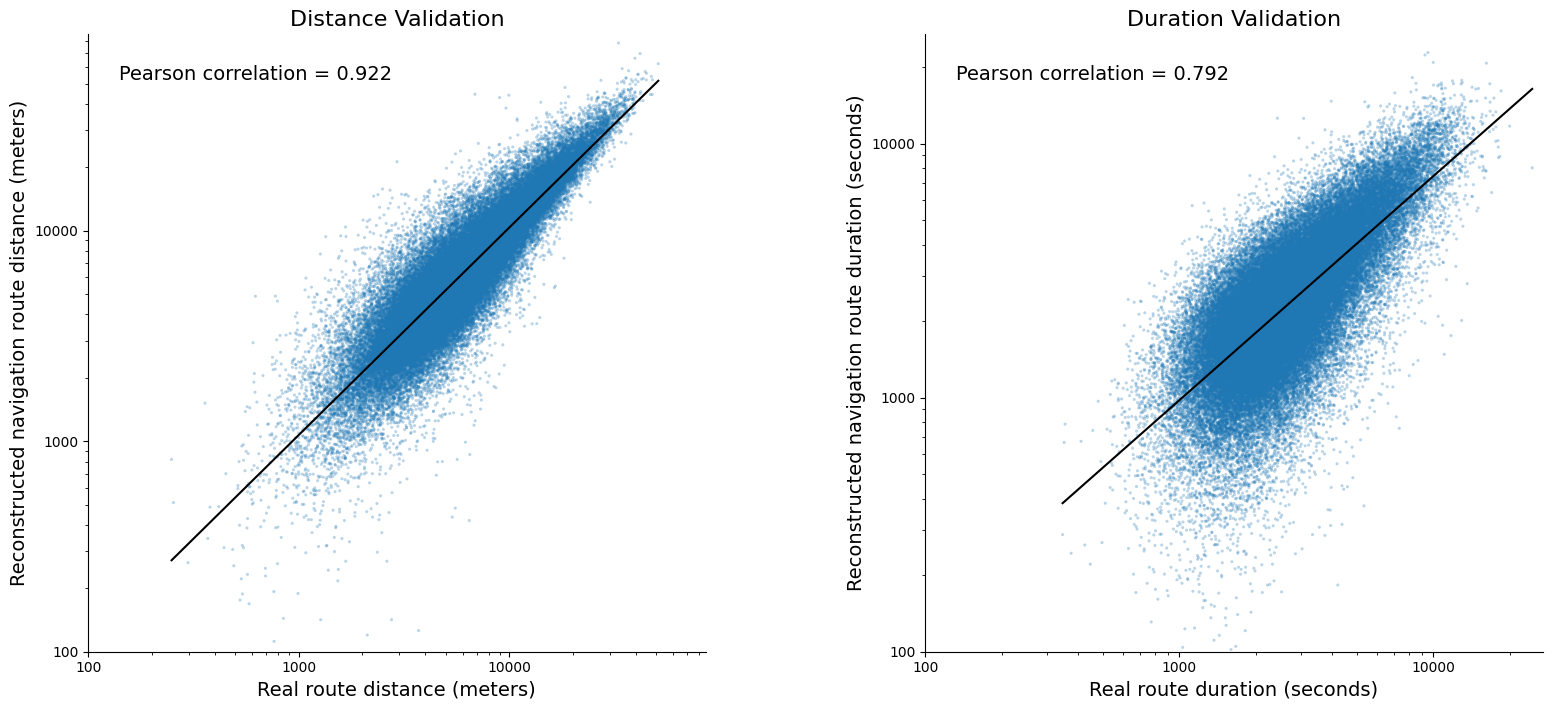

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from scipy import stats

# 假设 final_gdf 已经加载
# try:
#     final_gdf = gpd.read_file('AllDeliveryRoutes.geojson')
# except Exception as e:
#     print(f"读取文件出错: {e}")
#     exit()

# --- 1. 数据准备 ---
# 筛选出路线数据用于分析
routes_df = final_gdf[final_gdf['feature_type'] == 'route'].copy()
print(f"已筛选出 {len(routes_df)} 条路线用于分析。")

# 类型转换和异常值处理
cols_to_analyze = ['r_dur_all', 'nav_dur', 'r_dis_all', 'nav_dis']
for col in cols_to_analyze:
    routes_df[col] = pd.to_numeric(routes_df[col], errors='coerce')

# 删除包含NaN的行，并过滤掉时长或距离小于等于100的数据(因为坐标轴从100开始)
routes_df.dropna(subset=cols_to_analyze, inplace=True)
routes_df = routes_df[(routes_df['r_dur_all'] >= 100) & (routes_df['nav_dur'] >= 100) &
                      (routes_df['r_dis_all'] >= 100) & (routes_df['nav_dis'] >= 100)]
print(f"数据清理后，剩余 {len(routes_df)} 条有效路线。")


# --- 2. 统计计算 (已根据新的XY轴进行修正) ---

# 时长分析 (Y: nav_dur, X: r_dur_all)
correlation_dur = routes_df['r_dur_all'].corr(routes_df['nav_dur'])
slope_dur, intercept_dur, _, _, _ = stats.linregress(np.log(routes_df['r_dur_all']), np.log(routes_df['nav_dur']))
print(f"时长分析 (Y: nav_dur, X: r_dur_all): Pearson Correlation = {correlation_dur:.3f}")

# 距离分析 (Y: nav_dis, X: r_dis_all)
correlation_dis = routes_df['r_dis_all'].corr(routes_df['nav_dis'])
slope_dis, intercept_dis, _, _, _ = stats.linregress(np.log(routes_df['r_dis_all']), np.log(routes_df['nav_dis']))
print(f"距离分析 (Y: nav_dis, X: r_dis_all): Pearson Correlation = {correlation_dis:.3f}")


# --- 3. 仿照新样式进行绘图 ---

# 创建一个1行2列的图床
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7.5))
# fig.suptitle('Validation of Reconstructed Trajectories', fontsize=20)

# --- 左子图: 距离 (Distance) ---
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_aspect('equal', adjustable='box')

# 绘制散点图 (X: r_dis_all, Y: nav_dis)
ax1.scatter(routes_df['r_dis_all'], routes_df['nav_dis'], s=5, alpha=0.3,edgecolors='none')

# 修正回归线的绘制
x_vals_dis = np.logspace(np.log10(routes_df['r_dis_all'].min()), np.log10(routes_df['r_dis_all'].max()), 100)
y_vals_dis = np.exp(intercept_dis + slope_dis * np.log(x_vals_dis))
ax1.plot(x_vals_dis, y_vals_dis, color='black', linewidth=1.5)

# *** 关键修复 3: 设置坐标轴范围 ***
max_val_dis = max(routes_df['nav_dis'].max(), routes_df['r_dis_all'].max()) * 1.1
ax1.set_xlim(100, max_val_dis)
ax1.set_ylim(100, max_val_dis)
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# 标注相关系数
ax1.text(0.05, 0.95, f'Pearson correlation = {correlation_dis:.3f}',
         transform=ax1.transAxes, fontsize=14, verticalalignment='top')

# 设置标题和标签 (使用您指定的标签)
ax1.set_title('Distance Validation', fontsize=16)
ax1.set_xlabel('Real route distance (meters)', fontsize=14)
ax1.set_ylabel('Reconstructed navigation route distance (meters)', fontsize=14)


# 调整坐标轴线 (spines)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# --- 右子图: 时长 (Duration) ---
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_aspect('equal', adjustable='box')

# 绘制散点图 (X: r_dur_all, Y: nav_dur)
ax2.scatter(routes_df['r_dur_all'], routes_df['nav_dur'], s=5, alpha=0.3,edgecolors='none')

# 修正回归线的绘制
x_vals_dur = np.logspace(np.log10(routes_df['r_dur_all'].min()), np.log10(routes_df['r_dur_all'].max()), 100)
y_vals_dur = np.exp(intercept_dur + slope_dur * np.log(x_vals_dur))
ax2.plot(x_vals_dur, y_vals_dur, color='black', linewidth=1.5)

# *** 关键修复 3: 设置坐标轴范围 ***
max_val_dur = max(routes_df['nav_dur'].max(), routes_df['r_dur_all'].max()) * 1.1
ax2.set_xlim(100, max_val_dur)
ax2.set_ylim(100, max_val_dur)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# 标注相关系数
ax2.text(0.05, 0.95, f'Pearson correlation = {correlation_dur:.3f}',
         transform=ax2.transAxes, fontsize=14, verticalalignment='top')

# 设置标题和标签 (使用您指定的标签)
ax2.set_title('Duration Validation', fontsize=16)
ax2.set_xlabel('Real route duration (seconds)', fontsize=14)
ax2.set_ylabel('Reconstructed navigation route duration (seconds)', fontsize=14)

# 调整坐标轴线 (spines)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# --- 保存并显示图像 ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("validation_analysis_final.png", dpi=300)
print("组合验证图已保存为: validation_analysis_final.png")
plt.show()

--- 正在准备点数据用于分析 ---
已筛选出 614706 个点用于分析。

--- 正在分析各时段不同行为的分布 (CST) ---
各时段行为分布图已保存为: hourly_action_type_distribution_styled.png


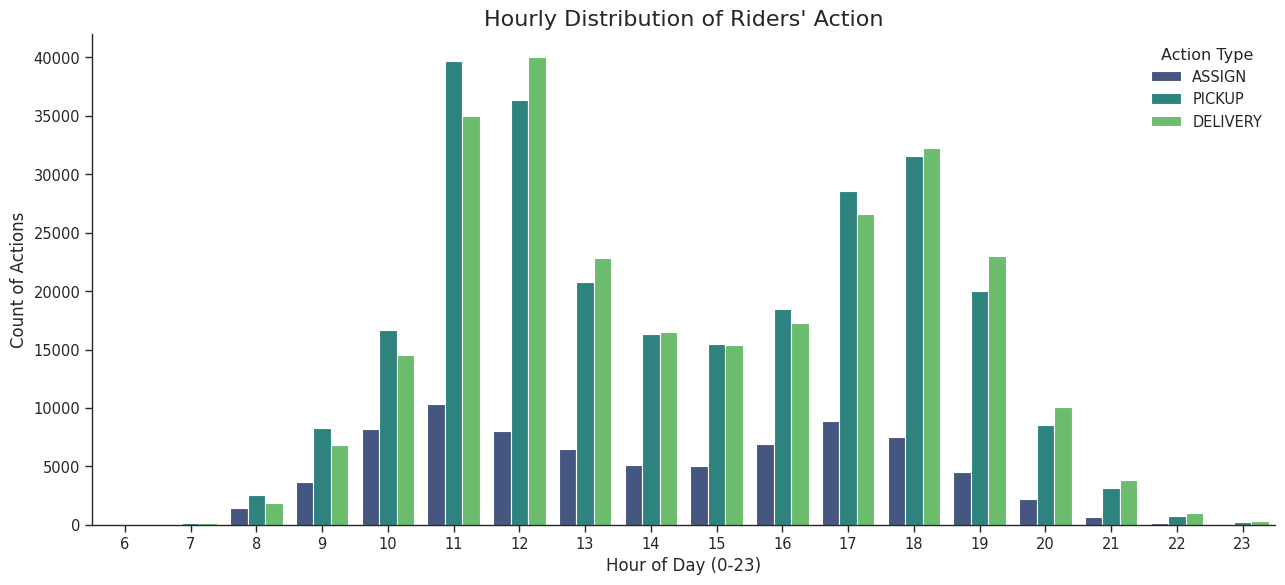


--- 正在分析每日PICKUP点的分布 ---


<ipython-input-41-923296b35dd8>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=legend_title, frameon=False)


每日PICKUP点分布图已保存为: daily_pickup_distribution_styled.png


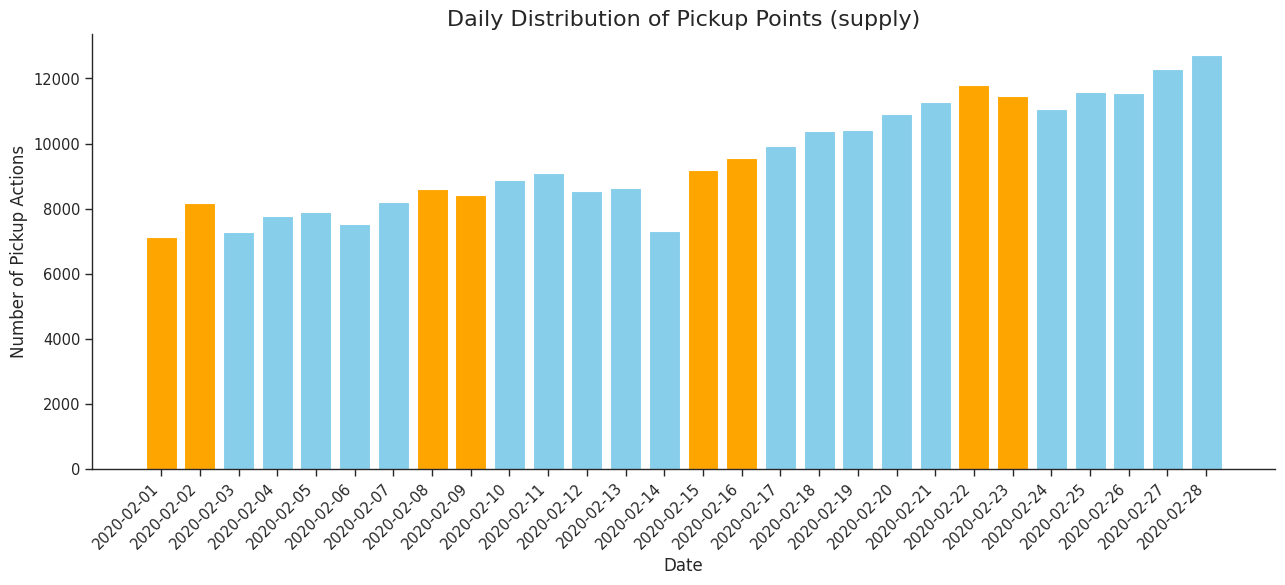


--- 正在分析每小时唯一骑手数量分布 (CST) ---
每小时唯一骑手分布图已保存为: hourly_unique_riders_distribution_styled.png


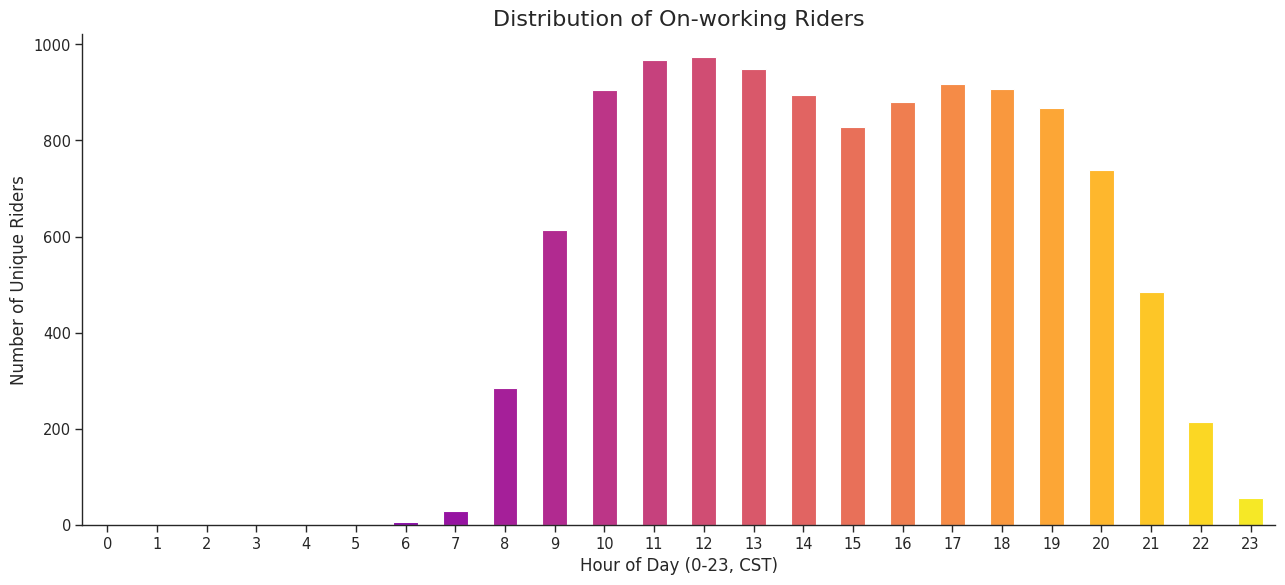

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

def style_plot(ax, legend_title=""):
    """
    一个辅助函数，用于将图表设置为简洁的学术风格。
    - 移除顶部和右侧的轴线
    - 确保无网格
    - 美化图例
    """
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    # 如果存在图例，则去掉边框
    if ax.get_legend():
        ax.legend(title=legend_title, frameon=False)

def analyze_point_distribution_v3(final_gdf):
    """
    基于点数据进行时段和日期维度的分布分析。
    V3更新：
    1. 统一绘图风格为简洁的学术样式。
    """
    # --- 1. 数据准备 (逻辑不变) ---
    print("--- 正在准备点数据用于分析 ---")
    points_df = final_gdf[final_gdf['feature_type'] == 'action_point'].copy()
    if points_df.empty:
        print("错误：未在GeoDataFrame中找到点数据。")
        return
    print(f"已筛选出 {len(points_df)} 个点用于分析。")
    points_df['act_time_utc'] = pd.to_datetime(points_df['act_time'], unit='s', utc=True, errors='coerce')
    points_df.dropna(subset=['act_time_utc'], inplace=True)
    points_df['act_time_cst'] = points_df['act_time_utc'].dt.tz_convert('Asia/Shanghai')
    points_df['hour'] = points_df['act_time_cst'].dt.hour
    try:
        points_df['date'] = pd.to_datetime(points_df['date'], format='mixed')
    except Exception as e:
        print(f"转换'date'列时出错: {e}。")
        return

    # --- 2. 各时段ASSIGN, PICKUP, DELIVERY点的分布 ---
    print("\n--- 正在分析各时段不同行为的分布 (CST) ---")

    # *** 风格切换：设置全局绘图风格 ***
    sns.set_style("ticks")

    plt.figure(figsize=(13, 6))
    ax1 = sns.countplot(data=points_df, x='hour', hue='action_type',
                        hue_order=['ASSIGN', 'PICKUP', 'DELIVERY'], palette='viridis')

    ax1.set_title('Hourly Distribution of Riders\' Action', fontsize=16)
    ax1.set_xlabel('Hour of Day (0-23)', fontsize=12)
    ax1.set_ylabel('Count of Actions', fontsize=12)

    # 应用新风格
    style_plot(ax1, legend_title='Action Type')

    plt.tight_layout()
    plt.savefig("hourly_action_type_distribution_styled.svg")
    print("各时段行为分布图已保存为: hourly_action_type_distribution_styled.png")
    plt.show()

    # --- 3. 不同日期下PICKUP点的分布 ---
    print("\n--- 正在分析每日PICKUP点的分布 ---")
    pickup_df = points_df[points_df['action_type'] == 'PICKUP'].copy()
    if not pickup_df.empty:
        daily_pickup_counts = pickup_df['date'].value_counts().sort_index()
        daily_pickup_counts_df = daily_pickup_counts.reset_index()
        daily_pickup_counts_df.columns = ['date', 'count']
        daily_pickup_counts_df['day_type'] = daily_pickup_counts_df['date'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
        colors = daily_pickup_counts_df['day_type'].map({'Weekday': 'skyblue', 'Weekend': 'orange'})

        plt.figure(figsize=(13, 6))
        # 获取当前坐标轴对象
        ax2 = plt.gca()
        ax2.bar(daily_pickup_counts_df['date'].dt.strftime('%Y-%m-%d'), daily_pickup_counts_df['count'], color=colors)

        import matplotlib.patches as mpatches
        weekday_patch = mpatches.Patch(color='skyblue', label='Weekday')
        weekend_patch = mpatches.Patch(color='orange', label='Weekend')

        ax2.legend(handles=[weekday_patch, weekend_patch], title='Day Type', frameon=False)
        ax2.set_title('Daily Distribution of Pickup Points (supply)', fontsize=16)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Number of Pickup Actions', fontsize=12)
        plt.xticks(rotation=45, ha="right")

        # 应用新风格
        style_plot(ax2)

        plt.tight_layout()
        plt.savefig("daily_pickup_distribution_styled.svg")
        print("每日PICKUP点分布图已保存为: daily_pickup_distribution_styled.png")
        plt.show()
    else:
        print("未找到'PICKUP'类型的点，跳过每日分布图。")

    # --- 4. 每个小时内的唯一骑手数量分布 ---
    print("\n--- 正在分析每小时唯一骑手数量分布 (CST) ---")
    hourly_unique_riders = points_df.groupby('hour')['courier_id'].nunique().sort_index()
    hourly_unique_riders = hourly_unique_riders.reindex(range(24), fill_value=0)

    plt.figure(figsize=(13, 6))
    # .plot()会返回坐标轴对象
    ax3 = hourly_unique_riders.plot(kind='bar', color=sns.color_palette("plasma", 24))

    ax3.set_title('Distribution of On-working Riders', fontsize=16)
    ax3.set_xlabel('Hour of Day (0-23, CST)', fontsize=12)
    ax3.set_ylabel('Number of Unique Riders', fontsize=12)
    plt.xticks(rotation=0)

    # 应用新风格
    style_plot(ax3)

    plt.tight_layout()
    plt.savefig("hourly_unique_riders_distribution_styled.svg")
    print("每小时唯一骑手分布图已保存为: hourly_unique_riders_distribution_styled.png")
    plt.show()


# 确保 final_gdf 已经加载
if 'final_gdf' in locals() and isinstance(final_gdf, gpd.GeoDataFrame) and not final_gdf.empty:
    analyze_point_distribution_v3(final_gdf)
else:
    # 备用逻辑
    print("`final_gdf` 变量未找到, 尝试从文件加载 'AllDeliveryRoutes.geojson'...")
    try:
        final_gdf = gpd.read_file('/content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/AllDeliveryRoutes.geojson')
        print("成功读取 AllDeliveryRoutes.geojson 文件。")
        analyze_point_distribution_v3(final_gdf)
    except Exception as e:
        print(f"读取GeoJSON文件时出错: {e}")

In [ ]:
points_df = final_gdf[final_gdf['feature_type'] == 'action_point'].copy()
pickup_df = points_df[points_df['action_type'] == 'PICKUP'].copy()
pickup_df

Route_id  courier_id        date  no_act  r_dur_all  r_dis_all  \
2459           0    10007871    20200201     NaN        NaN        NaN   
2461           0    10007871    20200201     NaN        NaN        NaN   
2463           0    10007871    20200201     NaN        NaN        NaN   
2466           1    10007871    20200201     NaN        NaN        NaN   
2468           1    10007871    20200201     NaN        NaN        NaN   
...          ...         ...         ...     ...        ...        ...   
694341     79646   125996858  2020-02-28     NaN        NaN        NaN   
694342     79646   125996858  2020-02-28     NaN        NaN        NaN   
694343     79646   125996858  2020-02-28     NaN        NaN        NaN   
694350     79647   125996858  2020-02-28     NaN        NaN        NaN   
694352     79647   125996858  2020-02-28     NaN        NaN        NaN   

        no_nav  nav_dis  nav_dur  rider_lvl  rider_spd  max_load wthr_grd  \
2459       NaN      NaN      NaN        NaN        NaN       NaN     None   
2461       NaN      NaN      NaN        NaN        NaN       NaN     None   
2463       NaN      NaN      NaN        NaN        NaN       NaN     None   
2466       NaN      NaN      NaN        NaN        NaN       NaN     None   
2468       NaN      NaN      NaN        NaN        NaN       NaN     None   
...        ...      ...      ...        ...        ...       ...      ...   
694341     NaN      NaN      NaN        NaN        NaN       NaN     None   
694342     NaN      NaN      NaN        NaN        NaN       NaN     None   
694343     NaN      NaN      NaN        NaN        NaN       NaN     None   
694350     NaN      NaN      NaN        NaN        NaN       NaN     None   
694352     NaN      NaN      NaN        NaN        NaN       NaN     None   

        feature_type act_pt_id      act_time  act_order action_type  \
2459    action_point   0000002  1.580528e+09        2.0      PICKUP   
2461    action_point   0000004  1.580529e+09        4.0      PICKUP   
2463    action_point   0000006  1.580529e+09        6.0      PICKUP   
2466    action_point   0000102  1.580530e+09        2.0      PICKUP   
2468    action_point   0000104  1.580532e+09        4.0      PICKUP   
...              ...       ...           ...        ...         ...   
694341  action_point   7964604  1.582887e+09        4.0      PICKUP   
694342  action_point   7964605  1.582887e+09        5.0      PICKUP   
694343  action_point   7964606  1.582887e+09        6.0      PICKUP   
694350  action_point   7964702  1.582890e+09        2.0      PICKUP   
694352  action_point   7964704  1.582891e+09        4.0      PICKUP   

                          geometry  
2459    POINT (116.50948 39.92317)  
2461    POINT (116.50815 39.92304)  
2463    POINT (116.50851 39.92346)  
2466    POINT (116.50892 39.92376)  
2468    POINT (116.50357 39.93154)  
...                            ...  
694341  POINT (116.32935 39.99144)  
694342  POINT (116.32936 39.99145)  
694343  POINT (116.32916 39.99095)  
694350  POINT (116.32705 39.99077)  
694352   POINT (116.3294 39.99053)  

[267529 rows x 19 columns]

--- Preparing point data for final comparison analysis ---
Filtered 614706 points for analysis.
Data includes 20 unique weekdays and 8 unique weekends.

--- Generating plot for average hourly action types ---
Action Type comparison plot saved as: hourly_actions_average_weekday_vs_weekend.svg



--- Generating plot for total hourly unique riders ---
Unique Rider comparison plot saved as: hourly_riders_total_weekday_vs_weekend.svg


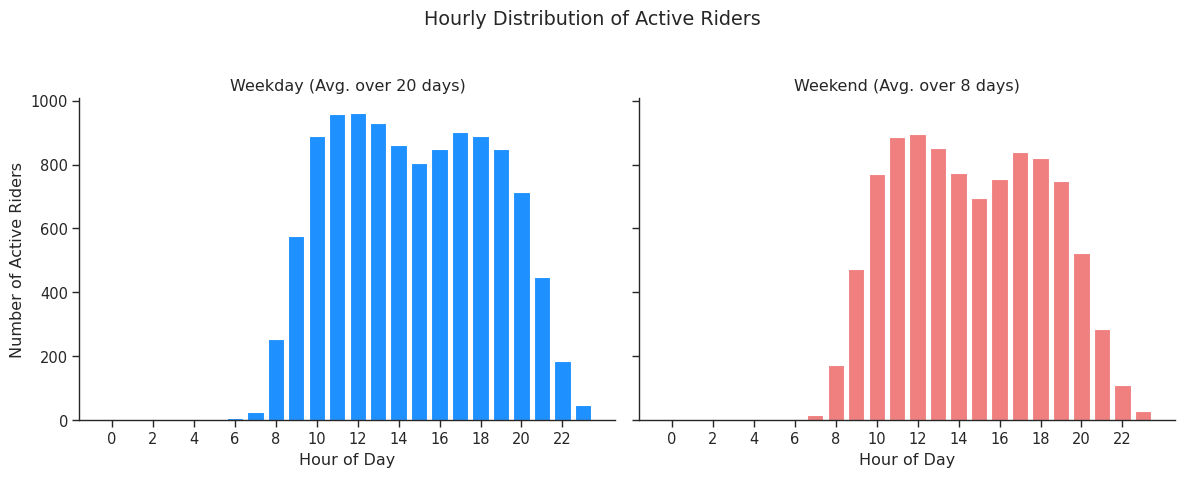

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

def style_ax(ax):
    """Applies a minimalist academic style to a Matplotlib axis."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ax.get_legend():
        ax.legend(frameon=False)

def analyze_final_comparison(final_gdf):
    """
    Final comparison analysis with a unified, publication-ready plotting style.
    - Action Type distribution is shown as a daily average.
    - Unique Rider distribution is shown as a total count.
    - All plots are saved as SVG files.
    """
    # --- 1. Data Preparation ---
    print("--- Preparing point data for final comparison analysis ---")

    points_df = final_gdf[final_gdf['feature_type'] == 'action_point'].copy()
    if points_df.empty:
        print("Error: No 'action_point' data found in the GeoDataFrame.")
        return
    print(f"Filtered {len(points_df)} points for analysis.")

    # Convert timestamps to CST (UTC+8)
    points_df['act_time_utc'] = pd.to_datetime(points_df['act_time'], unit='s', utc=True, errors='coerce')
    points_df.dropna(subset=['act_time_utc'], inplace=True)
    points_df['act_time_cst'] = points_df['act_time_utc'].dt.tz_convert('Asia/Shanghai')
    points_df['hour'] = points_df['act_time_cst'].dt.hour

    # Differentiate weekday vs. weekend
    points_df['date'] = pd.to_datetime(points_df['date'], format='mixed')
    points_df['day_type'] = points_df['date'].dt.dayofweek.apply(
        lambda x: 'Weekend' if x >= 5 else 'Weekday'
    )

    weekday_points = points_df[points_df['day_type'] == 'Weekday']
    weekend_points = points_df[points_df['day_type'] == 'Weekend']

    n_weekdays = weekday_points['date'].nunique()
    n_weekends = weekend_points['date'].nunique()

    if n_weekdays == 0 or n_weekends == 0:
        print("Data for both weekdays and weekends is required for comparison.")
        return
    print(f"Data includes {n_weekdays} unique weekdays and {n_weekends} unique weekends.")

    # --- Set global plotting style for all subsequent figures ---
    sns.set_theme(style="ticks", context="paper", font_scale=1.2)

    # --- 2. Hourly Action Type Distribution (Daily Average) ---
    print("\n--- Generating plot for average hourly action types ---")
    weekday_counts = weekday_points.groupby(['hour', 'action_type']).size().reset_index(name='total_count')
    weekend_counts = weekend_points.groupby(['hour', 'action_type']).size().reset_index(name='total_count')
    weekday_counts['avg_count'] = weekday_counts['total_count'] / n_weekdays
    weekend_counts['avg_count'] = weekend_counts['total_count'] / n_weekends

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle('Hourly Distribution of Average Actions per Day')

    # Weekday subplot
    sns.barplot(ax=axes[0], data=weekday_counts, x='hour', y='avg_count', hue='action_type',
                hue_order=['ASSIGN', 'PICKUP', 'DELIVERY'], palette='viridis')
    axes[0].set_title(f'Weekday (Avg. over {n_weekdays} days)')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Number of Actions')
    style_ax(axes[0]) # Apply style
    axes[0].legend(title='Action Type', frameon=False)

    # Weekend subplot
    sns.barplot(ax=axes[1], data=weekend_counts, x='hour', y='avg_count', hue='action_type',
                hue_order=['ASSIGN', 'PICKUP', 'DELIVERY'], palette='viridis')
    axes[1].set_title(f'Weekend (Avg. over {n_weekends} days)')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('') # Shared Y-axis
    style_ax(axes[1]) # Apply style

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("hourly_actions_average_weekday_vs_weekend.svg", format='svg')
    print("Action Type comparison plot saved as: hourly_actions_average_weekday_vs_weekend.svg")
    plt.show()

    # --- 3. Hourly Unique Rider Distribution (Total Count) ---
    print("\n--- Generating plot for total hourly unique riders ---")
    weekday_total_riders = weekday_points.groupby('hour')['courier_id'].nunique().reindex(range(24), fill_value=0)
    weekend_total_riders = weekend_points.groupby('hour')['courier_id'].nunique().reindex(range(24), fill_value=0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle('Hourly Distribution of Active Riders')

    # Weekday subplot
    axes[0].bar(weekday_total_riders.index, weekday_total_riders.values, color='dodgerblue')
    axes[0].set_title(f'Weekday (Avg. over {n_weekdays} days)') # Title corrected to "Total"
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Number of Active Riders')
    axes[0].set_xticks(range(0, 24, 2)) # Adjust ticks for clarity
    style_ax(axes[0]) # Apply style

    # Weekend subplot
    axes[1].bar(weekend_total_riders.index, weekend_total_riders.values, color='lightcoral')
    axes[1].set_title(f'Weekend (Avg. over {n_weekends} days)') # Title corrected to "Total"
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('') # Shared Y-axis
    axes[1].set_xticks(range(0, 24, 2)) # Adjust ticks for clarity
    style_ax(axes[1]) # Apply style

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("hourly_riders_total_weekday_vs_weekend.svg", format='svg')
    print("Unique Rider comparison plot saved as: hourly_riders_total_weekday_vs_weekend.svg")
    plt.show()

# Make sure final_gdf is loaded
if 'final_gdf' in locals() and isinstance(final_gdf, gpd.GeoDataFrame) and not final_gdf.empty:
    analyze_final_comparison(final_gdf)
else:
    # Fallback logic
    print("`final_gdf` variable not found, attempting to load from file...")
    try:
        final_gdf = gpd.read_file('/content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/AllDeliveryRoutes.geojson')
        print("Successfully read AllDeliveryRoutes.geojson.")
        analyze_final_comparison(final_gdf)
    except Exception as e:
        print(f"Error reading GeoJSON file: {e}")

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

def style_ax(ax):
    """Applies a minimalist academic style to a Matplotlib axis."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ax.get_legend():
        ax.legend(frameon=False)

def analyze_rider_workload(final_gdf):
    """
    分析每个小时内，单个骑手的平均“背单量”（即路线中的PICKUP总数）。
    """
    # --- 1. 数据准备 ---
    print("--- 正在准备点数据用于骑手负载分析 ---")

    points_df = final_gdf[final_gdf['feature_type'] == 'action_point'].copy()
    if points_df.empty:
        print("错误：未在GeoDataFrame中找到点数据。")
        return
    print(f"已筛选出 {len(points_df)} 个点。")

    # --- 2. 计算每条路线的“背单量” ---
    # 筛选出所有PICKUP事件
    pickup_points = points_df[points_df['action_type'] == 'PICKUP']
    # 按Route_id分组，计算每个路线的PICKUP数量
    orders_per_route = pickup_points.groupby('Route_id').size().reset_index(name='orders_per_route')
    print(f"已为 {len(orders_per_route)} 条路线计算了其包含的订单数。")

    # --- 3. 将“背单量”信息合并回主数据 ---
    # 使用 left merge，确保所有点都有数据，即使其所属路线没有PICKUP（理论上不应发生）
    points_with_workload = pd.merge(points_df, orders_per_route, on='Route_id', how='left')
    # 对于没有任何PICKUP的路线，其负载为0
    points_with_workload['orders_per_route'].fillna(0, inplace=True)

    # --- 4. 时间处理与分组 ---
    points_with_workload['act_time_utc'] = pd.to_datetime(points_with_workload['act_time'], unit='s', utc=True, errors='coerce')
    points_with_workload.dropna(subset=['act_time_utc'], inplace=True)
    points_with_workload['act_time_cst'] = points_with_workload['act_time_utc'].dt.tz_convert('Asia/Shanghai')
    points_with_workload['hour'] = points_with_workload['act_time_cst'].dt.hour

    points_with_workload['date'] = pd.to_datetime(points_with_workload['date'], format='mixed')
    points_with_workload['day_type'] = points_with_workload['date'].dt.dayofweek.apply(
        lambda x: 'Weekend' if x >= 5 else 'Weekday'
    )

    weekday_data = points_with_workload[points_with_workload['day_type'] == 'Weekday']
    weekend_data = points_with_workload[points_with_workload['day_type'] == 'Weekend']

    n_weekdays = weekday_data['date'].nunique()
    n_weekends = weekend_data['date'].nunique()

    if n_weekdays == 0 or n_weekends == 0:
        print("数据不足，无法同时对工作日和周末进行分析。")
        return

    print(f"数据包含 {n_weekdays} 个独立工作日和 {n_weekends} 个独立周末。")

    # --- 5. 计算并绘图 ---
    print("\n--- 正在生成骑手每小时平均背单量对比图 ---")

    # 按小时计算平均背单量
    weekday_avg_workload = weekday_data.groupby('hour')['orders_per_route'].mean().reindex(range(24), fill_value=0)
    weekend_avg_workload = weekend_data.groupby('hour')['orders_per_route'].mean().reindex(range(24), fill_value=0)

    # 设置全局绘图风格
    sns.set_theme(style="ticks", context="paper", font_scale=1.2)

    # 创建图床
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle('Hourly Distribution of Average Orders Loaded per Route')

    # 左子图：工作日
    axes[0].bar(weekday_avg_workload.index, weekday_avg_workload.values, color='seagreen')
    axes[0].set_title(f'Weekday (Avg. over {n_weekdays} days)')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Number of Orders per Route')
    axes[0].set_xticks(range(0, 24, 2))
    style_ax(axes[0])

    # 右子图：周末
    axes[1].bar(weekend_avg_workload.index, weekend_avg_workload.values, color='goldenrod')
    axes[1].set_title(f'Weekend (Avg. over {n_weekends} days)')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('') # 共享Y轴
    axes[1].set_xticks(range(0, 24, 2))
    style_ax(axes[1])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("hourly_avg_workload_weekday_vs_weekend.svg", format='svg')
    print("骑手平均背单量对比图已保存为: hourly_avg_workload_weekday_vs_weekend.svg")
    plt.show()


# 确保 final_gdf 已经加载
if 'final_gdf' in locals() and isinstance(final_gdf, gpd.GeoDataFrame) and not final_gdf.empty:
    analyze_rider_workload(final_gdf)
else:
    # 备用逻辑
    print("`final_gdf` 变量未找到, 尝试从文件加载 'AllDeliveryRoutes.geojson'...")
    try:
        final_gdf = gpd.read_file('/content/drive/MyDrive/Deliver_chain/output_routes/cycling_routes/AllDeliveryRoutes.geojson')
        print("成功读取 AllDeliveryRoutes.geojson 文件。")
        analyze_rider_workload(final_gdf)
    except Exception as e:
        print(f"读取GeoJSON文件时出错: {e}")

--- 正在准备点数据用于骑手负载分析 ---
已筛选出 614706 个点。
已为 79648 条路线计算了其包含的订单数。


<ipython-input-11-1212371331>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  points_with_workload['orders_per_route'].fillna(0, inplace=True)


数据包含 20 个独立工作日和 8 个独立周末。

--- 正在生成骑手每小时平均背单量对比图 ---
骑手平均背单量对比图已保存为: hourly_avg_workload_weekday_vs_weekend.svg


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from datetime import datetime, timedelta
import pytz
from matplotlib.lines import Line2D

# Set the global font to a widely available sans-serif font
plt.rcParams['font.family'] = 'sans-serif'

# Data provided by the user
data = {
    'group': [1, 1, 1, 1, 1] + \
             [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] + \
             [3, 3, 3, 3, 3, 3, 3] + \
             [4, 4, 4, 4, 4, 4, 4],
    'act_time': [
        1581752109, 1581753012, 1581753220, 1581753701, 1581754098,
        1581735014, 1581737412, 1581737863, 1581738346, 1581738867, 1581739188,
        1581739772, 1581740959, 1581741160, 1581741432, 1581741724, 1581742208, 1581742718,
        1581729859, 1581732023, 1581732501, 1581732508, 1581732874, 1581733280, 1581734275,
        1581750424, 1581752121, 1581752124, 1581752683, 1581753368, 1581753869, 1581754238
    ],
    'action_typ': [
        'ASSIGN', 'PICKUP', 'PICKUP', 'DELIVERY', 'DELIVERY',
        'ASSIGN', 'PICKUP', 'DELIVERY', 'PICKUP', 'DELIVERY', 'PICKUP', 'DELIVERY',
        'PICKUP', 'DELIVERY', 'PICKUP', 'PICKUP', 'DELIVERY', 'DELIVERY',
        'ASSIGN', 'PICKUP', 'PICKUP', 'PICKUP', 'DELIVERY', 'DELIVERY', 'DELIVERY',
        'ASSIGN', 'PICKUP', 'PICKUP', 'PICKUP', 'DELIVERY', 'DELIVERY', 'DELIVERY'
    ]
}
df = pd.DataFrame(data)
df['act_time_dt'] = pd.to_datetime(df['act_time'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')
df = df.sort_values(by=['group', 'act_time_dt'])

# Calculate duration from ASSIGN for alignment
assign_times = df[df['action_typ'] == 'ASSIGN'].set_index('group')['act_time_dt']
df['assign_time'] = df['group'].map(assign_times)
df['duration_from_assign'] = (df['act_time_dt'] - df['assign_time']).dt.total_seconds() / 60.0

style_guide = {
    'ASSIGN':   {'marker': 'o', 'mfc': 'red',       'mec': 'white', 'mew': 1.5},
    'PICKUP':   {'marker': '^', 'mfc': 'orange',    'mec': 'white', 'mew': 2},
    'DELIVERY': {'marker': 'o', 'mfc': 'white',     'mec': 'orangered', 'mew': 1.5},
}

# Factory function to create a unique formatter for each subplot
def create_time_formatter(base_time):
    def time_formatter(x, pos):
        actual_time = base_time + timedelta(minutes=x)
        # --- NEW: Use '%-I' to remove leading zero from hour ---
        return actual_time.strftime('%-I:%M %p')
    return time_formatter

groups = sorted(df['group'].unique())
# --- NEW: Figure size changed to 13.5 x 8.5 ---
fig, axes = plt.subplots(len(groups), 1, figsize=(13.5, 8.5), dpi=150)
if len(groups) == 1:
    axes = [axes]

for i, group_id in enumerate(groups):
    ax = axes[i]
    group_df = df[df['group'] == group_id]
    base_assign_time = group_df['assign_time'].iloc[0]

    # Plotting Section (markers only)
    ax.get_yaxis().set_visible(False)
    for spine in ['left', 'right', 'top']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['bottom'].set_zorder(0)

    for _, row in group_df.iterrows():
        style = style_guide.get(row['action_typ'])
        if not style: continue

        ax.plot(row['duration_from_assign'], 0,
                marker=style['marker'], markerfacecolor=style['mfc'],
                markeredgecolor=style['mec'], markeredgewidth=style['mew'],
                markersize=16, linestyle='none', clip_on=False, zorder=10)

    # Custom tick generation logic
    last_action_duration = group_df['duration_from_assign'].max()
    tick_interval = 20
    regular_ticks = [t for t in range(0, int(last_action_duration), tick_interval)]

    if regular_ticks and last_action_duration - regular_ticks[-1] < (tick_interval / 2):
        regular_ticks.pop()

    final_ticks = sorted(list(set(regular_ticks + [last_action_duration])))

    # Axis setup
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(left=-5, right=140)

    ax.xaxis.set_major_formatter(mticker.FuncFormatter(create_time_formatter(base_assign_time)))
    ax.set_xticks(final_ticks)

    ax.tick_params(axis='x', rotation=0, labelsize=14, pad=10)
    ax.set_title(f"Delivery Route {group_id}", loc='left', y=0.85, fontsize=18, weight='bold')

# Horizontal legend at the bottom of the figure
legend_elements = [
    Line2D([0], [0], marker=style['marker'], label=key,
           markerfacecolor=style['mfc'], markeredgecolor=style['mec'],
           markeredgewidth=style['mew'], markersize=14, linestyle='None')
    for key, style in style_guide.items()
]

fig.legend(handles=legend_elements,
           loc='lower center',
           bbox_to_anchor=(0.5, 0.1),
           ncol=3,
           fontsize=16,
           frameon=False)

# --- NEW: Super title is removed ---
# fig.suptitle('Analysis of Delivery Routes', fontsize=26, weight='bold')
fig.subplots_adjust(top=0.95, bottom=0.15) # Adjust layout
plt.savefig("Analysis_of_Delivery_Routes.svg", format='svg', bbox_inches='tight')
plt.show()

### CSV转Geopackage

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import ast # For safely evaluating string representations of lists/dicts
import os # For directory creation

# --- Configuration ---
CSV_INPUT_FILE = r'output_routes/amap_routed_wave_data.csv'
# Output GeoPackage file
GPKG_OUTPUT_FILE = 'output_routes/amap_cycling_data.gpkg' # Single GeoPackage file

# --- 1. Load the CSV file ---
try:
    df = pd.read_csv(CSV_INPUT_FILE)
    print(f"Successfully loaded {CSV_INPUT_FILE}")
    print(f"DataFrame shape: {df.shape}")
    required_cols_actual = ['wave_routed_polyline_coords', 'routed_segments_details']
    if not all(col in df.columns for col in required_cols_actual):
        missing_actual = [col for col in required_cols_actual if col not in df.columns]
        print(f"Warning: Expected columns based on data inspection ({', '.join(missing_actual)}) not found. Please double-check CSV structure.")
    else:
        print(f"Found key columns: {', '.join(required_cols_actual)}")

except FileNotFoundError:
    print(f"Error: The file {CSV_INPUT_FILE} was not found.")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    exit()

# --- Helper function to parse polyline strings (lon,lat;lon,lat) ---
def parse_amap_polyline_string(polyline_str):
    if pd.isna(polyline_str) or not polyline_str:
        return []
    coords = []
    try:
        points = polyline_str.split(';')
        for point_str in points:
            if ',' in point_str:
                lon, lat = map(float, point_str.split(','))
                coords.append([lon, lat])
        return coords
    except Exception as e:
        # print(f"Error parsing polyline string '{str(polyline_str)[:50]}...': {e}") # Reduced verbosity
        return []

# --- 2. Function to extract trajectory LineString and intermediate Points data ---
def extract_route_and_points_data(row):
    line_coords_final = []
    intermediate_points_attributes = [] # List of dicts for point attributes

    route_id = row.get('original_gdf_index', row.name)

    segments_data_str = row.get('routed_segments_details')
    parsed_segments_successfully = False

    if pd.notna(segments_data_str):
        try:
            segments_data_list = ast.literal_eval(segments_data_str)
            if isinstance(segments_data_list, list):
                cumulative_time = 0.0
                temp_line_coords_from_steps = []

                for segment in segments_data_list:
                    if not isinstance(segment, dict) or 'nav_steps' not in segment:
                        continue
                    steps = segment.get('nav_steps')
                    if not isinstance(steps, list):
                        continue

                    for step in steps:
                        if not isinstance(step, dict):
                            continue

                        step_polyline_str = step.get('step_polyline_str')
                        if step_polyline_str:
                            current_step_coords = parse_amap_polyline_string(step_polyline_str)
                            if current_step_coords:
                                if not temp_line_coords_from_steps or temp_line_coords_from_steps[-1] != current_step_coords[0]:
                                    temp_line_coords_from_steps.extend(current_step_coords)
                                else:
                                    temp_line_coords_from_steps.extend(current_step_coords[1:])

                                point_geom = Point(current_step_coords[0])
                                action_text = step.get('action', '')
                                if not action_text:
                                    action_text = step.get('instruction', '')

                                step_duration = 0.0
                                try:
                                    step_duration = float(step.get('duration_s', 0))
                                except (ValueError, TypeError):
                                    step_duration = 0.0

                                instruction_text = step.get('instruction', '')
                                road_name_text = step.get('road_name', '')

                                intermediate_points_attributes.append({
                                    'route_id': route_id,
                                    'geometry': point_geom,
                                    'action': str(action_text), # No explicit truncation for GeoPackage
                                    'instruct': str(instruction_text),
                                    'road_name': str(road_name_text),
                                    'step_dur_s': step_duration,
                                    'cum_dur_s': cumulative_time
                                })
                                cumulative_time += step_duration

                if temp_line_coords_from_steps:
                    line_coords_final = temp_line_coords_from_steps
                    parsed_segments_successfully = True
        except Exception as e:
            print(f"Warning: Could not fully parse 'routed_segments_details' for index {row.name}: {e}. May attempt fallback.")

    if not parsed_segments_successfully:
        intermediate_points_attributes = []
        full_coords_str = row.get('wave_routed_polyline_coords')
        if pd.notna(full_coords_str) and isinstance(full_coords_str, str) and full_coords_str not in ['[]', '']:
            try:
                parsed_full_coords = ast.literal_eval(full_coords_str)
                if isinstance(parsed_full_coords, list) and \
                   all(isinstance(p, list) and len(p) == 2 for p in parsed_full_coords):
                    line_coords_final = parsed_full_coords
            except Exception as e:
                pass

    final_line_geometry = None
    if len(line_coords_final) >= 2:
        try:
            final_line_geometry = LineString(line_coords_final)
        except Exception as e:
            print(f"Error creating LineString for index {row.name} from coords {line_coords_final[:2]}...: {e}")
    elif len(line_coords_final) == 1:
        pass

    return final_line_geometry, intermediate_points_attributes

print("\nExtracting route and points data...")
results = df.apply(extract_route_and_points_data, axis=1)

df['route_geometry'] = results.apply(lambda x: x[0])
all_points_attributes_list = []
for item_list in results.apply(lambda x: x[1]):
    all_points_attributes_list.extend(item_list)


# --- 3. Create and Save Routes (LineStrings) Layer to GeoPackage ---
print("\nProcessing route LineStrings...")
routes_gdf_filtered = df[df['route_geometry'].notna()].copy() # Renamed to avoid conflict
if not routes_gdf_filtered.empty:
    # The .is_empty check for GeoSeries requires the DataFrame to actually be a GeoDataFrame or the series a GeoSeries
    # We will convert to GeoDataFrame first, then filter empty.
    # However, LineString([ [1,1] ]) is not empty, but LineString([]) is.
    # Our create_linestring_or_point logic (implicitly via extract_route_and_points_data) should prevent fully empty geoms if coords are valid.
    # A LineString needs at least 2 points. Our function returns None if less than 2 points for the line.
    # So, routes_gdf_filtered[routes_gdf_filtered['route_geometry'].notna()] is the main filter here.
    pass # No further empty check needed here due to current logic

if not routes_gdf_filtered.empty:
    route_cols_to_keep = ['route_geometry']
    optional_route_cols = ['original_gdf_index', 'wave_total_nav_distance_m',
                           'wave_total_nav_duration_s', 'wave_processing_status',
                           'courier_id', 'wave_index', 'num_actions_in_wave']
    for col in optional_route_cols:
        if col in routes_gdf_filtered.columns: # check against the DataFrame being used
            route_cols_to_keep.append(col)
    route_cols_to_keep = list(dict.fromkeys(route_cols_to_keep))

    # Ensure correct DataFrame is used for GeoDataFrame creation
    routes_geodf = gpd.GeoDataFrame(routes_gdf_filtered[route_cols_to_keep], geometry='route_geometry', crs="EPSG:4326")

    # Filter out geometries that might be empty after GDF creation (e.g. LineString([]), though less likely with current parsing)
    if not routes_geodf.empty:
        routes_geodf = routes_geodf[~routes_geodf.geometry.is_empty]

    if not routes_geodf.empty:
        print(f"Created GeoDataFrame for routes with {len(routes_geodf)} valid LineStrings.")
        print("Routes GeoDataFrame head:\n", routes_geodf.head(2))
        try:
            output_dir = os.path.dirname(GPKG_OUTPUT_FILE)
            if output_dir and not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print(f"Created output directory: {output_dir}")

            # Save routes layer to GeoPackage
            routes_geodf.to_file(GPKG_OUTPUT_FILE, layer='routes', driver='GPKG')
            print(f"Successfully saved routes layer to {GPKG_OUTPUT_FILE}")
        except Exception as e:
            print(f"An error occurred while saving the routes layer to GeoPackage: {e}")
    else:
        print("No valid route LineStrings to save after final filtering.")
else:
    print("No route data passed initial filtering (all route_geometry were None).")

# --- 4. Create and Save Intermediate Points Layer to GeoPackage ---
print("\nProcessing intermediate points...")
if all_points_attributes_list:
    points_gdf = gpd.GeoDataFrame(all_points_attributes_list, geometry='geometry', crs="EPSG:4326")

    # Filter out geometries that might be empty (e.g. Point())
    if not points_gdf.empty:
        points_gdf = points_gdf[~points_gdf.geometry.is_empty]

    if not points_gdf.empty:
        print(f"Created GeoDataFrame for intermediate points with {len(points_gdf)} points.")
        print("Points GeoDataFrame head:\n", points_gdf.head(2))
        try:
            output_dir = os.path.dirname(GPKG_OUTPUT_FILE) # Ensure output dir exists
            if output_dir and not os.path.exists(output_dir): # Should have been created already if routes were saved
                os.makedirs(output_dir)

            # Save points layer to the same GeoPackage file
            # This will append a new layer or overwrite if layer='routes' was used again by mistake
            points_gdf.to_file(GPKG_OUTPUT_FILE, layer='route_points', driver='GPKG')
            print(f"Successfully saved intermediate points layer to {GPKG_OUTPUT_FILE}")
        except Exception as e:
            print(f"An error occurred while saving the points layer to GeoPackage: {e}")
    else:
        print("No valid intermediate points to save after final filtering.")
else:
    print("No intermediate points data extracted to save.")

print("\nProcessing complete.")

Successfully loaded output_routes/amap_routed_wave_data.csv
DataFrame shape: (4, 22)
Found key columns: wave_routed_polyline_coords, routed_segments_details

Extracting route and points data...

Processing route LineStrings...
Created GeoDataFrame for routes with 4 valid LineStrings.
Routes GeoDataFrame head:
                                       route_geometry  original_gdf_index  \
0  LINESTRING (116.50793 39.92353, 116.50772 39.9...                   0   
1  LINESTRING (116.50808 39.92375, 116.50807 39.9...                   1   

   wave_total_nav_distance_m  wave_total_nav_duration_s  \
0                       9627                       2954   
1                       9985                       3127   

  wave_processing_status  courier_id  wave_index  num_actions_in_wave  
0       complete_success    10007871           0                    7  
1       complete_success    10007871           1                    9  
Successfully saved routes layer to output_routes/amap_cycling_dat